<img src="https://raw.githubusercontent.com/codecaviar/digital_asset_management/master/assets/bingyune-and-company-logo-6400x3600.png" align="left" width="200" height="auto"/>

<br/><br/><br/><br/>

# Social Distance: How to Pick a Fight with COVID-19 and Win

**BingYune Chen**, Principal Data Scientist<br>
2020-06-03 | 11 minute read

Data is provided by the [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19) | Source code is on [Github](https://github.com/codecaviar)

----------

The goal of this project is to create a model that can provide a 14-day forecast for the number of global COVID-19 cases. The project makes use of the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University.

## Table of Contents

1. [**Project Overview**](#overview)
2. [**Data Exploration**](#data_exploration) 
3. [**Prediction Model**](#prediction)    
4. [**Results**](#results)
5. [**Conclusion**](#conclusion)

<a class="anchor" id="overview"></a>
# 1. Project Overview

Coronavirus is a family of viruses that are named for the crown-like spikes on their surface. The novel coronavirus, also known as SARS-CoV-2, is a contagious respiratory virus that was first reported in Wuhan, China. On February 2, 2020, the World Health Organization designated the name COVID-19 for the disease caused by the novel coronavirus. In response to the ongoing public health emergency, infectious disease researchers from institutions around the globe have developed forecast models to predict the potential spread of COVID-19. Forecasts are useful because they help us understand the most likely outcomes as well as best- and worst-case possibilities — and they can help policymakers make decisions that can lead us closer to those best-case outcomes.

<a class="anchor" id="problem_statement"></a>
## 1.1 Problem Statement

> The goal of this project is to create a model that can provide a 14-day forecast for the number of global COVID-19 cases. 

Time series forecasting is basically the machine learning modeling for time series data (years, days, hours, etc.). We can predict future values using time series modeling. The time series approach is helpful if the data is serially correlated - the relationship between a given variable and a lagged version of itself over various time intervals has a pattern and is not random.

The project makes use of the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19). All of the data, mapping, and analysis in the repository is provided for non-profit public health, educational, and academic purposes. The repository relies upon publicly available data from multiple sources such as the [World Heal Organization](https://www.who.int/), the [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases), and the [US Centers for Disease and Control Prevention](https://www.cdc.gov/coronavirus/2019-ncov/index.html).

<a class="anchor" id="metrics"></a>
## 1.2 Metrics

The project evaluated a set of prediction models using the mean absolute error (MAE) and root mean squared error (MSE). When comparing prediction techniques applied to a single time series, or to several time series with the same units, the MAE is popular as it is easy to both understand and compute. A prediction method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean. The selected models are explored in more detail in the modeling section of this project. In terms of the selected metrics:

**Mean Absolute Error** is the mean of absolute errors. The absolute error is the absolute value of the difference between the predicted value and the observed value. MAE tells you how big of an error you can expect from the forecast on average. If the absolute value is not taken (the signs of the errors are not removed), the average error becomes the Mean Bias Error and is usually intended to measure average model bias. The MAE equation for this work is given as follows, where (n) is the number of daily records, (y-hat) the prediction of confirmed cases, and (y) is the actual number of confirmed cases.

<br/>
<img src="assets/fig1-metric-mean-absolute-error.gif" align="center" width="auto" height="auto"/> 
<p style="text-align:center"> Fig.1. Formula to calculate mean absolute error </p>

**Root Mean Squared Error** is a commonly used measure of the square root of the average of the squared differences between values predicted by a model and the values observed, where a lower score implies better accuracy. For example, a perfect prediction model would have an RMSE of 0. By squaring the errors before calculating the mean, you get a measure of the size of the error that gives more weight to the large but infrequent errors than the mean. The RMSE equation for this work is given as follows, where (n) is the number of daily records, (y-hat) the prediction of confirmed cases, and (y) is the actual number of confirmed cases.

<br/>
<img src="assets/fig2-metric-root-mean-squared-error.gif" align="center" width="auto" height="auto"/> 
<p style="text-align:center"> Fig.2. Formula to calculate root mean squared error </p>

In [1]:
# Import libraries for pandas, numpy, matplotlib, sklearn, etc.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import datetime as dt
import operator

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV

The following csv files were downloaded from COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19).

In [2]:
# Import global confirmed cases
df_confirmed = pd.read_csv('data/time_series_covid19_confirmed_global.csv')

# Import global death totals
df_deaths = pd.read_csv('data/time_series_covid19_deaths_global.csv')

# Import global recovered cases
df_recovered = pd.read_csv('data/time_series_covid19_recovered_global.csv')

# Import global daily cases
df_daily = pd.read_csv('data/daily_reports_global_20200603.csv')

<a class="anchor" id="data_exploration"></a>
# 2. Data Exploration

The project examined the various time series tables to understand past trends of confirmed cases, deaths, and recovered cases. The time series tables included data points taken at daily intervals from the start of the pandemic. Australia, Canada and China data were reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark were listed under the province/state level. The US and other countries were reported at the country level. The time series data was used in later sections to predict future COVID-19 cases.

<a class="anchor" id="wrangling"></a>
## 2.1 Data Wrangling and Feature Engineering

In [3]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3027 non-null   float64
 1   Admin2               3031 non-null   object 
 2   Province_State       3471 non-null   object 
 3   Country_Region       3644 non-null   object 
 4   Last_Update          3644 non-null   object 
 5   Lat                  3572 non-null   float64
 6   Long_                3572 non-null   float64
 7   Confirmed            3644 non-null   int64  
 8   Deaths               3644 non-null   int64  
 9   Recovered            3644 non-null   int64  
 10  Active               3644 non-null   int64  
 11  Combined_Key         3644 non-null   object 
 12  Incidence_Rate       3572 non-null   float64
 13  Case-Fatality_Ratio  3588 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 398.7+ KB


In [4]:
df_confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  5/25/20  5/26/20  5/27/20  5/28/20  \
0        0        0        0  ...    11173    11831    12456    13036   
1        0        0        0  ...     1004     1029     1050     1076   
2        0        0        0  ...     8503     8697     8857     8997   
3        0        0        0  ...      763      763      763      763   
4        0        0        0  ...       70       70       71       74   

   5/29/20  5/30/20  5/31/20  6/1/20  6/2/20  6/3/20  
0    13659    14525    15205   15750   16509   17267  
1     1099     1122     1137    1143    1164    1184  
2     9134     9267     9394    9513    9626    9733  
3      764      764      764     765     844     851  
4       81       84       86      86      86      86  

[5 rows x 138 columns]

In [5]:
# Get the dates for the cases
col = df_confirmed.keys()
confirmed = df_confirmed.loc[:, col[4]:col[-1]]
deaths = df_deaths.loc[:, col[4]:col[-1]]
recovered = df_recovered.loc[:, col[4]:col[-1]]

In [6]:
# Calculate the total confirmed, deaths, recovered, and active cases
from collections import defaultdict

global_total = defaultdict(list)
country_cases = defaultdict(list)
country_deaths = defaultdict(list)
country_recovered = defaultdict(list)

global_keys = ['cases', 'deaths', 'recovered', 'active', 
                 'fatality_rate', 'mortality_rate']
country_keys = ['China', 'Italy', 'US', 'Spain', 'France', 
                'Germany', 'United Kingdom', 'Russia', 'Brazil']

dates = confirmed.keys()

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recovered[i].sum()

    global_values = [confirmed_sum, death_sum, recovered_sum, 
                     confirmed_sum - death_sum - recovered_sum, 
                     (death_sum / confirmed_sum) * 100,
                     death_sum / (7.58 * 10 ** 4)] 
                     # world population 7.58 B per 100,000

    for k1,v1 in zip(global_keys, global_values):
        global_total[k1].append(v1)
        
    for k2 in country_keys:
        country_cases[k2].append(
            df_confirmed[df_confirmed['Country/Region']==k2][i].sum())
        country_deaths[k2].append(
            df_deaths[df_deaths['Country/Region']==k2][i].sum())
        country_recovered[k2].append(
            df_recovered[df_recovered['Country/Region']==k2][i].sum())

# Set dates as index for DataFrames
df_global = pd.DataFrame(global_total, index=pd.DatetimeIndex(dates))
df_country_cases = pd.DataFrame(country_cases, index=pd.DatetimeIndex(dates))
df_country_deaths = pd.DataFrame(country_deaths, index=pd.DatetimeIndex(dates))
df_country_recovered = pd.DataFrame(country_recovered, index=pd.DatetimeIndex(dates))

In [7]:
# Create a function to calculate daily increases
def daily_increase(date_data):
    daily_up = list()
    
    for i in range(len(date_data)):
        
        if i == 0:
            daily_up.append(date_data[0])
        else:
            daily_up.append(date_data[i] - date_data[i-1])
            
    return daily_up

daily_cases = {}
daily_deaths = {}
daily_recovered = {}

daily_cases['global'] = daily_increase(global_total['cases'])
daily_deaths['global'] = daily_increase(global_total['deaths'])
daily_recovered['global'] = daily_increase(global_total['recovered'])

for k in country_keys:
    daily_cases[k] = daily_increase(country_cases[k])
    daily_deaths[k] = daily_increase(country_deaths[k])
    daily_recovered[k] = daily_increase(country_recovered[k])

# Set dates as index for DataFrames
df_daily_cases = pd.DataFrame(daily_cases, index=pd.DatetimeIndex(dates))
df_daily_deaths = pd.DataFrame(daily_deaths, index=pd.DatetimeIndex(dates))
df_daily_recovered = pd.DataFrame(daily_recovered, index=pd.DatetimeIndex(dates))

In [8]:
# Set data up for future forecasting
days_since_start = np.array([x for x in range(len(dates))]).reshape(-1, 1)
days_after_today = 14 # two weeks

future_forecast = np.array(
    [x for x in range(len(dates)+days_after_today)]).reshape(-1,1)

# Convert integer into datetime format
actual_dates = np.array([np.datetime64('2020-01-22') + np.timedelta64(i, 'D') 
                         for i in days_since_start.reshape(1, -1)[0]])

future_dates = np.array([np.datetime64('2020-01-22') + np.timedelta64(i, 'D')
                         for i in future_forecast.reshape(1,-1)[0]])

<a class="anchor" id="exploratory_analysis"></a>
## 2.2 Exploratory Data Analysis

Countries around the world are working to "flatten the curve" of the COVID-19 pandemic. Flattening the curve involves reducing the number of new COVID-19 cases from one day to the next, which helps to make hospital caseloads more manageable. When a country has fewer new COVID-19 cases emerging today than it did on a previous day, that’s a sign that the country is flattening the curve.

On a trend line of total cases, a flattened curve looks how it sounds: flat. On the chart for "Global Daily Increase in Cases Over Time," which shows new cases per day, a flattened curve would show a downward trend in the number of daily new cases. Unfortunately, the trajectory of the COVID-19 pandemic continues to vary widely from country to country. The number of new cases each day appears to be leveling off or falling in some countries such Italy and Germany - most likely because of the countries' strict lockdown efforts. China, where the pandemic began, appears to have drastically reduced both the number of new cases and new deaths. On the other hand, in the United States, the number of new confirmed cases is still multiplying rapidly, as some states continue to resist the [more stringent measures](https://time.com/5827156/squashing-squash-curve-coronavirus-covid19/). 

The charts are not without limitations. Each country may have different reporting guidelines, which makes it more challenging to make specific comparisons among countries. Additionally, some countries may be less proactive about testing or reach a limit in their ability to test, which could cause their numbers to be understated. Nevertheless, these charts provide a way to measure the overall trajectory of the COVID-19 pandemic in each country and give insight into which ones are still struggling to control the pandemic. 

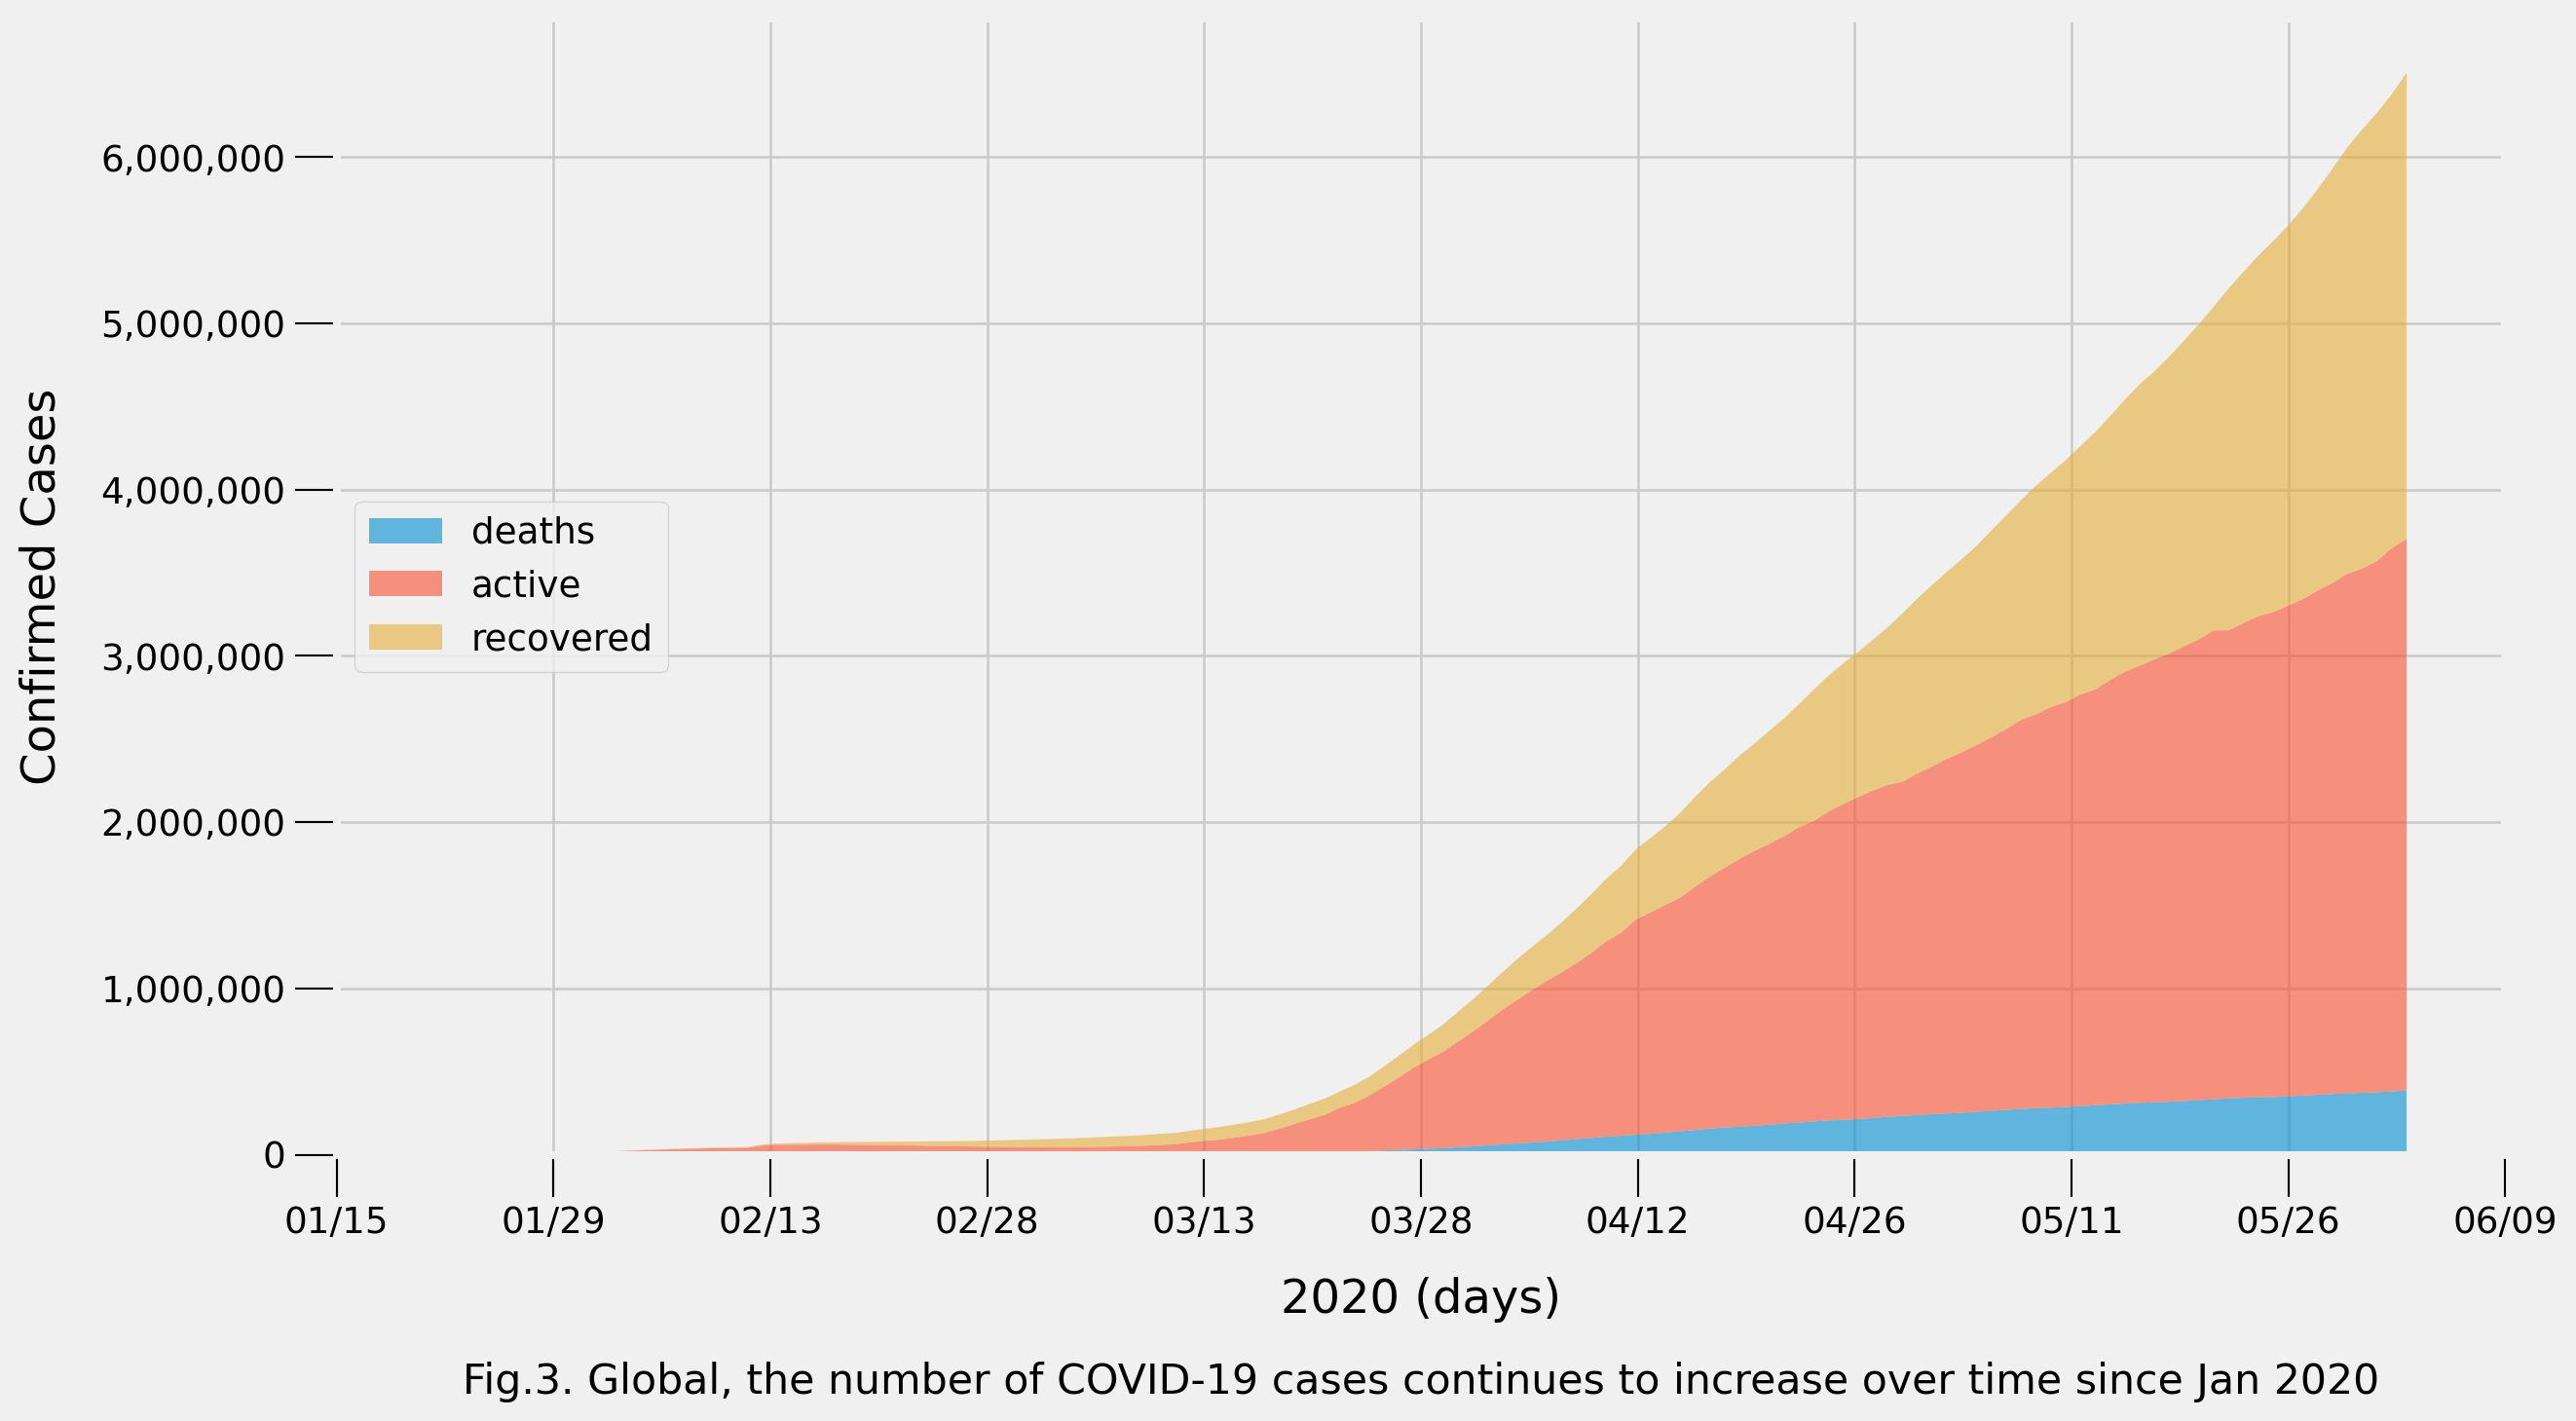

In [9]:
# Graph the number of confirmed, deaths, and recovered cases
import matplotlib
global_active = df_global['active']
global_deaths = df_global['deaths']
global_recovered = df_global['recovered']

fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

ax.stackplot(df_global.index, global_deaths, global_active, global_recovered, 
              alpha=0.6, linewidth=2)

# Label plot
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.set_ylabel('Confirmed Cases', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['deaths', 'active', 'recovered'], loc='center left', prop={"size":14})

# Add caption
fignum = 3
figtxt = ' Global, the number of COVID-19 cases continues to increase over time since Jan 2020' 
figcap = 'Fig.' + str(fignum) + '.' + figtxt
ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Display the plot
plt.savefig('fig' + str(fignum) + '-global-number-covid19-cases.png', bbox_inches='tight')
plt.show();

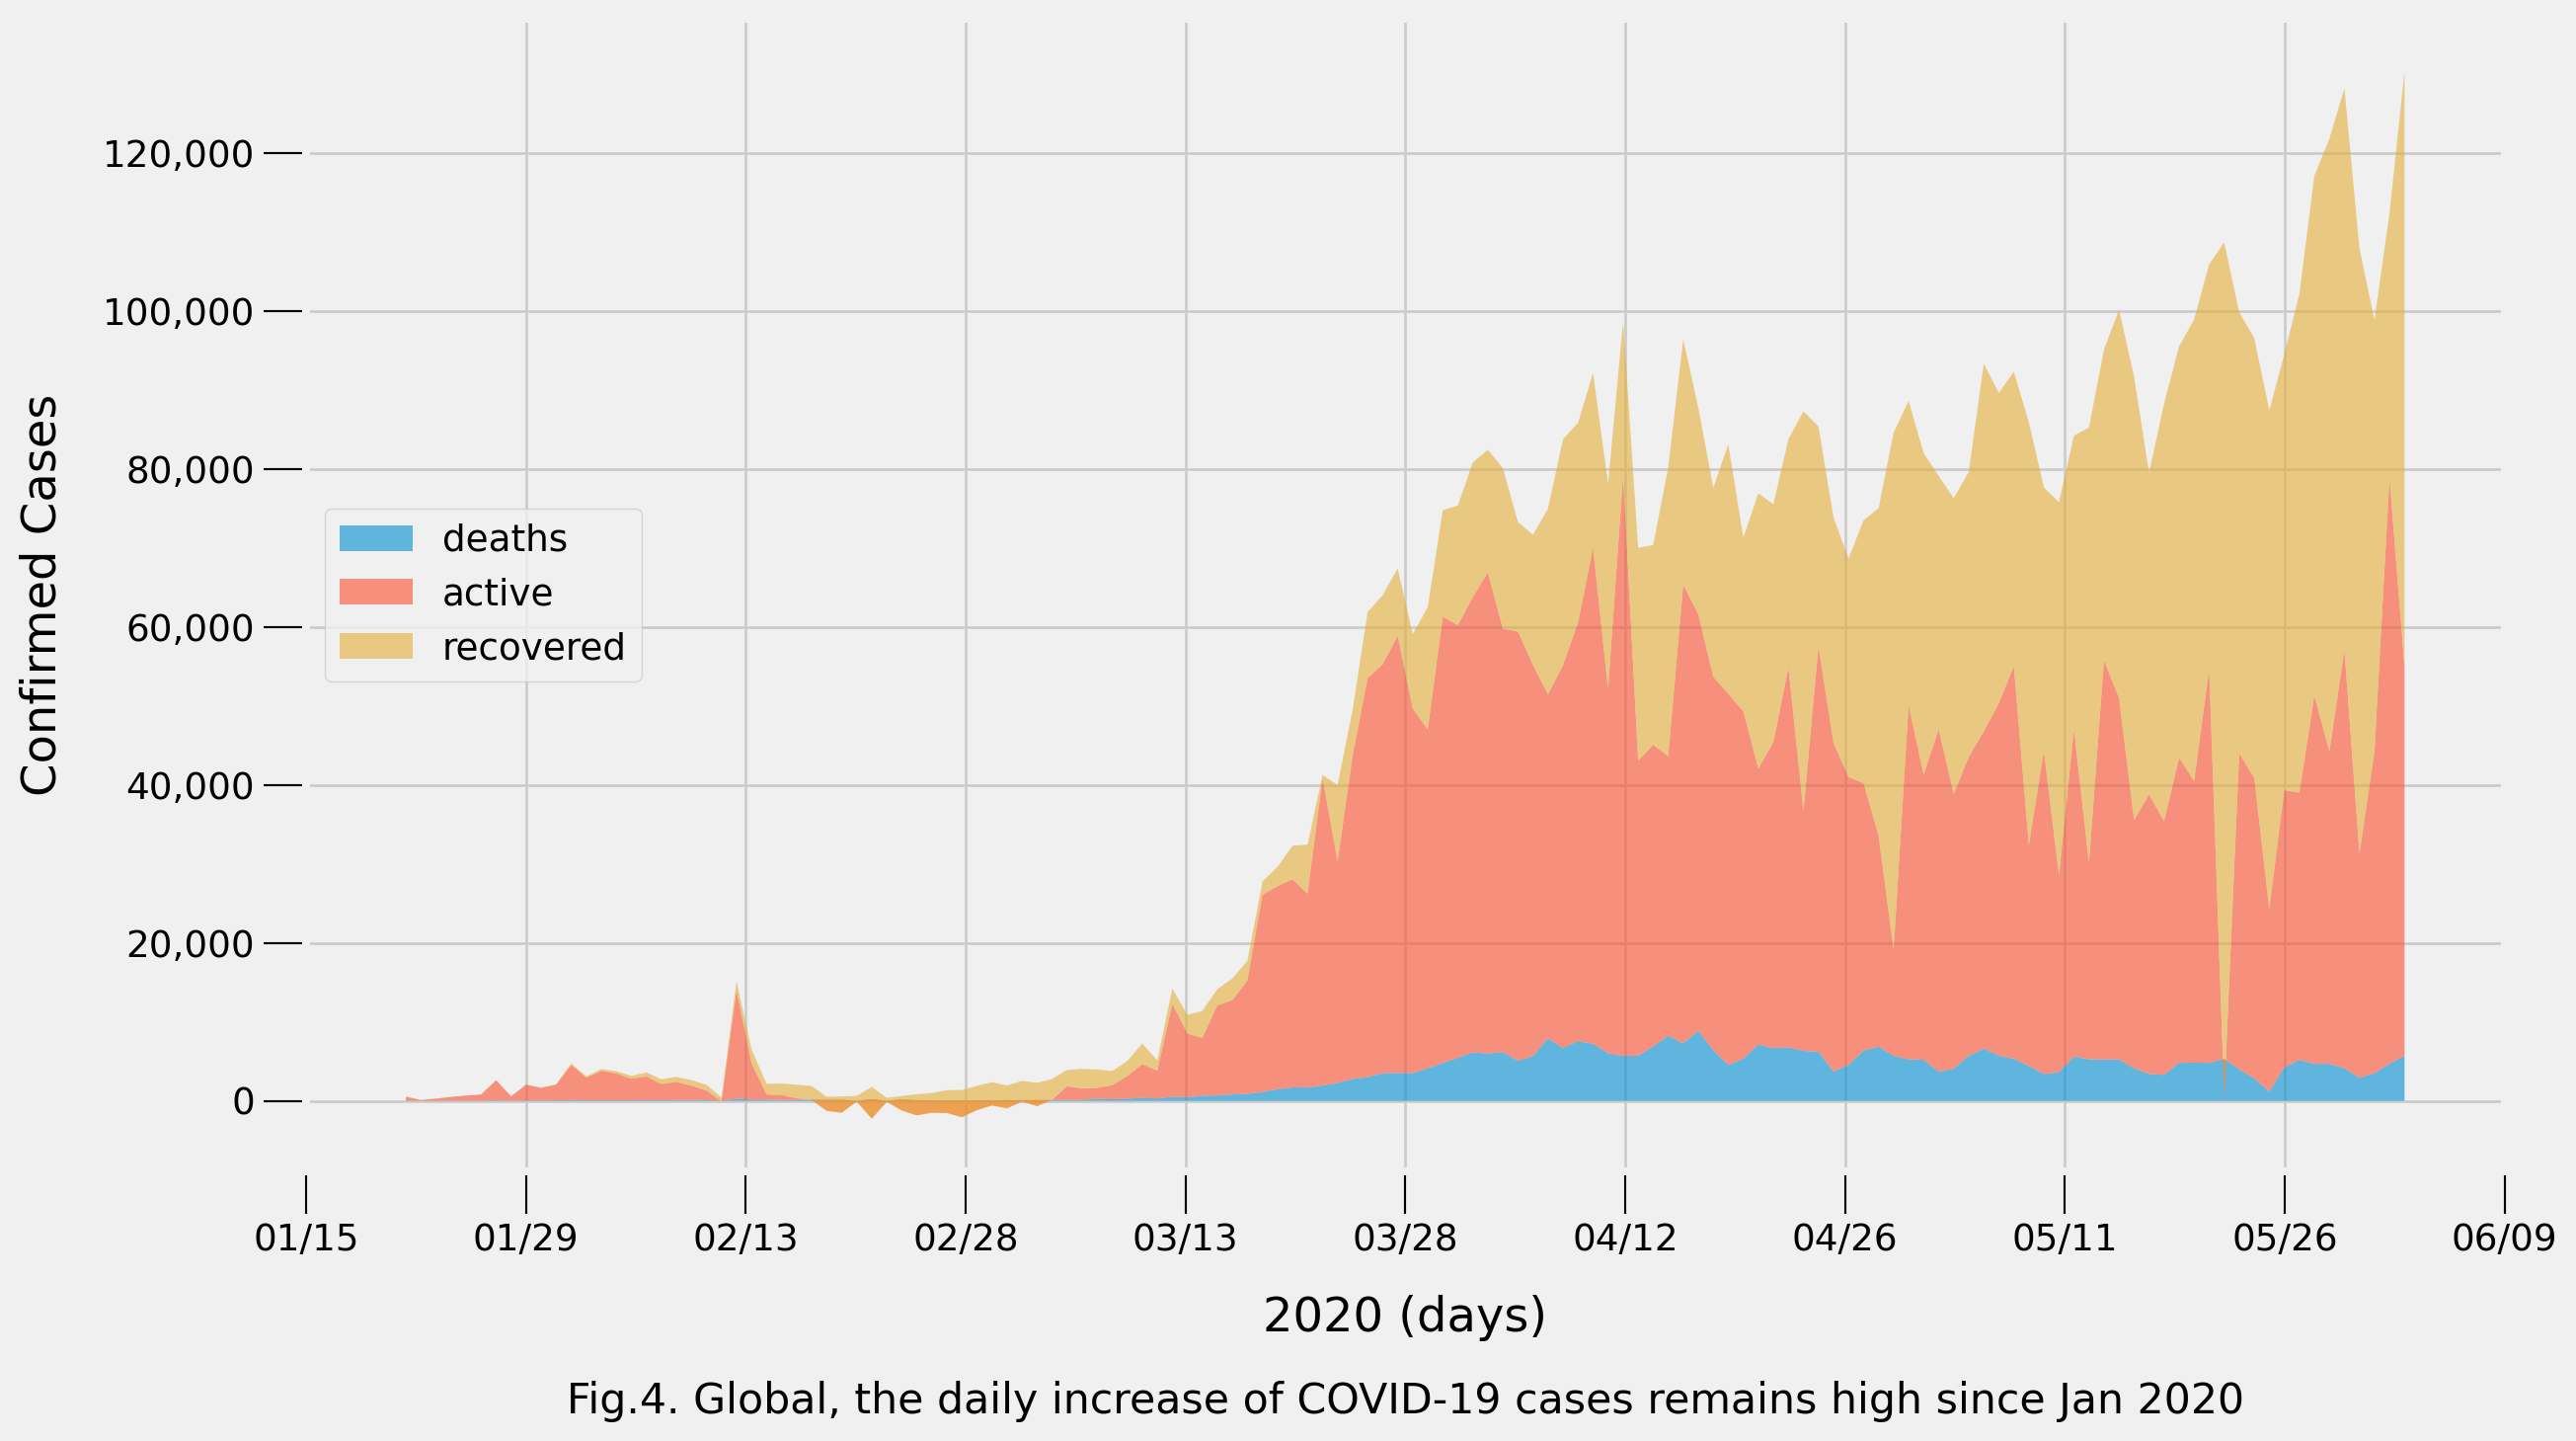

In [10]:
# Graph the number of daily confirmed, deaths, and recovered cases
global_daily_cases = df_daily_cases['global']
global_daily_deaths = df_daily_deaths['global']
global_daily_recovered = df_daily_recovered['global']
                                                               
fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.stackplot(df_daily_cases.index, global_daily_deaths, 
              global_daily_cases - global_daily_deaths - global_daily_recovered,
              global_daily_recovered, alpha=0.6, linewidth=2)

# Label plot
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.set_ylabel('Confirmed Cases', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['deaths', 'active', 'recovered'], loc='center left', prop={"size":14})

# Add caption
fignum = 4
figtxt = ' Global, the daily increase of COVID-19 cases remains high since Jan 2020' 
figcap = 'Fig.' + str(fignum) + '.' + figtxt
ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Display the plot
plt.savefig('fig' + str(fignum) + '-global-daily-increase-covid19-cases.png', bbox_inches='tight')
plt.show();

Because of the nature of data modeling, it will be hard for any country to predict its peak number of confirmed cases. Many factors must be considered on how the country is dealing with the virus. However, looking at trends, especially on a log scale, can help us get a better picture of the current situation. 

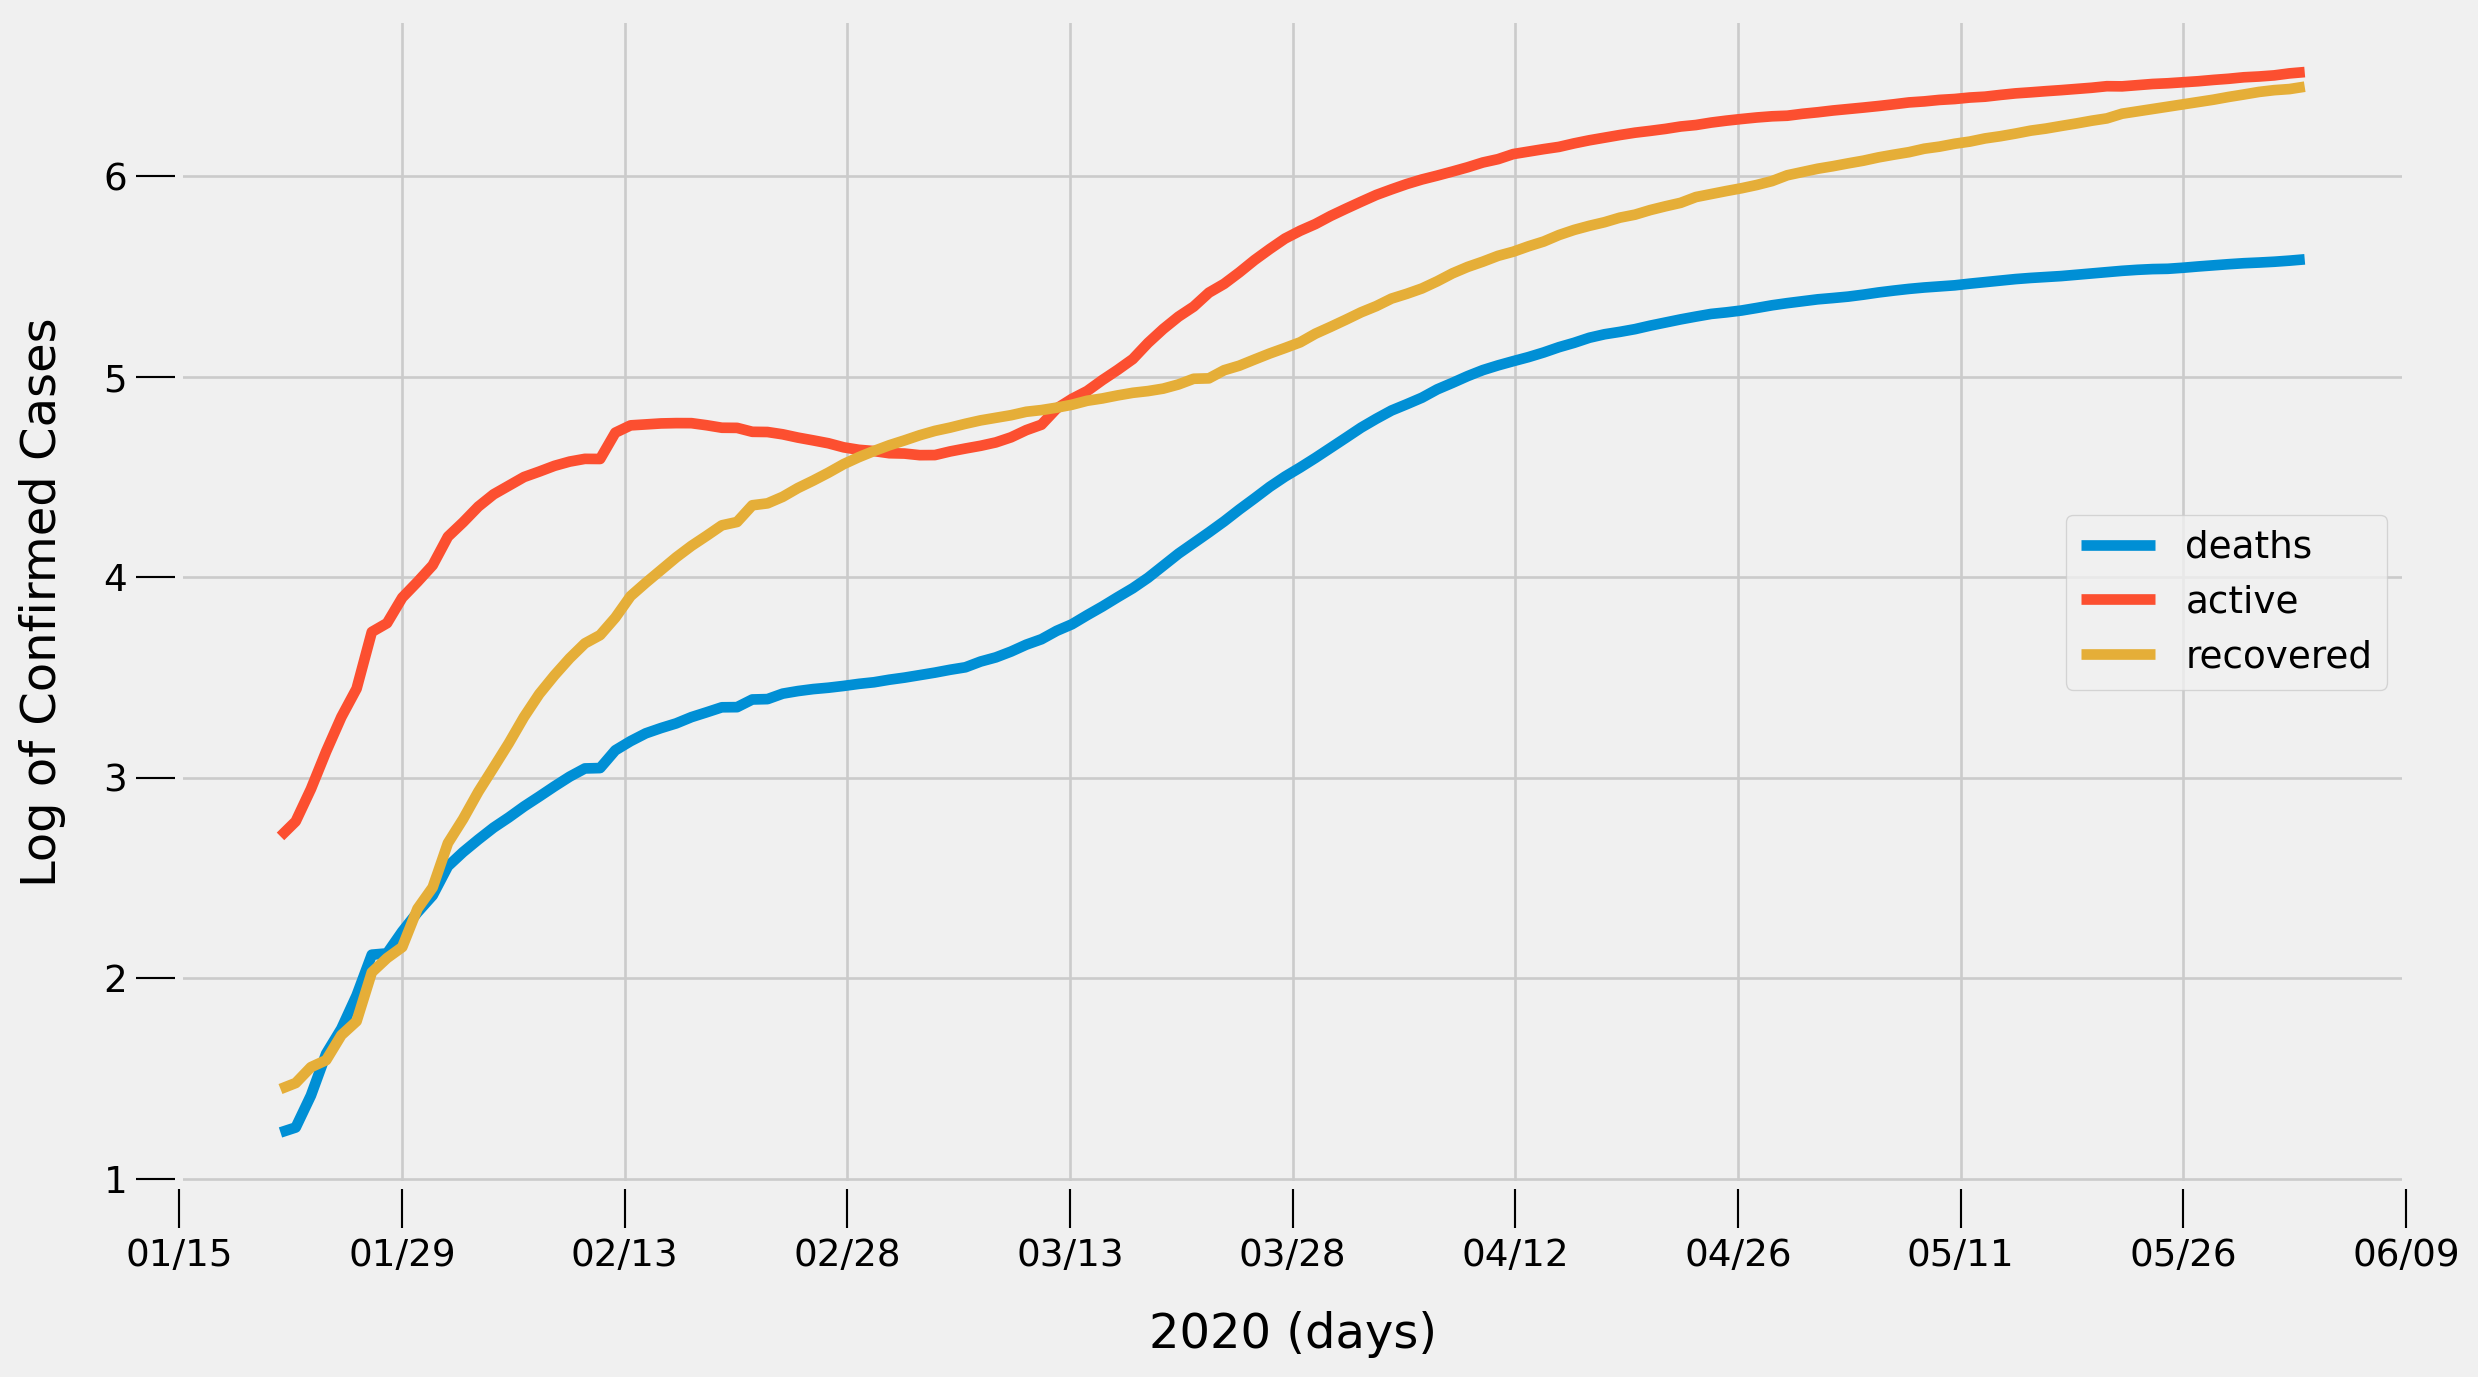

In [11]:
# Graph the LOG number of daily confirmed, deaths, and recovered cases
fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(global_deaths.index, np.log10(global_deaths), linewidth=4)
ax.plot(global_active.index, np.log10(global_active),linewidth=4)
ax.plot(global_recovered.index, np.log10(global_recovered), linewidth=4)

# Label plot
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.set_ylabel('Log of Confirmed Cases', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['deaths', 'active', 'recovered'], loc='center right', prop={"size":14})

plt.show();

In [12]:
# Create a function to graph the country number of confirmed, deaths, and recovered cases
def country_plot(x_dates, country, fign):
    
    specific_cases = df_country_cases[country]
    specific_deaths = df_country_deaths[country]
    specific_recovered = df_country_recovered[country]
    
    country_daily_cases = df_daily_cases[country]
    country_daily_deaths = df_daily_deaths[country]
    country_daily_recovered = df_daily_recovered[country]
    
    # Create graph of confirmed cases
    fig,ax = plt.subplots(2, figsize=(13.33, 7.5), dpi=96)
    fig.tight_layout(pad=3.0)
    
    ax[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
        lambda x, p: format(int(x), ',')))
    ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax[0].xaxis.set_major_locator(matplotlib.ticker.LinearLocator())
    
    ax[0].stackplot(x_dates, specific_deaths, 
                  specific_cases - specific_deaths - specific_recovered,
                  specific_recovered, alpha=0.6, linewidth=2)

    # Label plot
    ax[0].set_ylabel('Confirmed Cases', size=14, labelpad=14)
    ax[0].tick_params(axis='both', size=16)
    ax[0].legend(['deaths', 'active', 'recovered'], loc='upper left', prop={"size":14})
    
    # Add graph of daily increase
    ax[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
        lambda x, p: format(int(x), ',')))
    ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax[1].xaxis.set_major_locator(matplotlib.ticker.LinearLocator())
    
    ax[1].stackplot(x_dates, country_daily_deaths, 
                  country_daily_cases - country_daily_deaths - country_daily_recovered,
                  country_daily_recovered, alpha=0.6, linewidth=2)

    # Label plot
    ax[1].set_ylabel('Confirmed Cases', size=14, labelpad=14)
    ax[1].set_xlabel('2020 (days)', size=18, labelpad=14)
    ax[1].tick_params(axis='both', size=16)

    # Add caption
    fignum = fign
    figtxt = " {}, the total number and daily increase in COVID-19 cases since Jan 2020".format(country) 
    figcap = 'Fig.' + str(fignum) + '.' + figtxt
    ax[1].text(0.5, -0.5, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

    # Display the plot
    plt.savefig('fig' + str(fignum) + "-" + country.lower() + '-number-covid19-cases.png', bbox_inches='tight')
    plt.show();

Each country has its own socio-cultural reasons that contribute to the rate of spread and its own approach to dealing with that rate of spread. For example, at the beginning of the pandemic in the US, the virus was most concentrated in urban centers, primarily New York City and its surrounding suburbs. The virus is able to flourish in those places because the region is densely packed with people, exposing them to a virus that takes several days for symptoms to show up.

We also know that testing tends to focus on people who are most severely ill. In other words, the current testing strategies are missing a lot of those mild cases, and it's definitely missing anyone who doesn't have symptoms. As a result, we can conclude that the confirmed case numbers are underestimates, and they also vary a lot by country because there'll be different availability of testing in different countries.

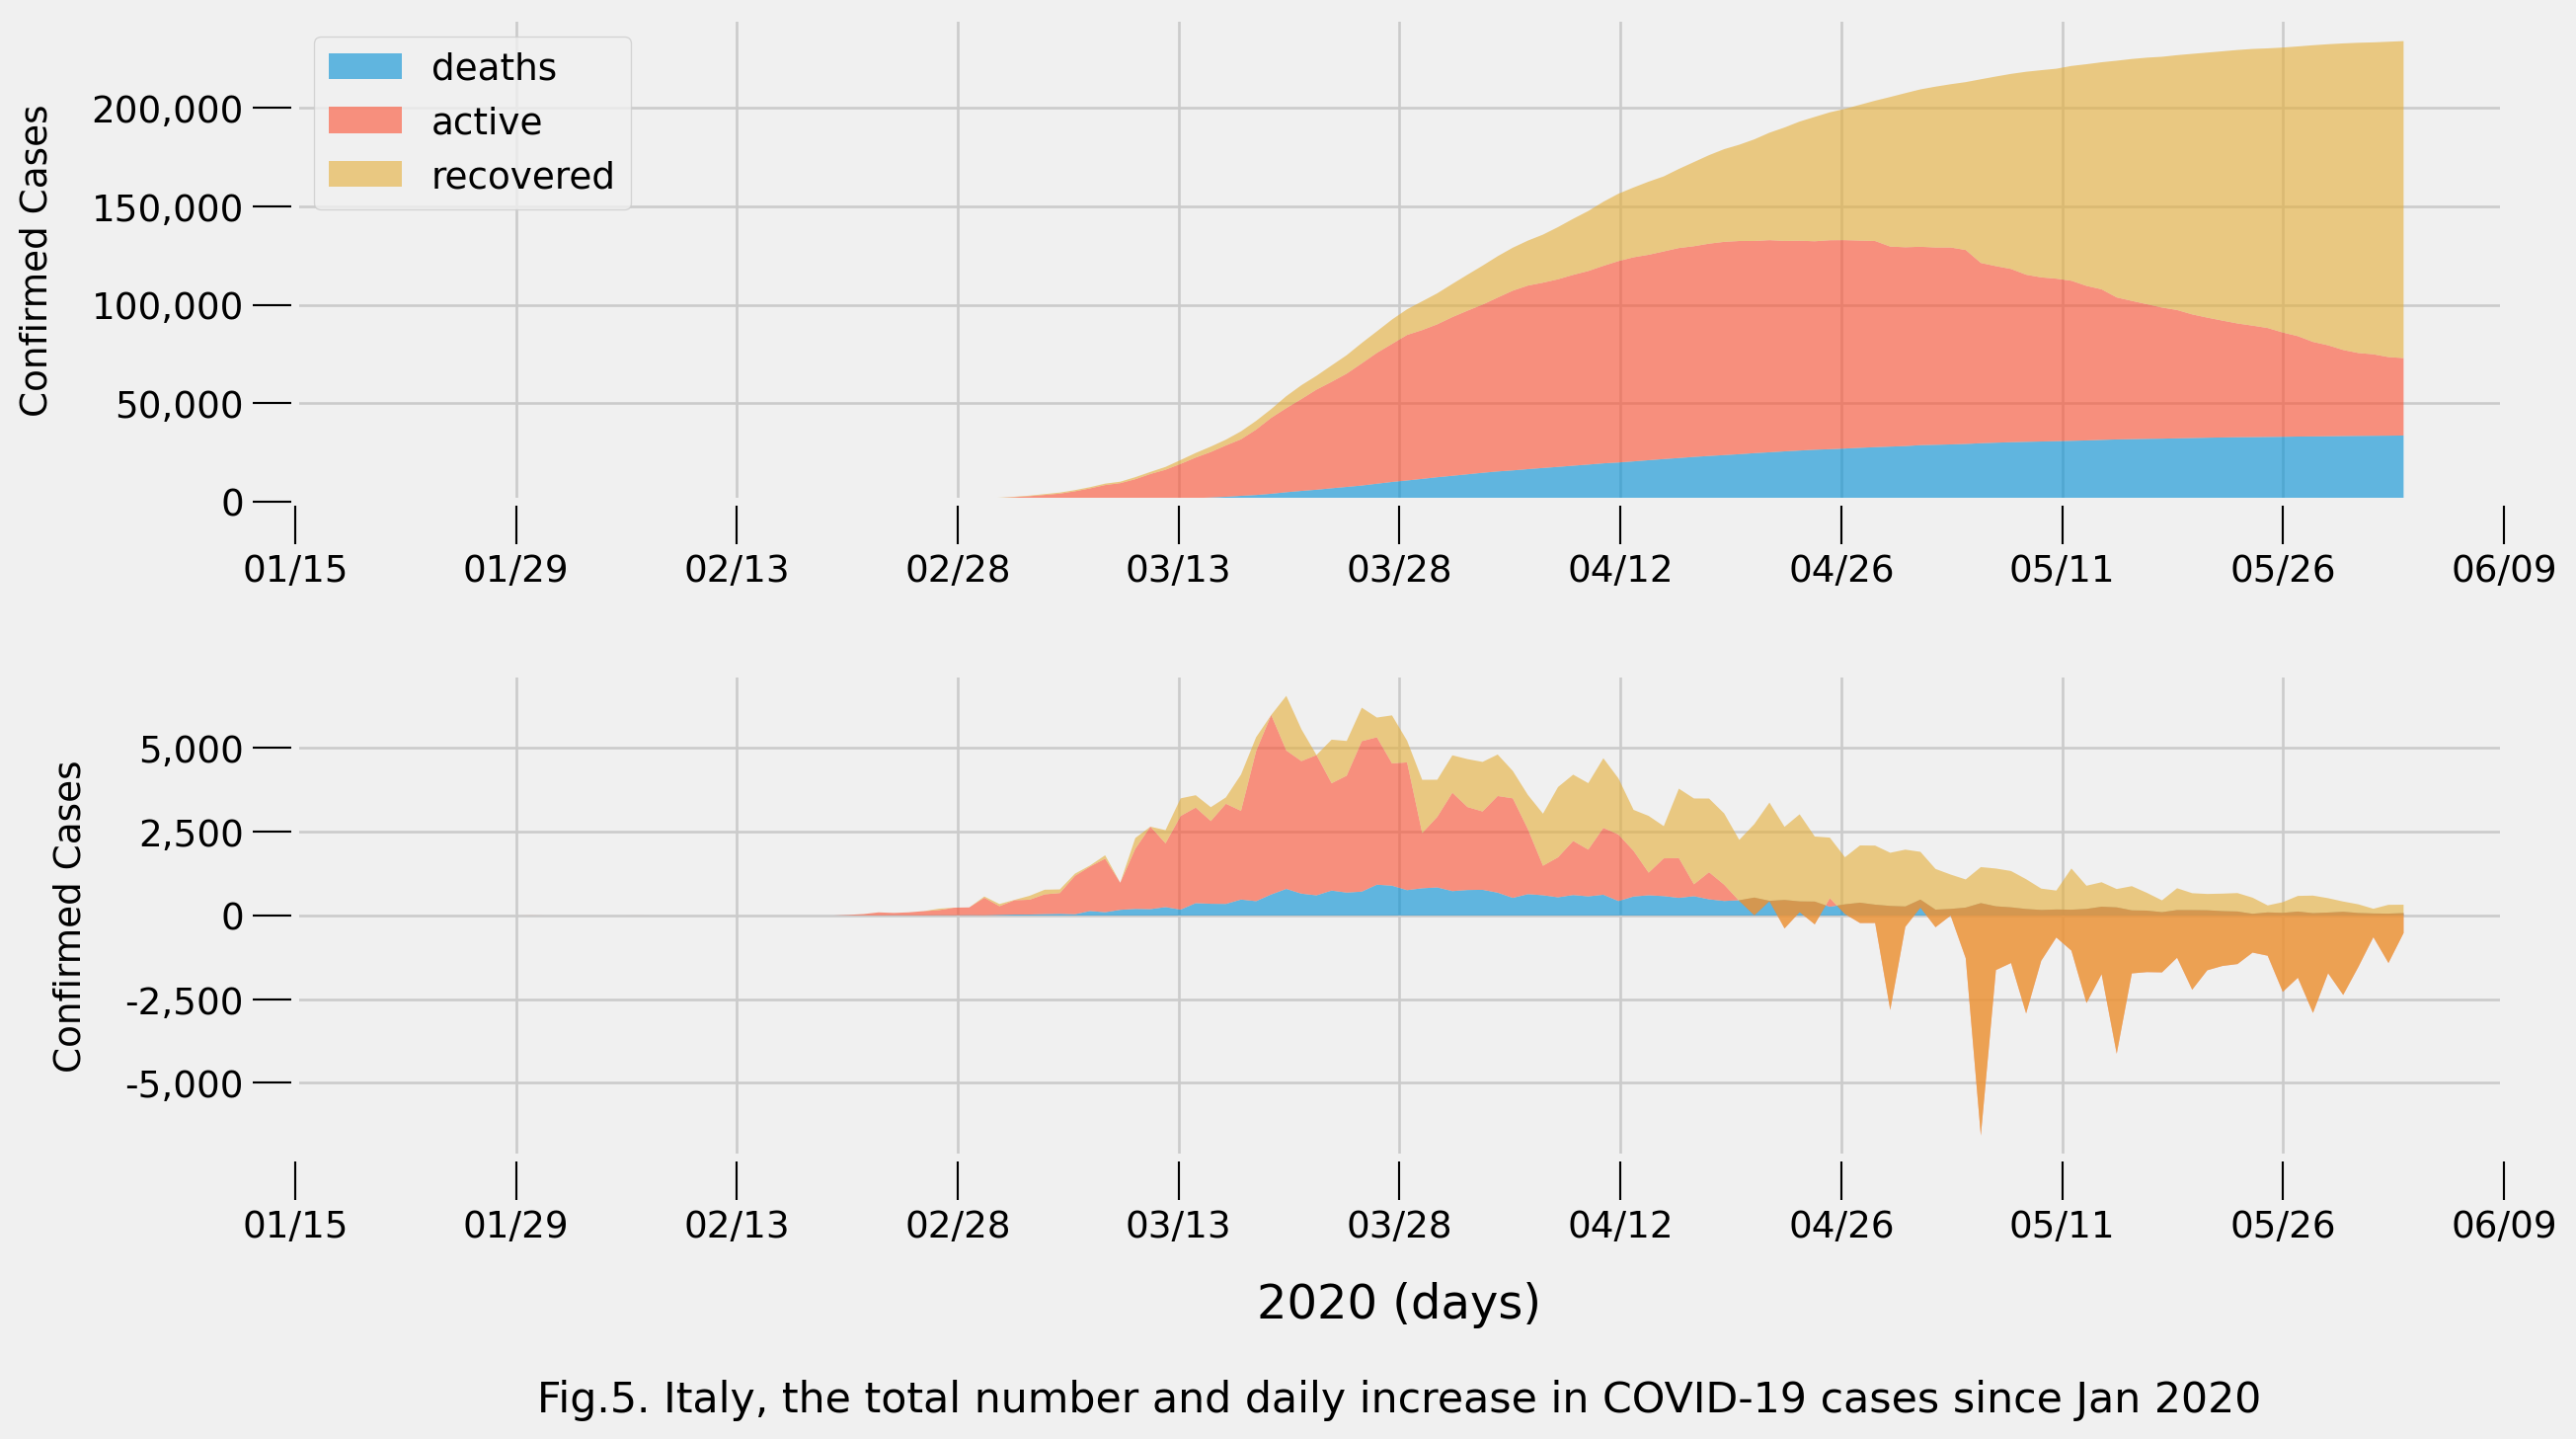

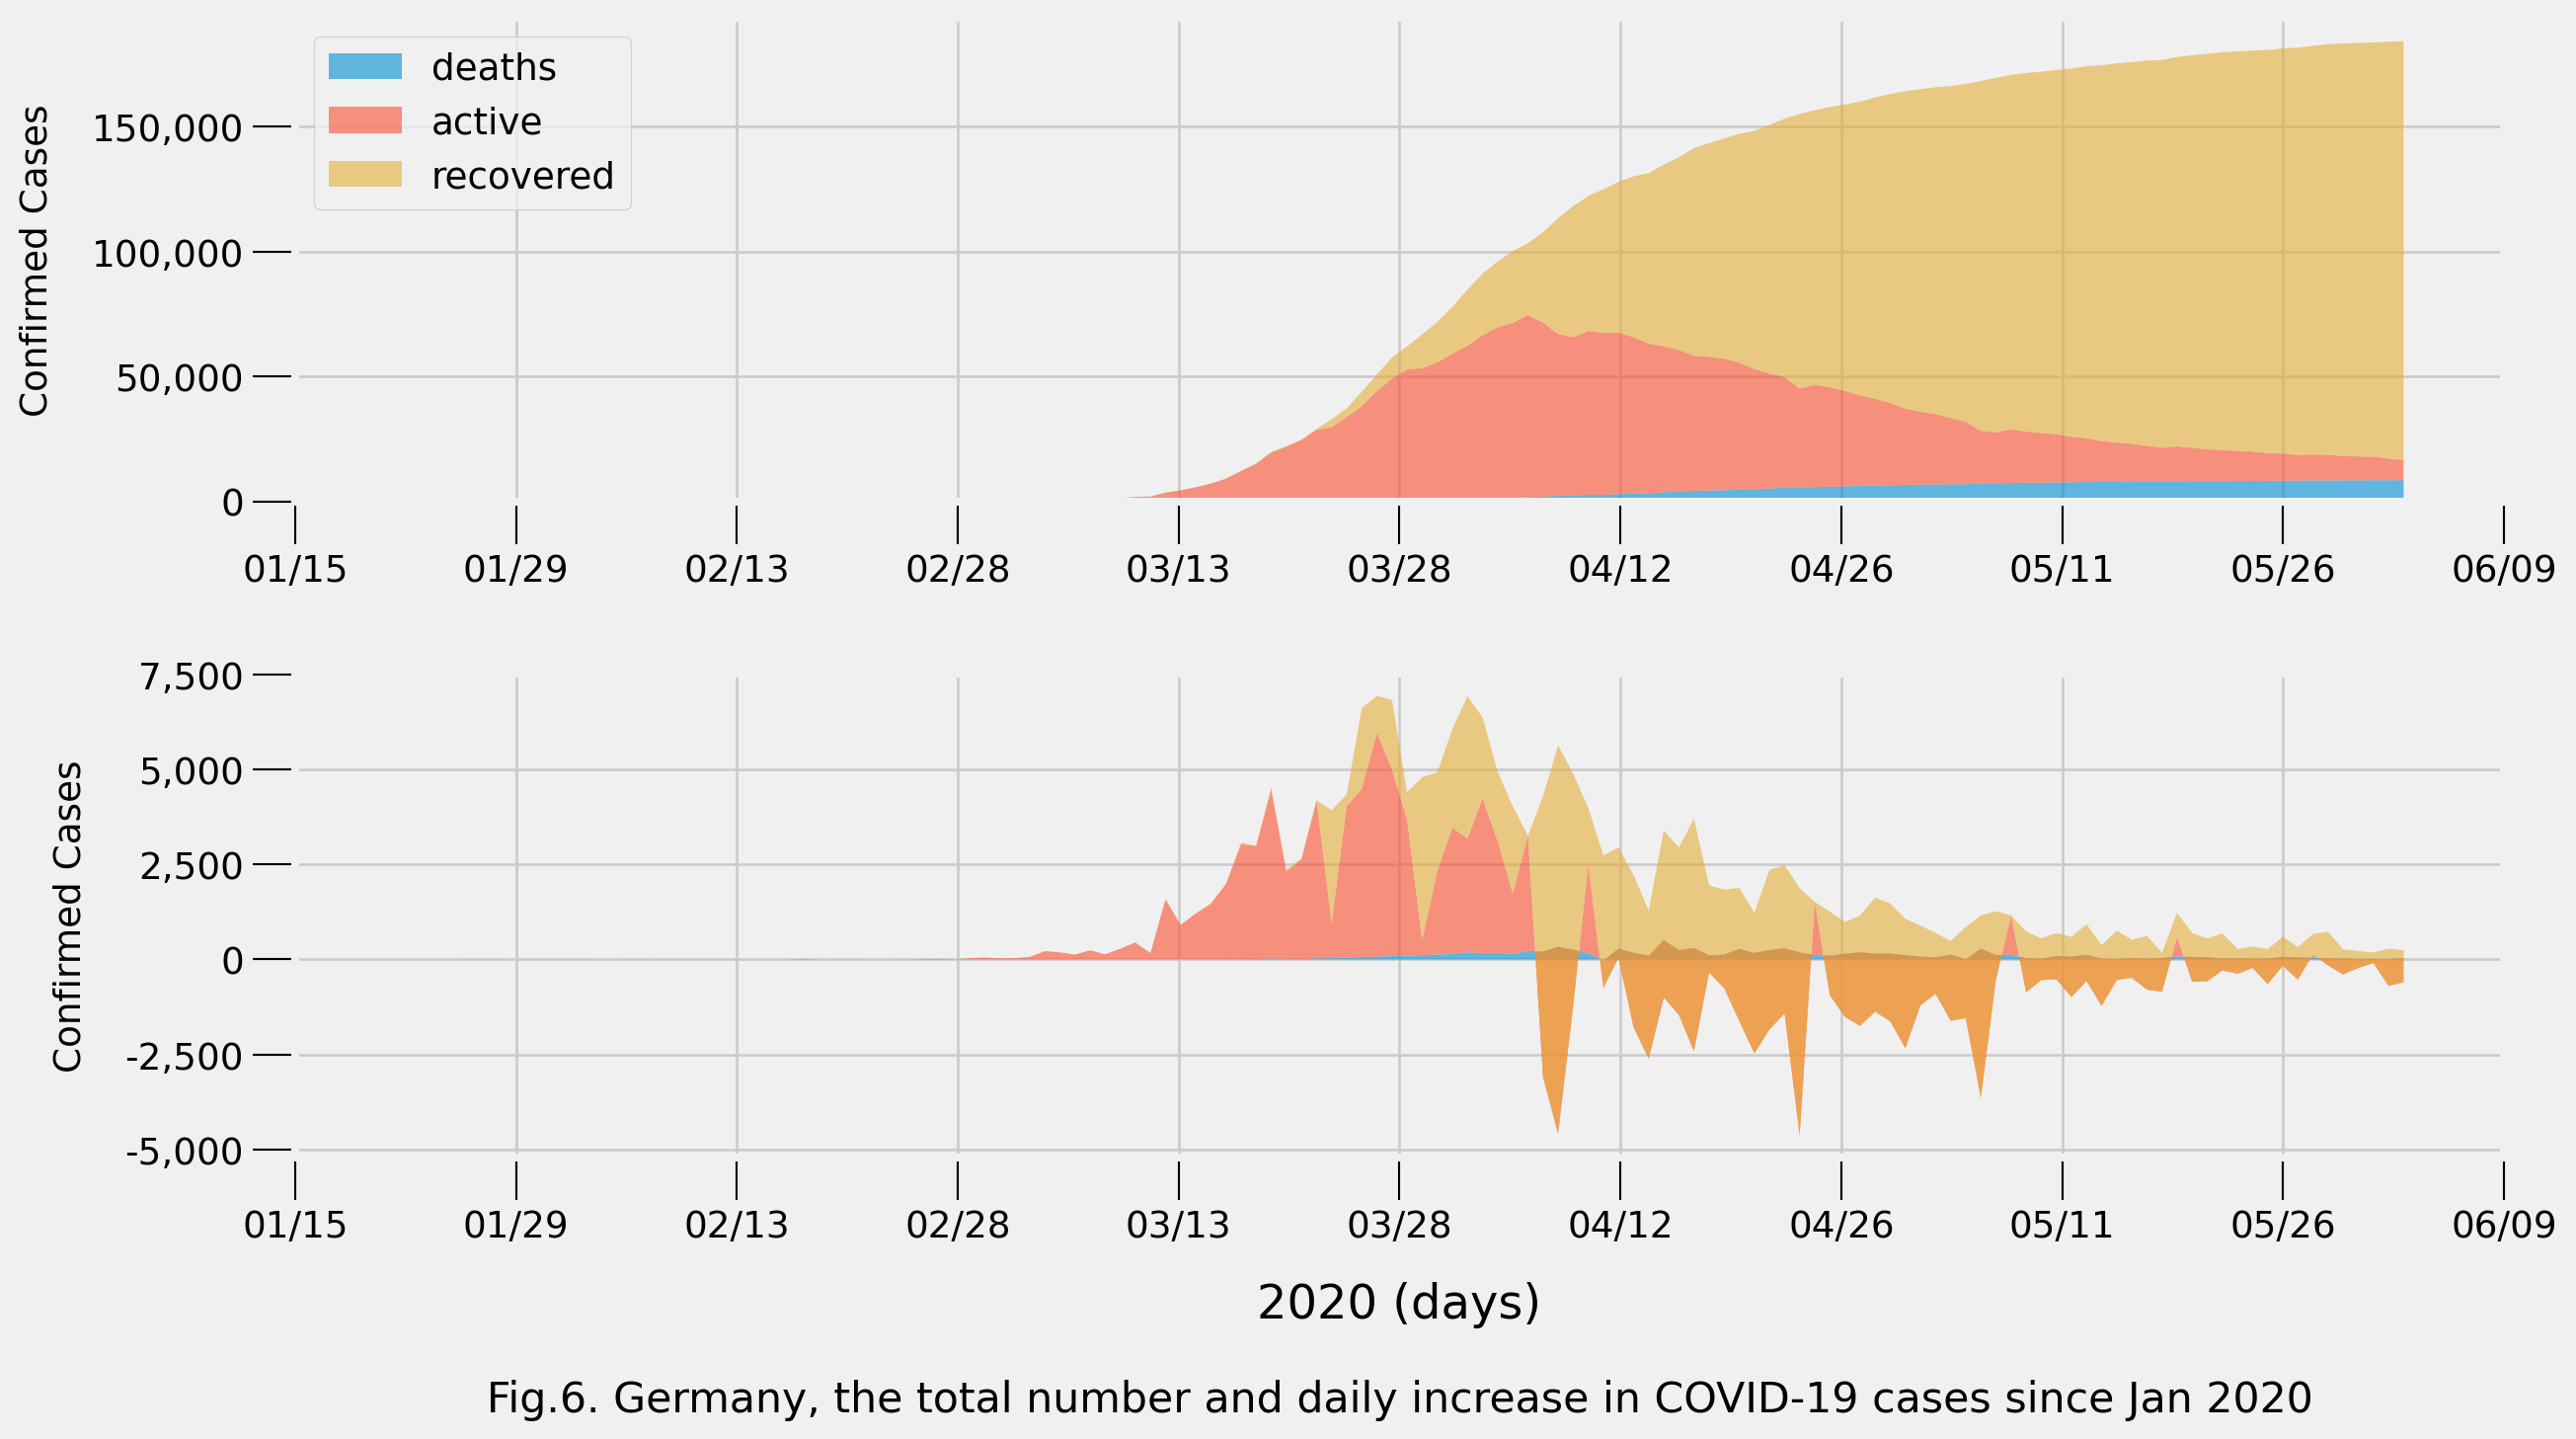

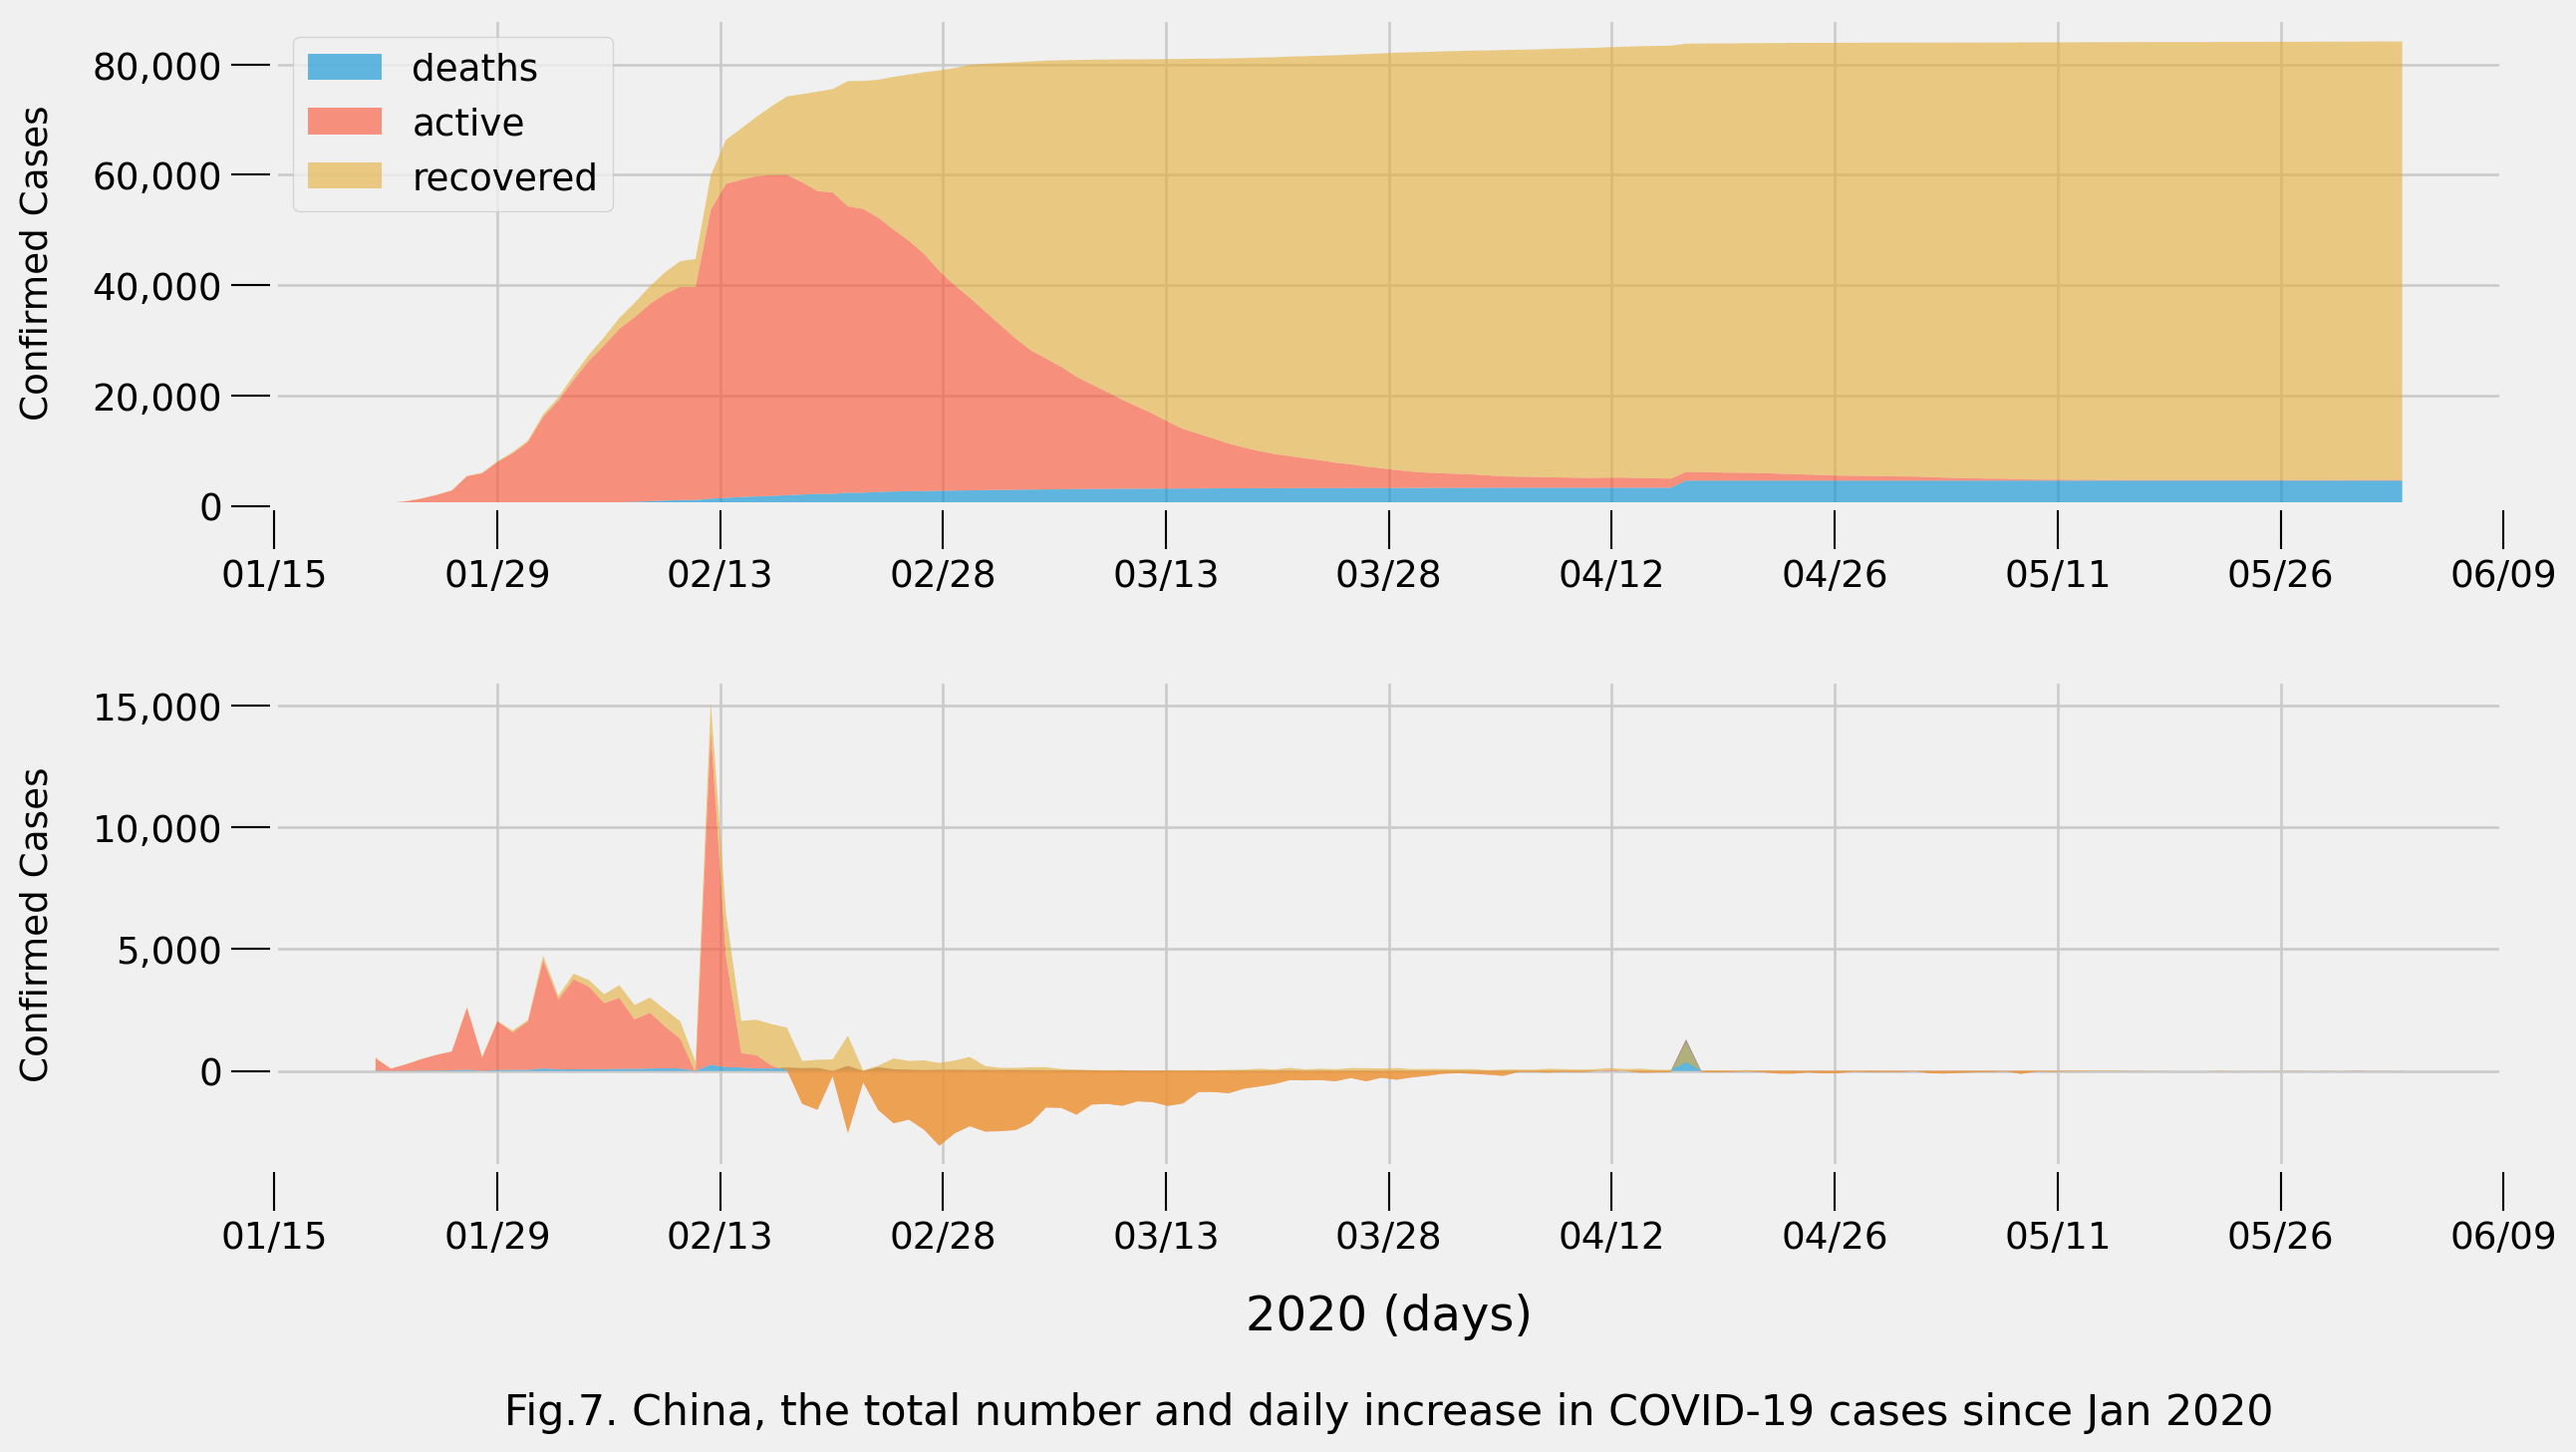

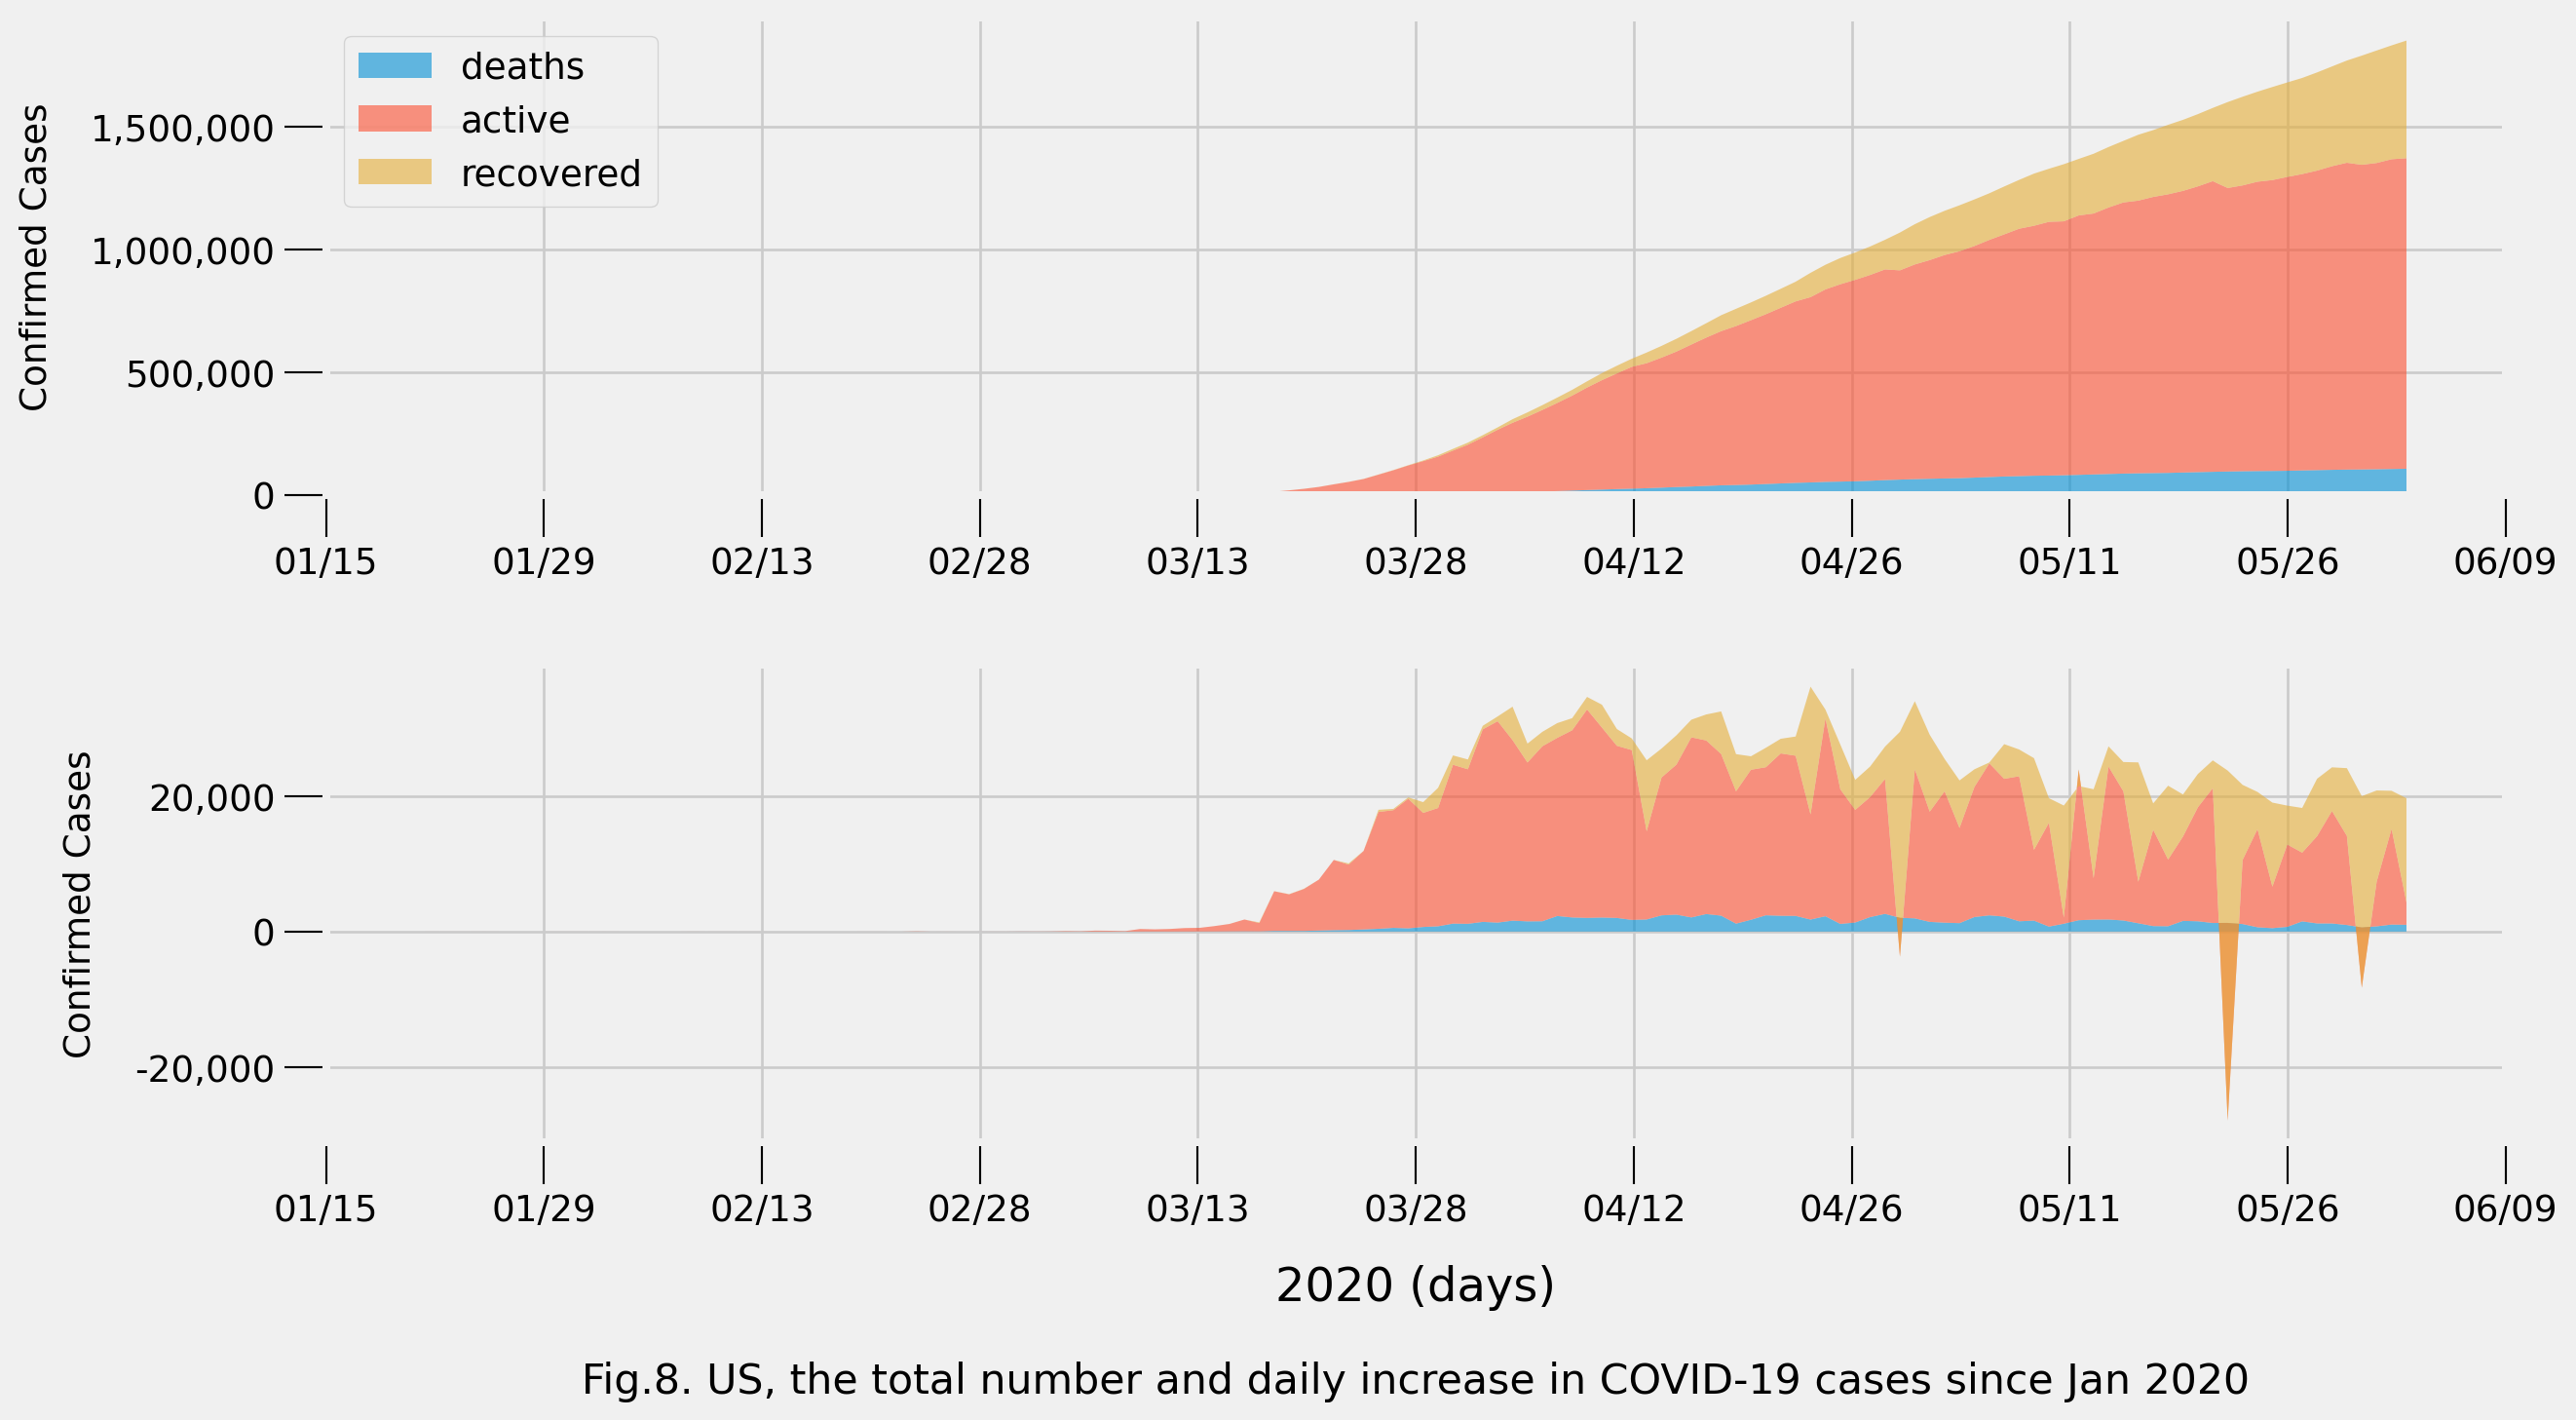

In [13]:
# Graph the country number of confirmed, deaths, and recovered cases
count = 5 # for blog figure captions
for i in ['Italy', 'Germany', 'China', 'US']:
    country_plot(pd.DatetimeIndex(dates), i, count)
    count += 1

The observed or crude case fatality rate is calculated below. The rate is calculated as the number of deaths divided by the number of cases that have actually been confirmed per 100 cases. The point of clarification here is very important because there are a lot of cases that are not confirmed. People who have mild illness might be turned away or not be able to access testing. And we also know that there are a lot of people who are infected but don't develop symptoms, so that means that there's actually a much bigger denominator than what is reflected in this observed case fatality rate.

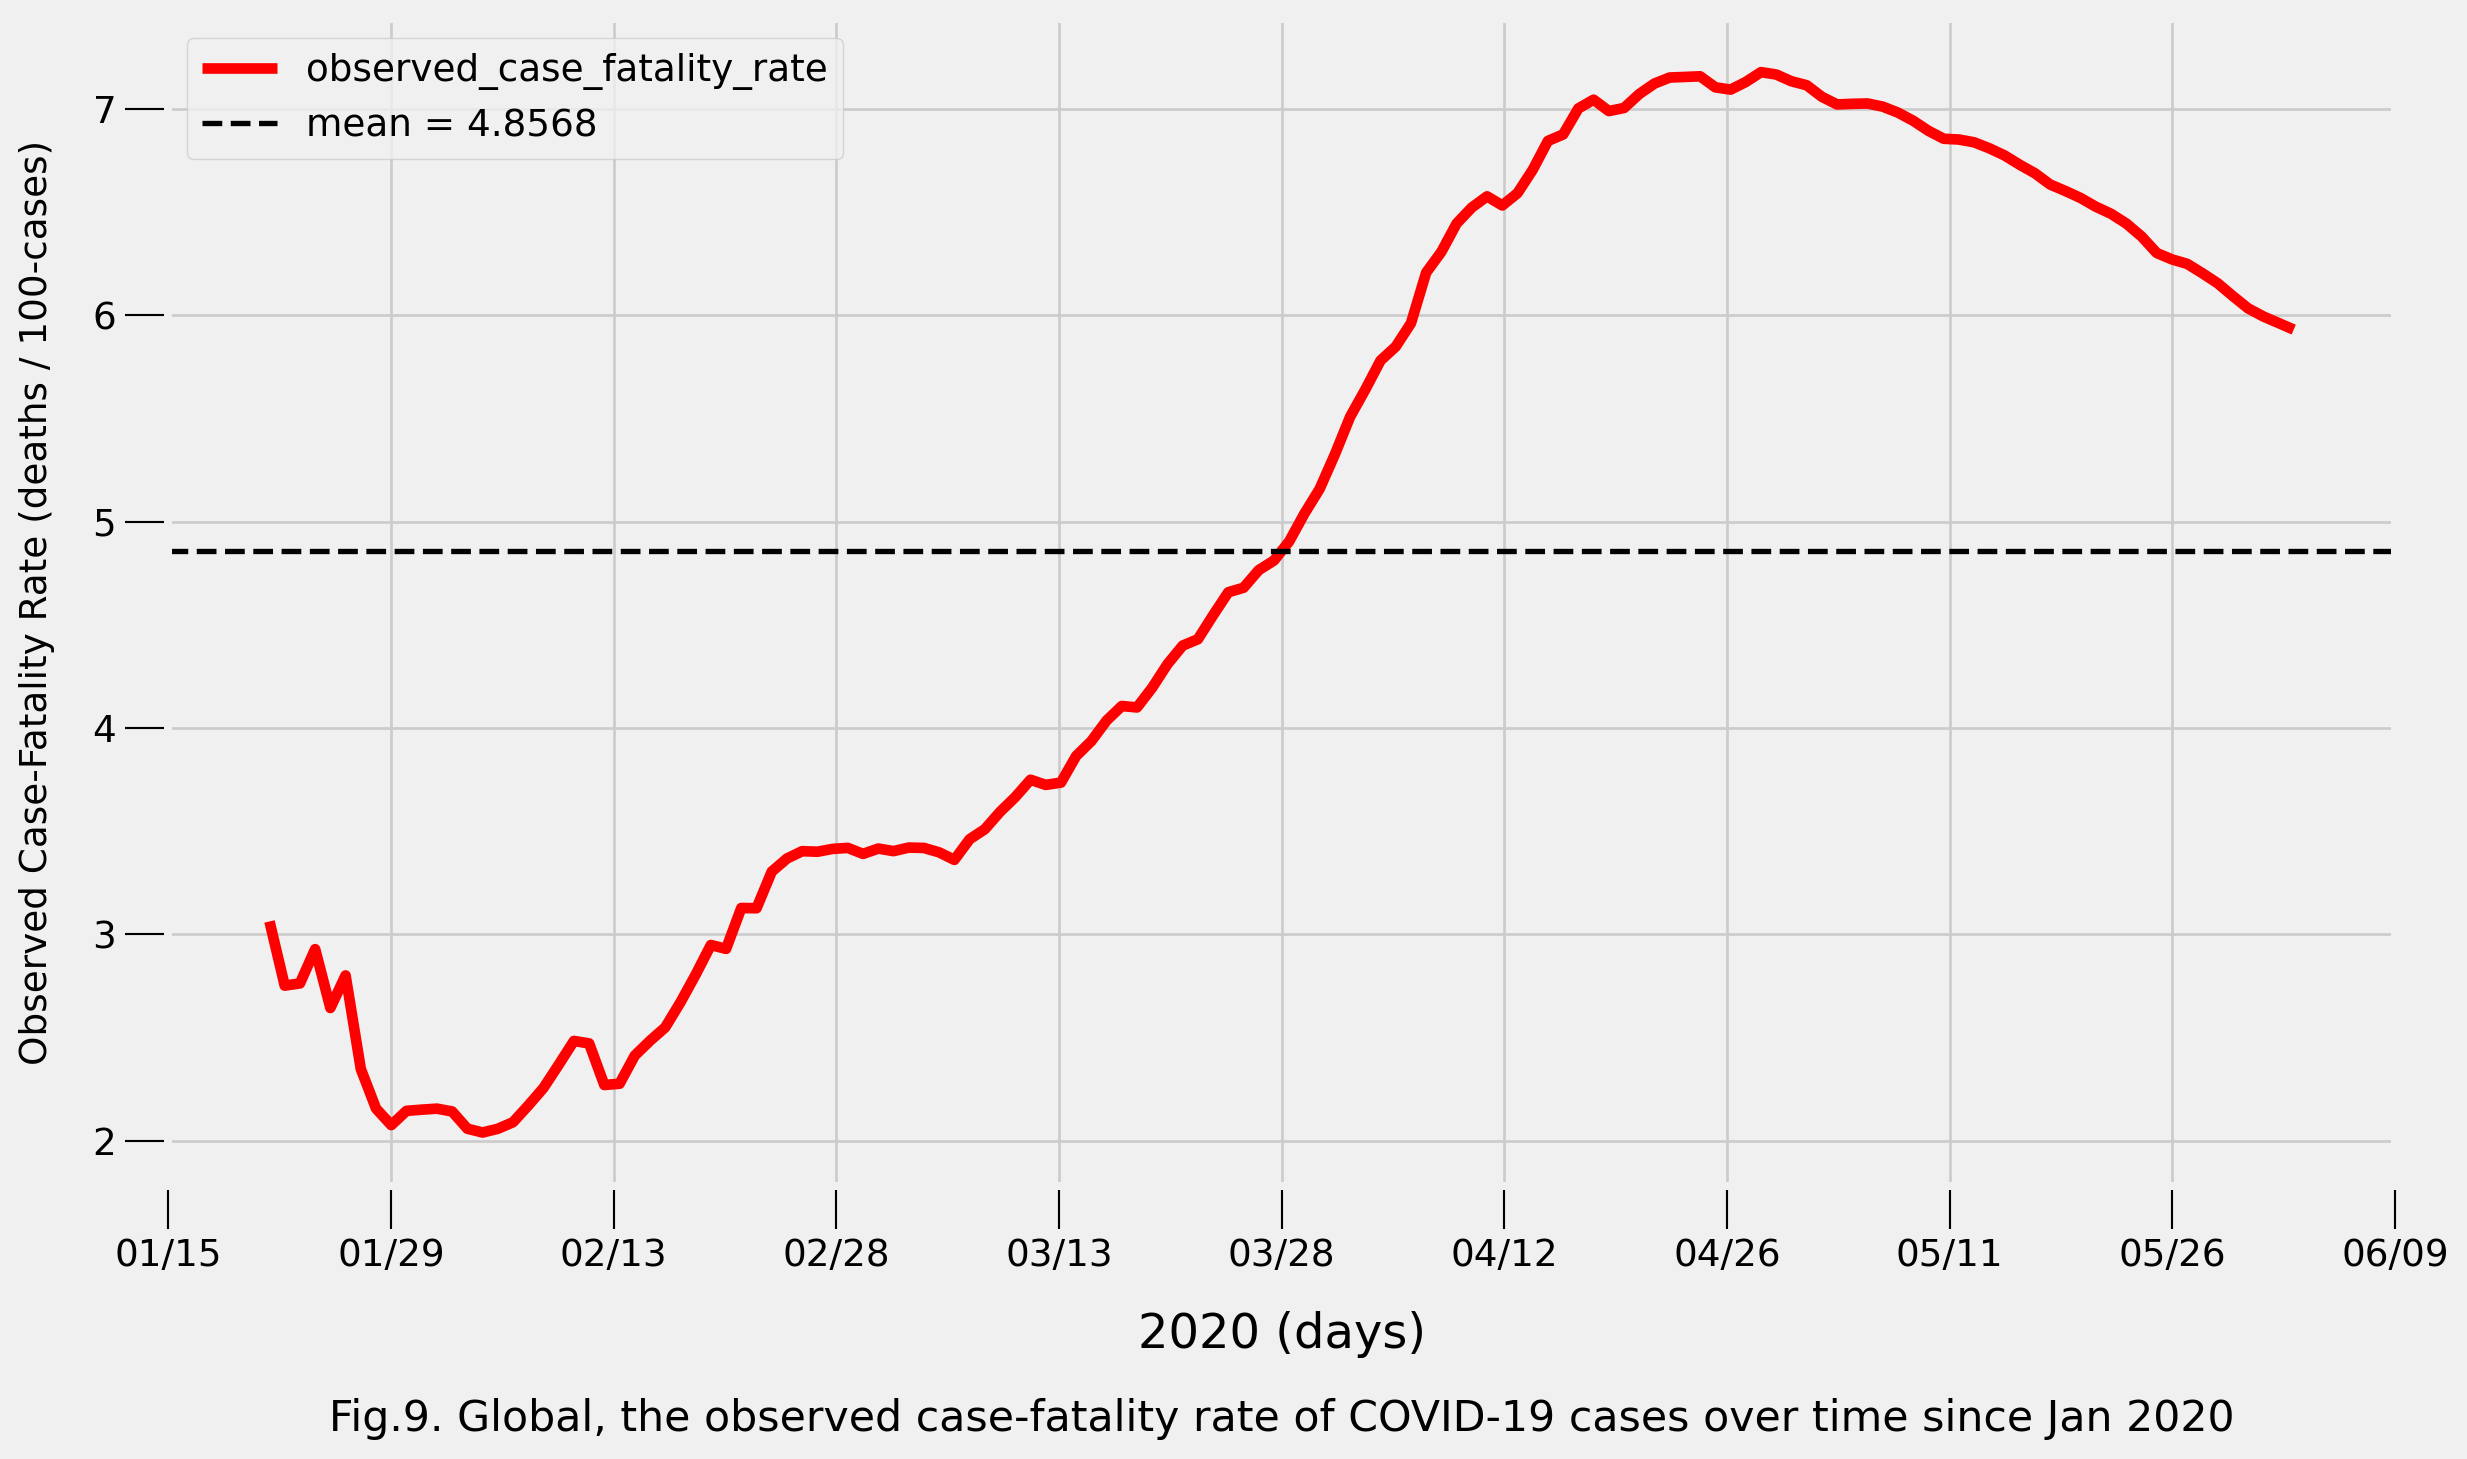

In [14]:
# Graph global infection fatality rate or (deaths) / (deaths + recovered)
mean_fatality_rate = round(np.mean(df_global['fatality_rate']), 4)

fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(df_global.index, df_global['fatality_rate'], color='red', linewidth=4)
ax.axhline(y = mean_fatality_rate, linestyle='--', color='black', linewidth=2)

# Label plot
ax.set_ylabel('Observed Case-Fatality Rate (deaths / 100-cases)', size=14, labelpad=14)
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['observed_case_fatality_rate', 'mean = ' + str(mean_fatality_rate)], prop={'size':14});

# Add caption
fignum = 9
figtxt = " Global, the observed case-fatality rate of COVID-19 cases over time since Jan 2020" 
figcap = 'Fig.' + str(fignum) + '.' + figtxt
ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Display the plot
plt.savefig('fig' + str(fignum) + '-global-observed-fatality-covid19.png', bbox_inches='tight')
plt.show();

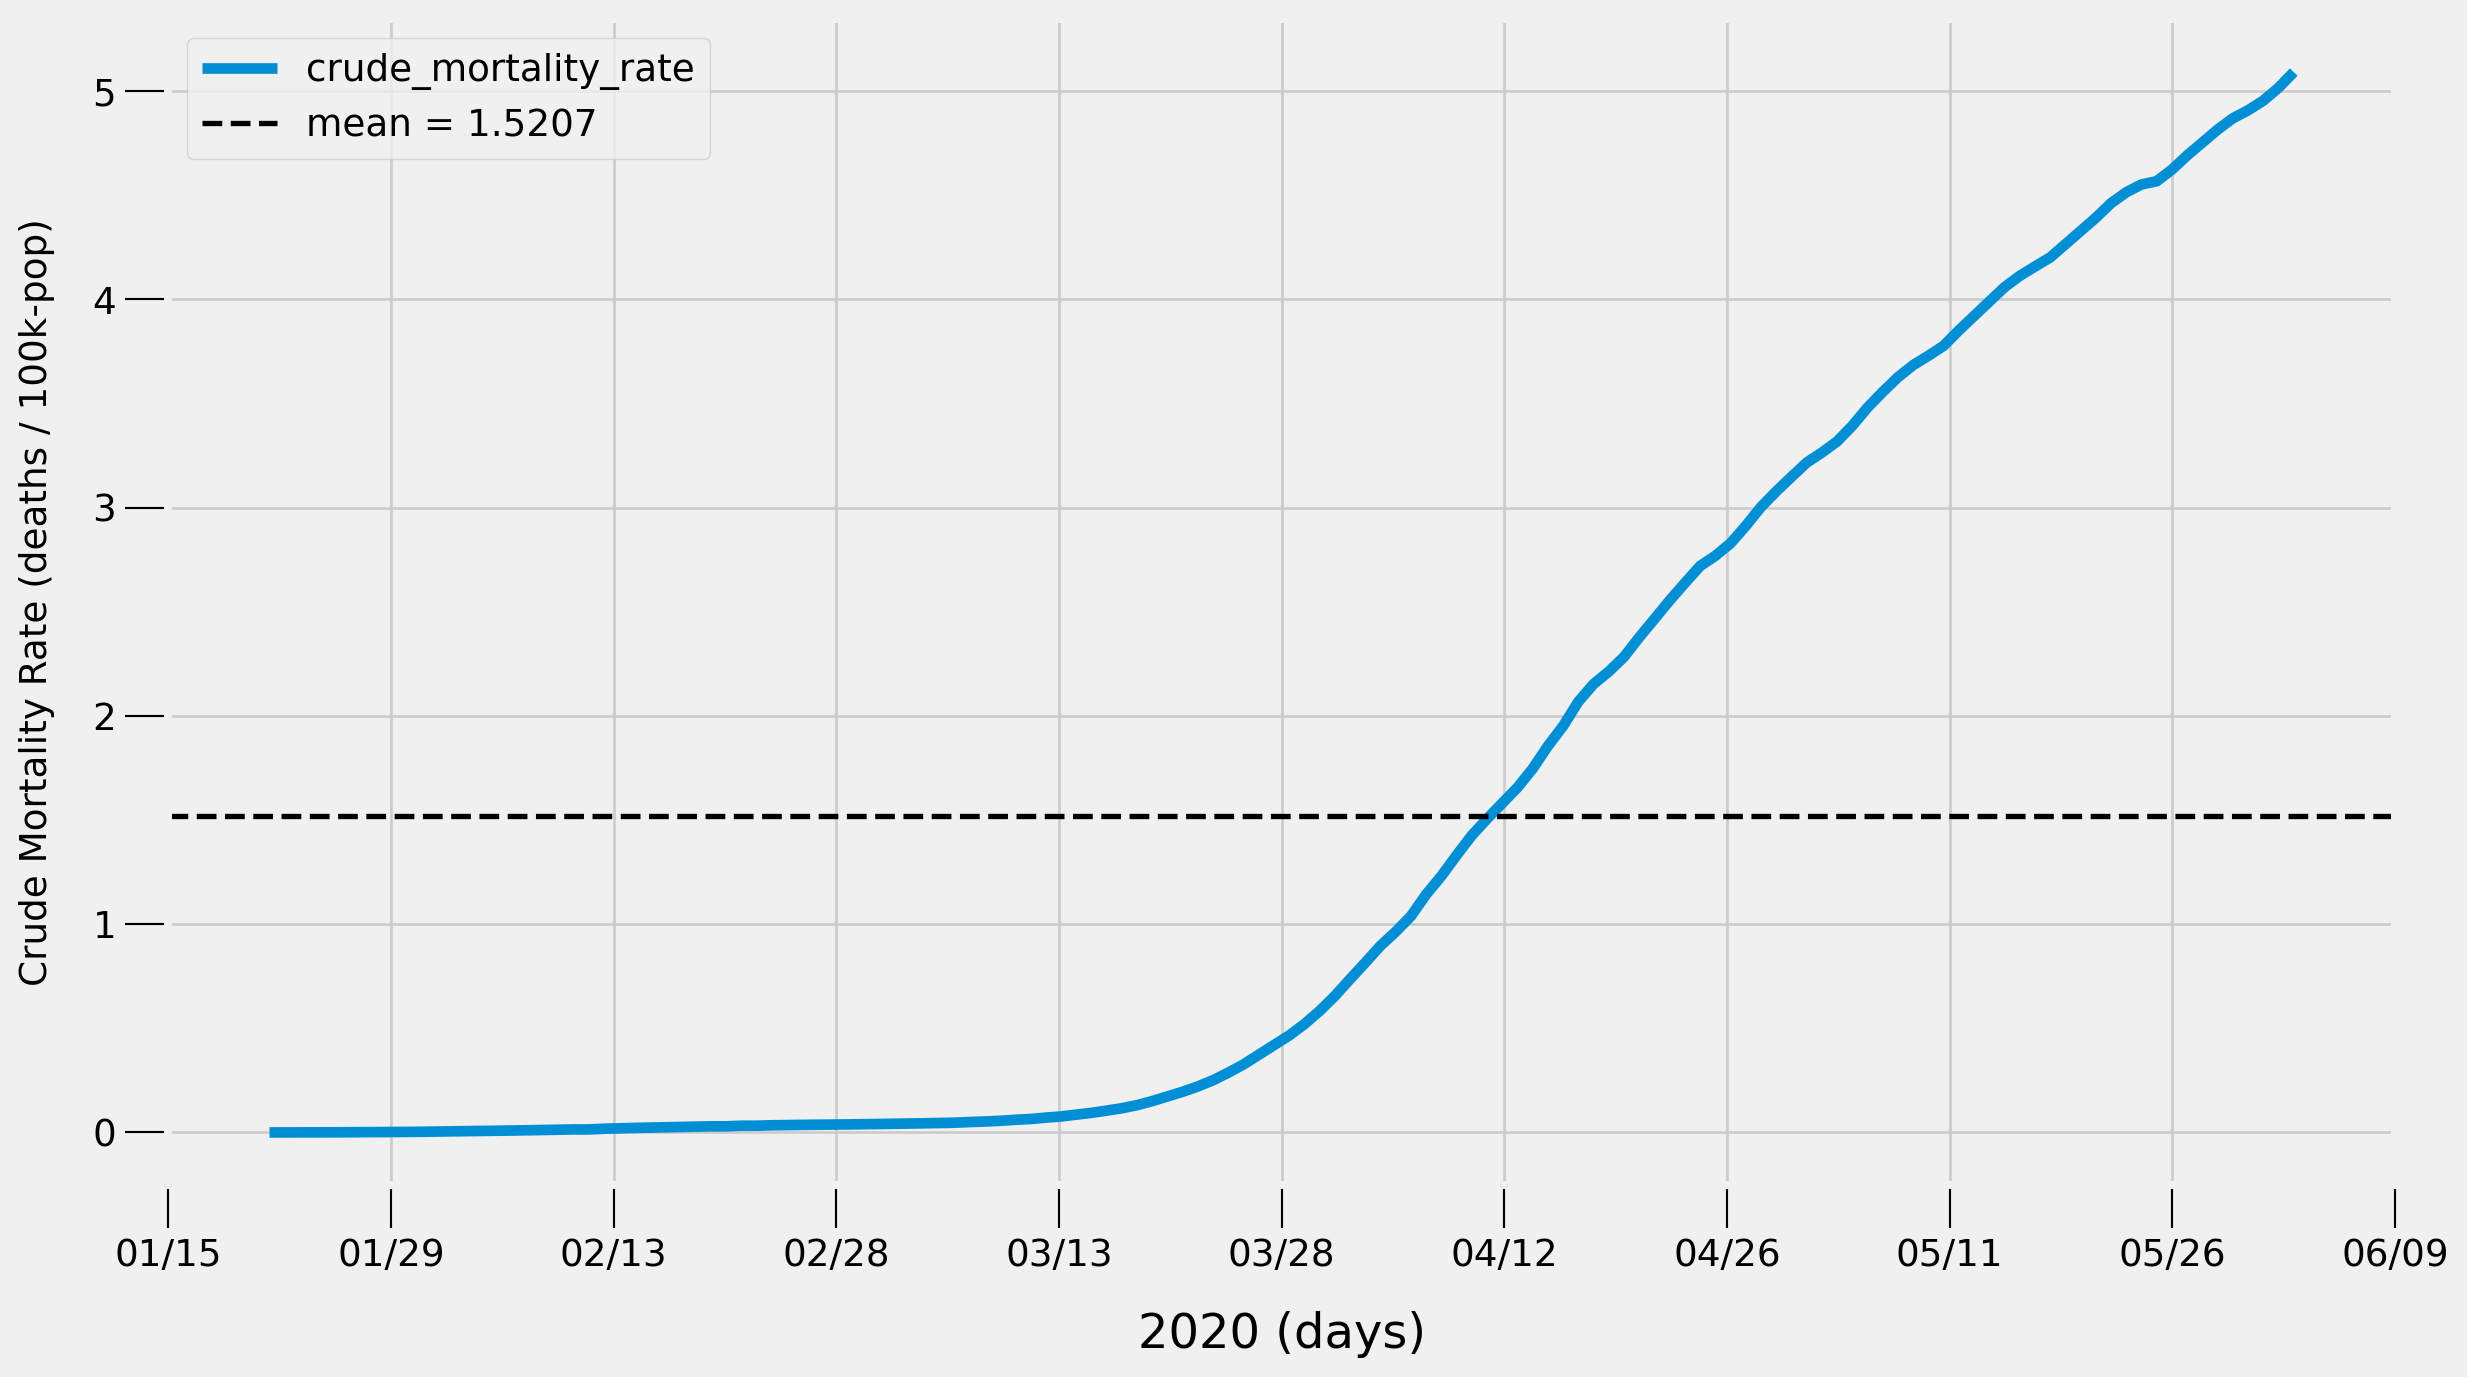

In [15]:
# Graph global mortality rate or (deaths) / (world population)
mean_mortality_rate = round(np.mean(df_global['mortality_rate']),4)

fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(df_global.index, df_global['mortality_rate'], linewidth=4)
ax.axhline(y = mean_mortality_rate, linestyle='--', color='black', linewidth=2)

# Label plot
ax.set_ylabel('Crude Mortality Rate (deaths / 100k-pop)', size=14, labelpad=14)
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['crude_mortality_rate', 'mean = ' + str(mean_mortality_rate)], prop={'size':14});

plt.show();

#### <a class="anchor" id="prediction"></a>
# 3. Forecast Model

In order to more thoroughly explore forecast models for estimating confirmed cases of COVID-19, the project implements, compares, and assesses three supervised learning algorithms: Support Vector Regression, Polynomial Regression, and Bayesian Ridge Polynomial Regression. The models were chosen due to their popularity and suitability for the problem under consideration.

**Support Vector Regression** determines support vectors (points) close to a hyperplane that maximizes the margin between two-point classes obtained from the difference between the target value and a threshold. Support Vector Regression takes into account kernel functions, which calculates the similarity between two observations. The linear kernel is adopted for this project. The main advantages of this model lies in its capacity to capture the predictor non-linearity and then use it to improve the forecasting cases.

**Polynomial Regression** is a form of regression analysis in which the relationship between the independent variable X and the dependent variable y is modeled as an nth degree polynomial in X. Although polynomial regression fits a nonlinear model to the data, as a statistical estimation problem it is linear, in the sense that the regression function is linear for the unknown parameters that are estimated from the data. For this reason, polynomial regression is considered to be a special case of multiple linear regression. 

**Bayesian Ridge Polynomial Regression** approaches linear regression using probability distributions rather than point estimates. The aim of Bayesian Linear Regression is not to find the single "best" value of the model parameters, but rather to determine the posterior distribution for the model parameters. The final estimate will depend on the information that comes from the data and from the priors (e.g. domain knowledge of model parameters). Ridge regression means assuming Normal likelihood and Normal prior for the parameters. 

<a class="anchor" id="model_implementation"></a>
## 3.1 Model Implementation

In order to setup the prediction models, the project uses the sckit-learn train_test_split function to split the time series data and features into training and test sets at 80:20 (with shuffle=False). Three different regression models from the scikit-learn library are used with default and optimized settings on the training data set to compare initial performance metrics.

In [16]:
# Setup train-test split, using the most recent half of data
X_train_cases, X_test_cases, y_train_cases, y_test_cases = (
    train_test_split(days_since_start, global_total['cases'], 
                    test_size=0.2, shuffle=False))

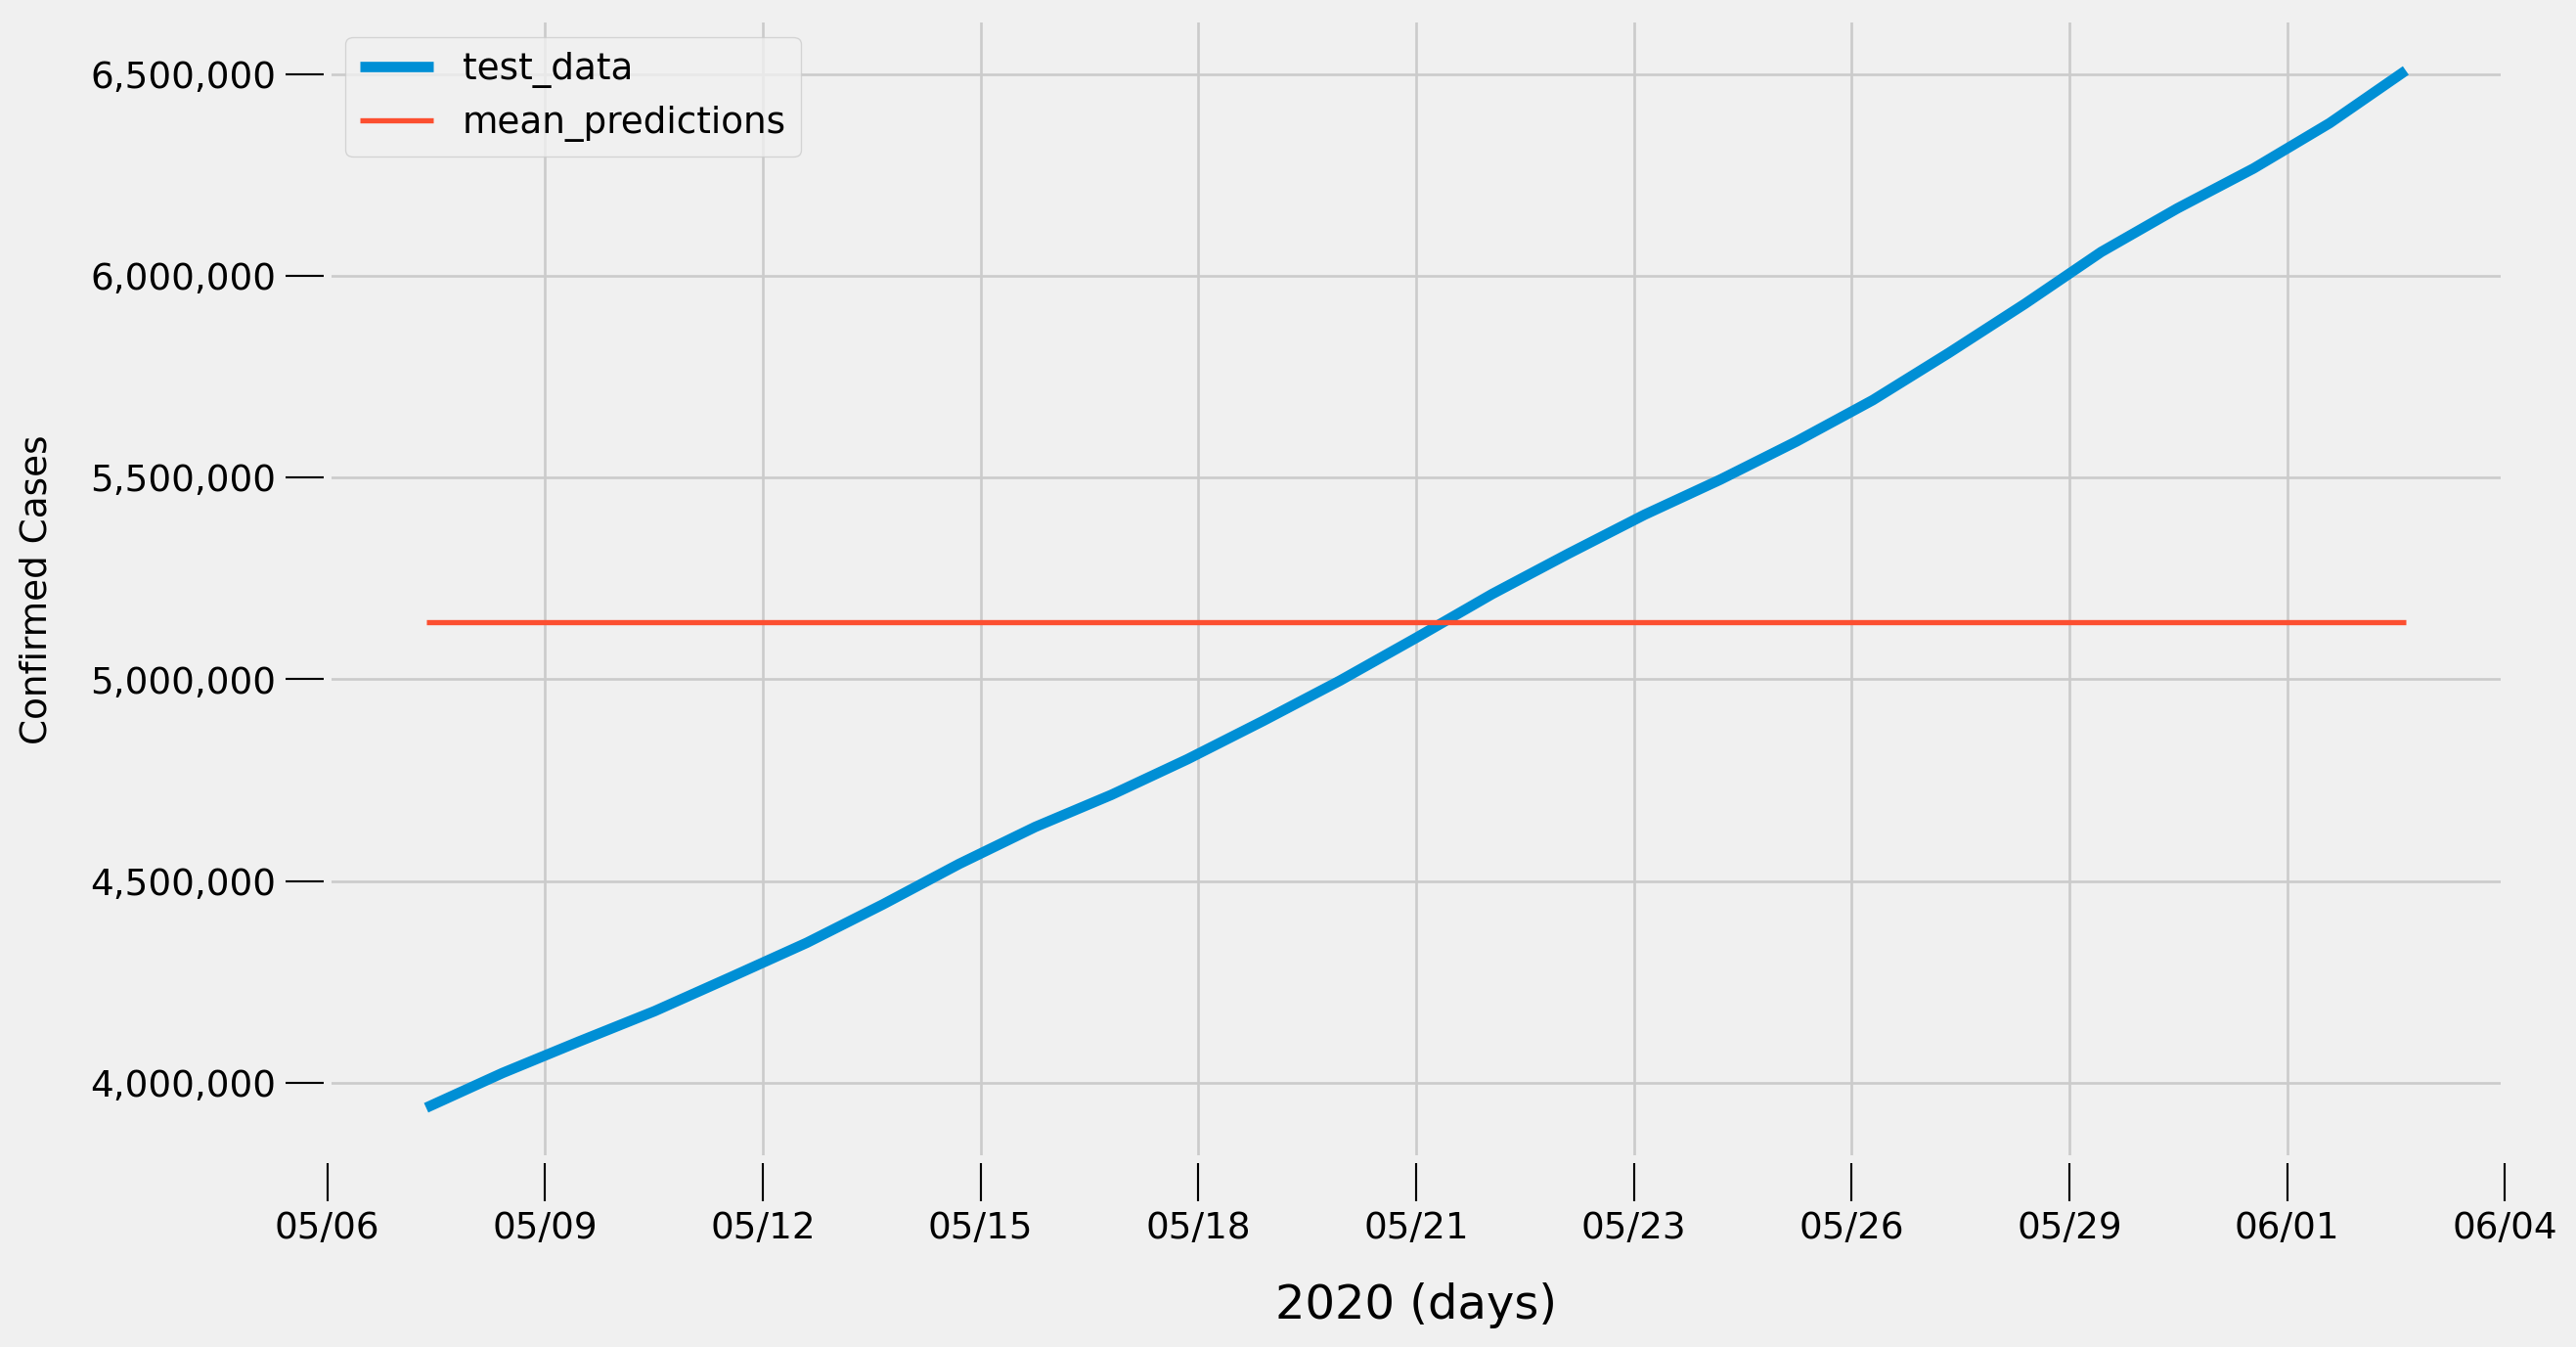

Mean 5140935.1111
MAE: 666112.856
RMSE: 768748.8877


In [17]:
# Check prediction error against naive model 
mean_test_pred = [np.mean(y_test_cases)] * len(y_test_cases)

fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), y_test_cases, linewidth=4)
ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), mean_test_pred, linewidth=2)

# Label plot
ax.set_ylabel('Confirmed Cases', size=14, labelpad=14)
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['test_data', 'mean_predictions'], prop={'size':14});

plt.show()

print('Mean', round(np.mean(y_test_cases), 4))
print('MAE:', round(mean_absolute_error(mean_test_pred, y_test_cases), 4))
print('RMSE:', round(np.sqrt(mean_squared_error(mean_test_pred, y_test_cases)), 4))

In [ ]:
# Tune model parameters for Support Vector Regression
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
degree = [3, 4, 5]

svm_grid = {'C': C, 'gamma': gamma, 'epsilon': epsilon, 
            'shrinking': shrinking, 'degree': degree}

svm = SVR(kernel='poly')
svm_search = RandomizedSearchCV(svm, svm_grid, 
                                scoring='neg_mean_squared_error',
                                cv=3, return_train_score=True,
                                n_jobs=-1, n_iter=30, verbose=1)

svm_search.fit(X_train_cases, y_train_cases)

svm_search.best_params_

svm_cases = svm_search.best_estimator_

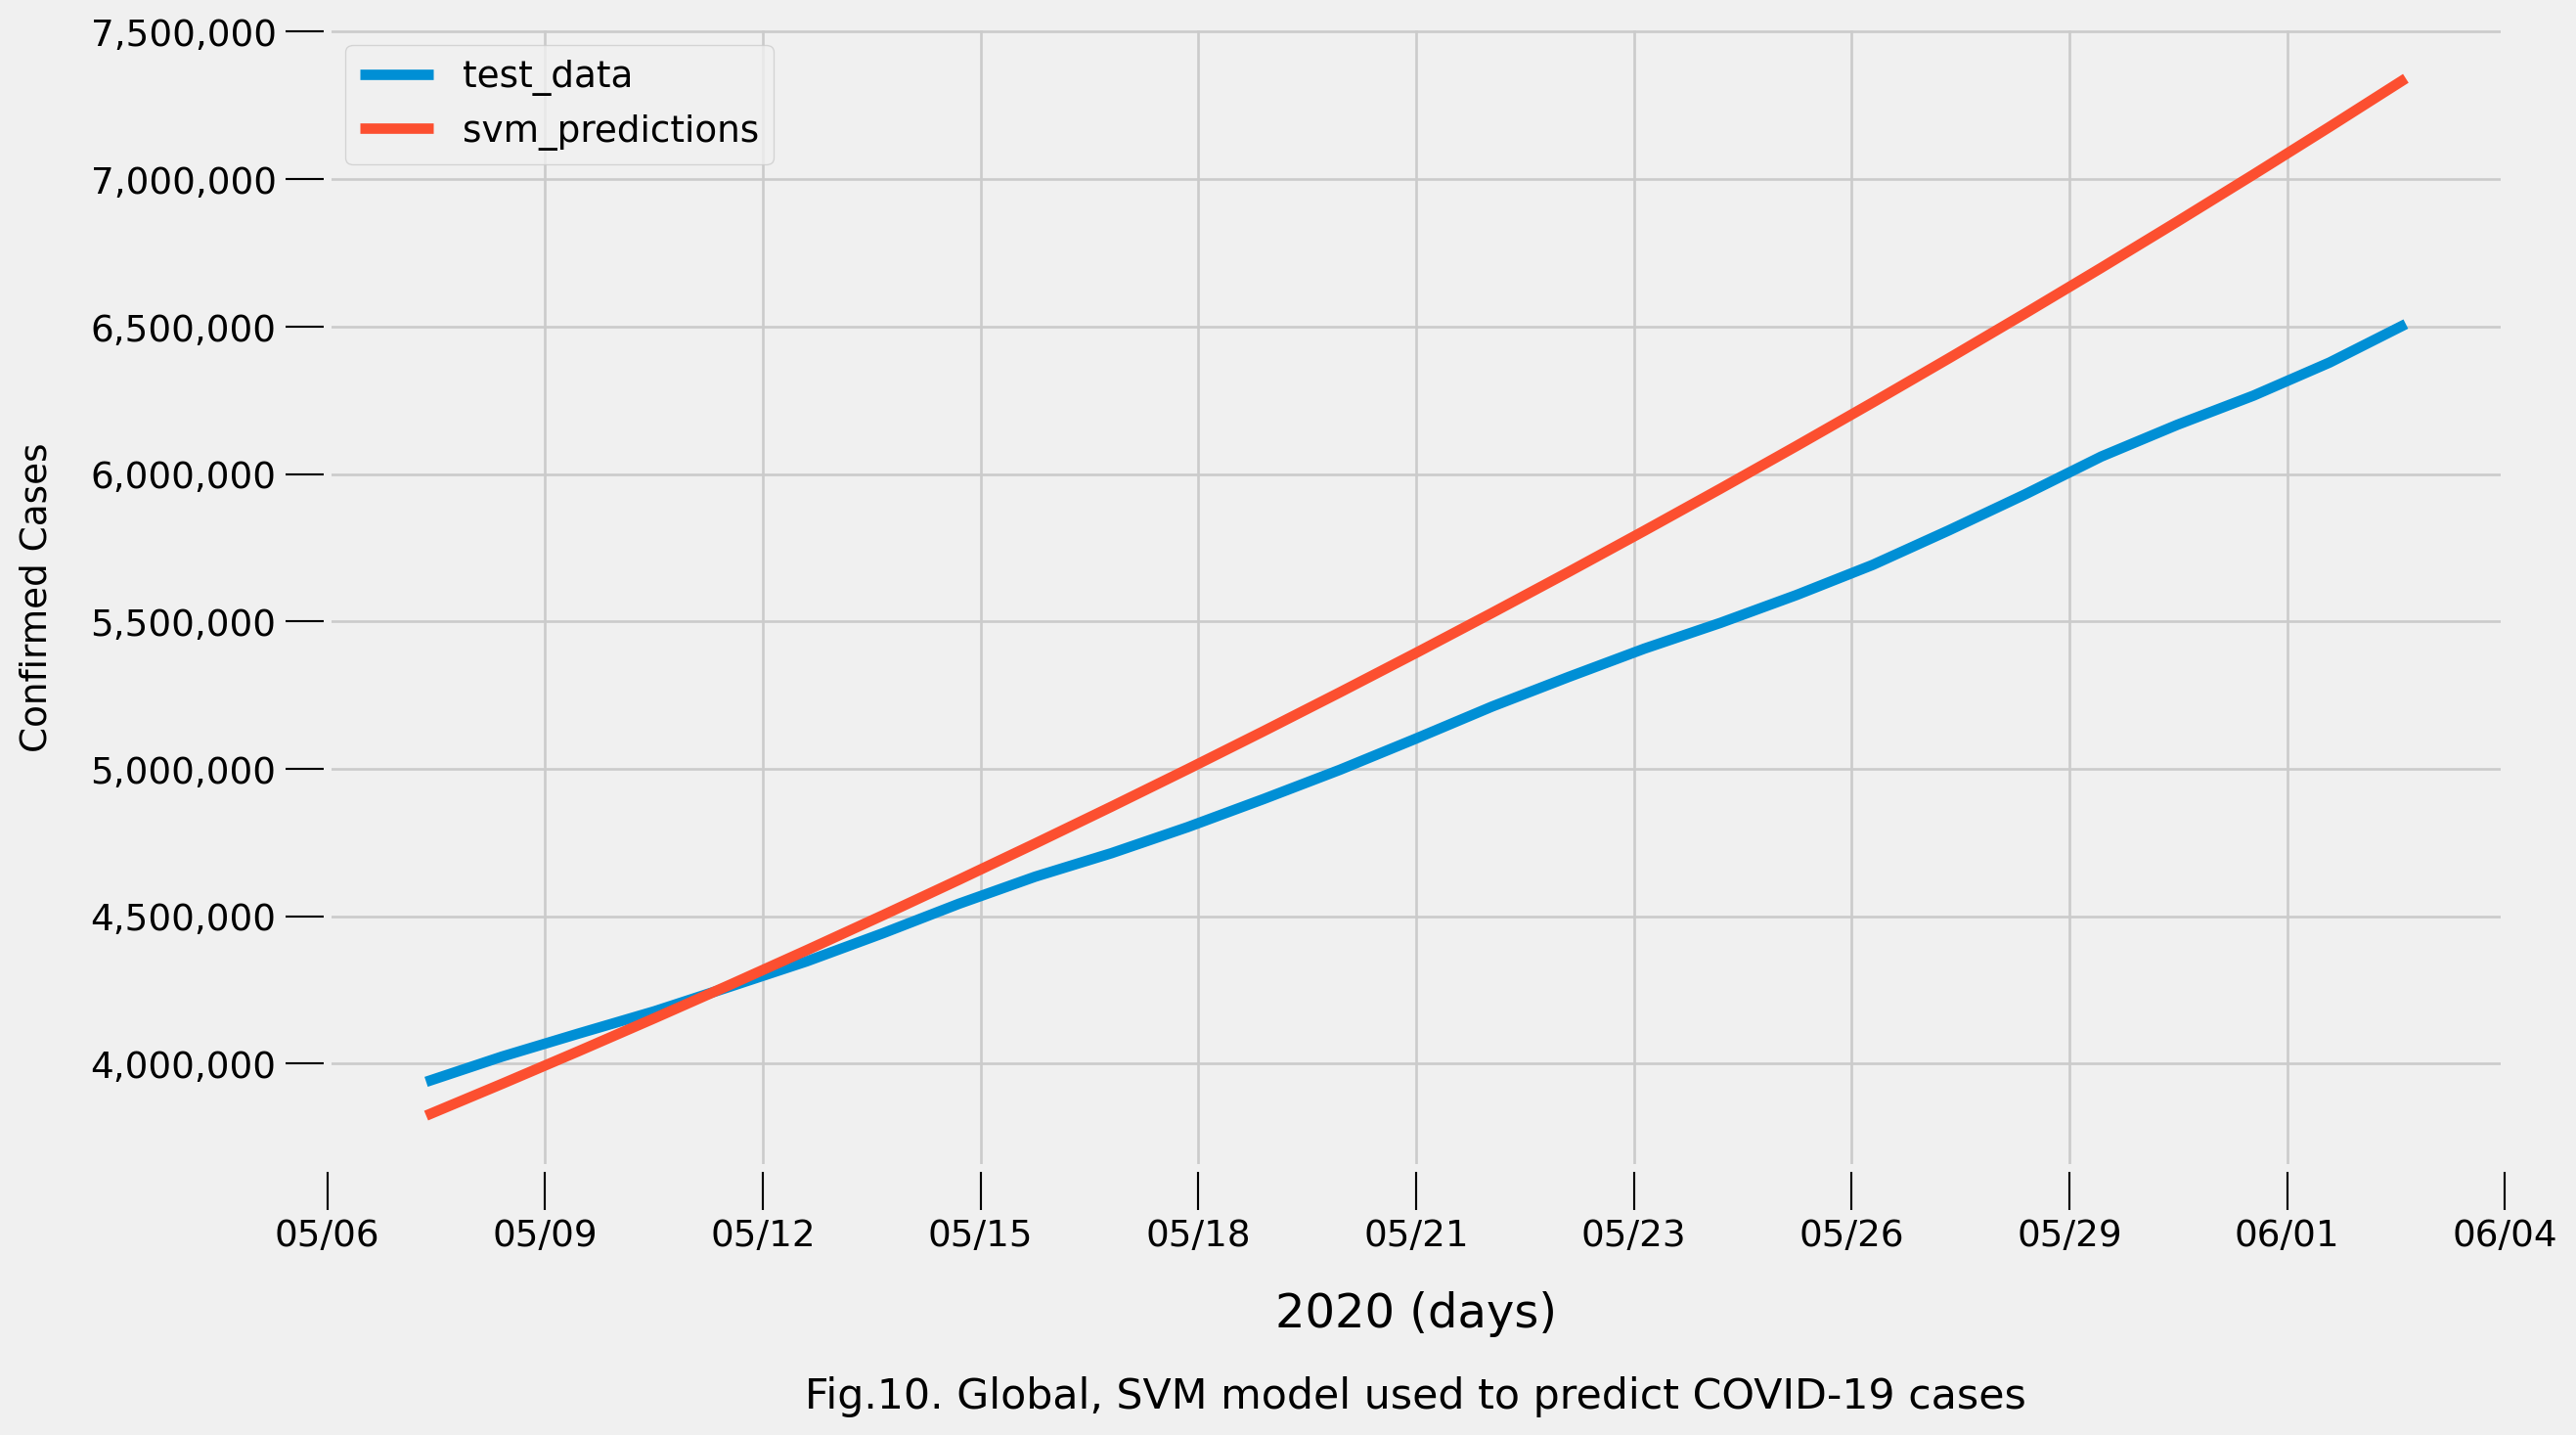

MAE: 341558.6298
RMSE: 429133.8609


In [18]:
# Create optimized instance of SVR
svm_cases = SVR(shrinking=True, kernel='poly', gamma=1, 
                epsilon=1, degree=3, C=10)
svm_cases.fit(X_train_cases, y_train_cases)
svm_pred = svm_cases.predict(future_forecast)

# Check prediction error
svm_test_pred = svm_cases.predict(X_test_cases)

fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), y_test_cases, linewidth=4)
ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), svm_test_pred, linewidth=4)

# Label plot
ax.set_ylabel('Confirmed Cases', size=14, labelpad=14)
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['test_data', 'svm_predictions'], prop={'size':14});

# Add caption
fignum = 10
figtxt = " Global, SVM model used to predict COVID-19 cases" 
figcap = 'Fig.' + str(fignum) + '.' + figtxt
ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Display the plot
plt.savefig('fig' + str(fignum) + '-model-svm-covid19.png', bbox_inches='tight')
plt.show()

print('MAE:', round(mean_absolute_error(svm_test_pred, y_test_cases), 4))
print('RMSE:', round(np.sqrt(mean_squared_error(svm_test_pred, y_test_cases)), 4))

To convert the original features into their higher order terms, the project uses the PolynomialFeatures class provided by scikit-learn. If we try to fit a Polynomial Regression (degree=2) or a Bayesian Ridge Polynomial Regression (degree=2) to the dataset, we can see that both align better with the test data points than the Support Vector Regression model.

In [19]:
# Create a function to find the best polynomial model for the data
def create_polynomial_regression_model(degree, X_train, y_train, X_test, y_test):
    """
    Creates a polynomial regression model for the given degree
    """
    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)
    
    print("\nDegree = {}".format(degree))
    
    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    
    print("\nThe model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))

# Evaluate polynomial models through degree=10
for i in range(2,7):
    create_polynomial_regression_model(i, X_train_cases, y_train_cases, X_test_cases, y_test_cases)


Degree = 2
The model performance for the training set
-------------------------------------------
RMSE of training set is 142917.00004397484
R2 score of training set is 0.9854876418960323

The model performance for the test set
-------------------------------------------
RMSE of test set is 386801.2789179926
R2 score of test set is 0.7468331710174557

Degree = 3
The model performance for the training set
-------------------------------------------
RMSE of training set is 115707.9272398488
R2 score of training set is 0.9904874614174924

The model performance for the test set
-------------------------------------------
RMSE of test set is 1179074.5542493293
R2 score of test set is -1.3524127955684841

Degree = 4
The model performance for the training set
-------------------------------------------
RMSE of training set is 61446.14731257614
R2 score of training set is 0.9973173777704655

The model performance for the test set
-------------------------------------------
RMSE of test set is

In [20]:
# Transform the data for polynomial regression
poly = PolynomialFeatures(degree=2)
poly_X_train_cases = poly.fit_transform(X_train_cases)
poly_X_test_cases = poly.fit_transform(X_test_cases)
poly_future_forecast = poly.fit_transform(future_forecast)

# Transform the data for bayesian polynomial regression
bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_cases = bayesian_poly.fit_transform(X_train_cases)
bayesian_poly_X_test_cases = bayesian_poly.fit_transform(X_test_cases)
bayesian_poly_future_forecast = bayesian_poly.fit_transform(future_forecast)

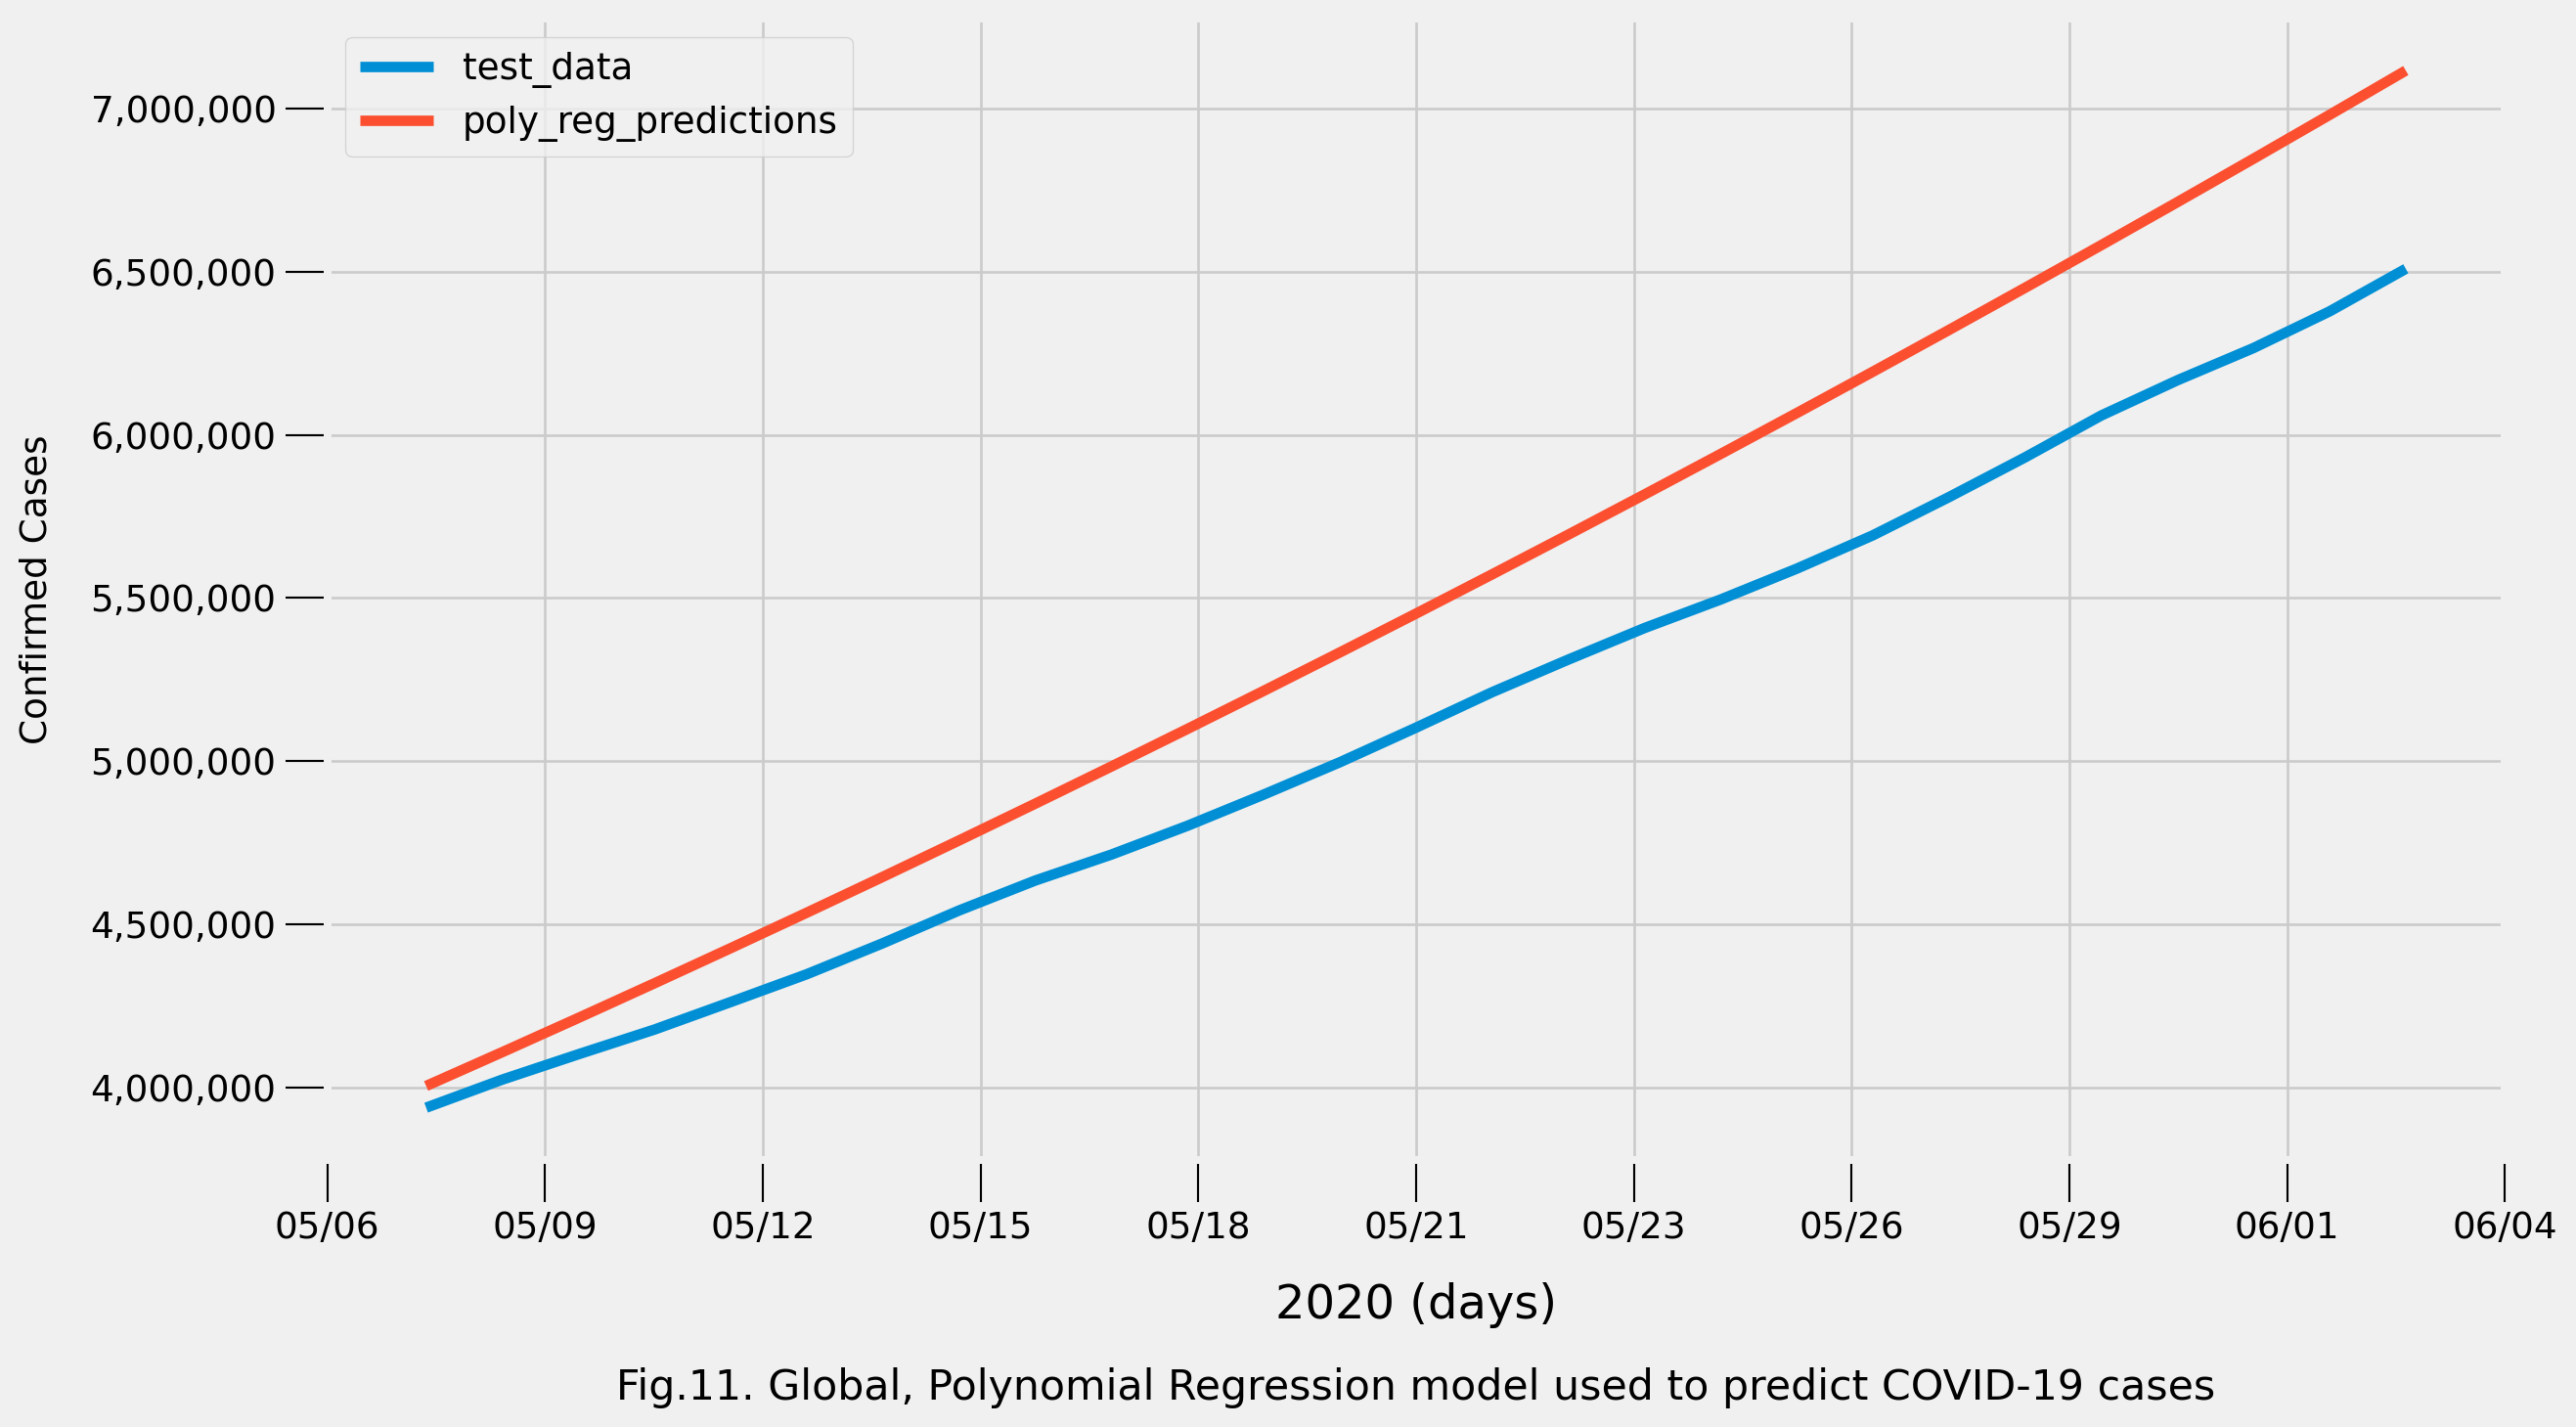

MAE: 349921.9923
RMSE: 386801.2789
[322727.85597382 -34187.70696643    641.09451501]


In [21]:
# Model default parameters for Polynomial Regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_cases, y_train_cases)
linear_pred = linear_model.predict(poly_future_forecast)

# Check prediction error
test_linear_pred = linear_model.predict(poly_X_test_cases)

fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), y_test_cases, linewidth=4)
ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), test_linear_pred, linewidth=4)

# Label plot
ax.set_ylabel('Confirmed Cases', size=14, labelpad=14)
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['test_data', 'poly_reg_predictions'], prop={'size':14});

# Add caption
fignum = 11
figtxt = " Global, Polynomial Regression model used to predict COVID-19 cases" 
figcap = 'Fig.' + str(fignum) + '.' + figtxt
ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Display the plot
plt.savefig('fig' + str(fignum) + '-model-polynomial-regression-covid19.png', bbox_inches='tight')
plt.show()

print('MAE:', round(mean_absolute_error(test_linear_pred, y_test_cases), 4))
print('RMSE:', round(np.sqrt(mean_squared_error(test_linear_pred, y_test_cases)), 4))
print(linear_model.coef_)

In [ ]:
# Tune Bayesian Ridge Polynomial Regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2': alpha_2,
                 'lambda_1': lambda_1, 'lambda_2': lambda_2, 
                 'normalize': normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, 
                                     scoring='neg_mean_squared_error',
                                     cv=3, return_train_score=True,
                                     n_jobs=-1, n_iter=40, verbose=1)

bayesian_search.fit(bayesian_poly_X_train_cases, y_train_cases)

bayesian_search.best_params_

bayesian_cases = bayesian_search.best_estimator_

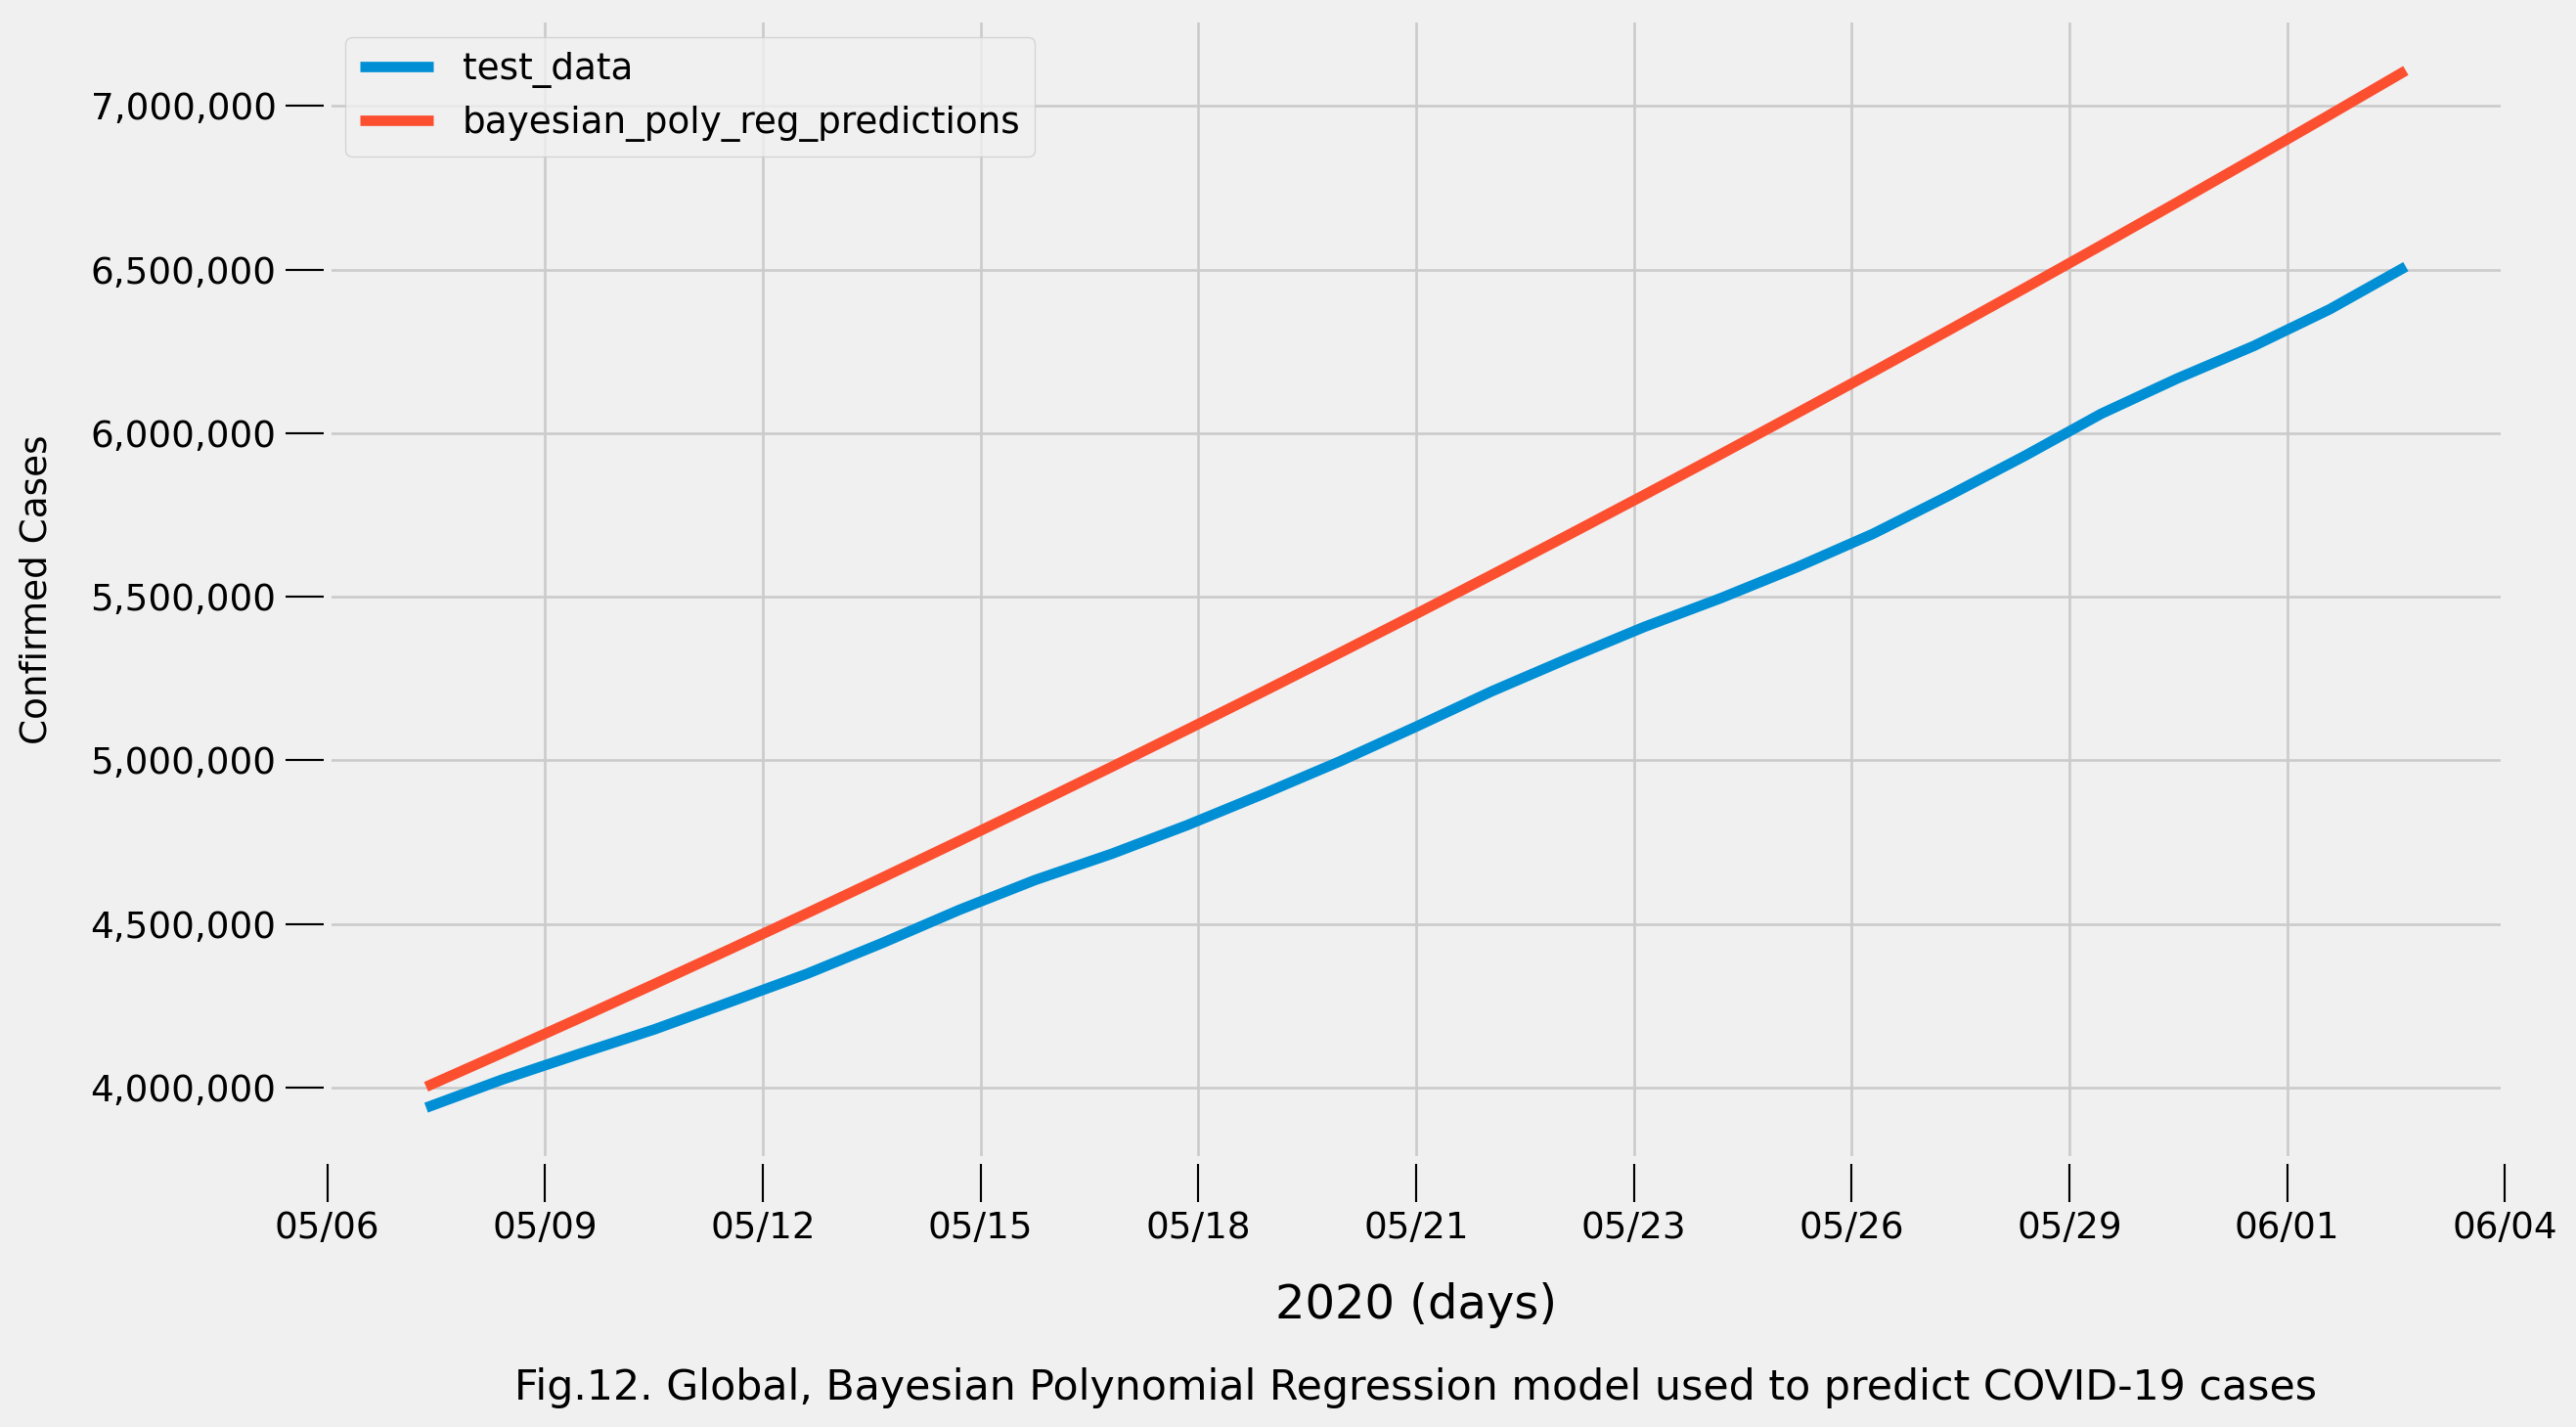

MAE: 344743.5406
RMSE: 381419.9466


In [22]:
# Create optimized instance of bayesian poly regression model
bayesian_cases = BayesianRidge(tol=1e-05, normalize=False, 
                               lambda_2=1e-07, lambda_1=0.001, 
                               alpha_2=0.0001, alpha_1=1e-07)

bayesian_cases.fit(bayesian_poly_X_train_cases, y_train_cases)

bayesian_pred = bayesian_cases.predict(bayesian_poly_future_forecast)

# Check prediction error
test_bayesian_pred = bayesian_cases.predict(bayesian_poly_X_test_cases)

fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), y_test_cases, linewidth=4)
ax.plot(actual_dates[len(y_train_cases):].reshape(-1,1), test_bayesian_pred, linewidth=4)

# Label plot
ax.set_ylabel('Confirmed Cases', size=14, labelpad=14)
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['test_data', 'bayesian_poly_reg_predictions'], prop={'size':14});

# Add caption
fignum = 12
figtxt = " Global, Bayesian Polynomial Regression model used to predict COVID-19 cases" 
figcap = 'Fig.' + str(fignum) + '.' + figtxt
ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Display the plot
plt.savefig('fig' + str(fignum) + '-model-bayesian-polynomial-ridge-covid19.png', bbox_inches='tight')
plt.show()

print('MAE:', round(mean_absolute_error(test_bayesian_pred, y_test_cases), 4))
print('RMSE:', round(np.sqrt(mean_squared_error(test_bayesian_pred, y_test_cases)), 4))

<a class="anchor" id="results"></a>
# 4. Results

All machine learning models performed better than the naive forecast model of the mean for both MAE and RMSE. When we tried to fit a polynomial curve (degree=2) or a Bayesian Ridge Regression (degree=2) to the dataset, we saw that both models performed better than the Support Vector Regression model for RMSE. When evaluating MAE and RMSE, a lower score implies better accuracy.

**Naive Mean Forecast**
* MAE: 666,112.86
* RMSE: 768,748.89

**Support Vector Regression**
* MAE: 341,558.63
* RMSE: 429,133.86

**Polynomial Regression (degree=2)**
* MAE: 349,921.99
* RMSE: 386,801.28

**Bayesian Ridge Polynomial Regression (degree=2)**
* MAE: 344,743.54
* RMSE: 381,419.95

The Support Vector Regression, Polynomial Regression, and Bayesian Ridge Polynomial Regression models are all statistical curve-fitting models rather than a model of disease dynamics. Using the current number of confirmed cases for COVID-19 as a starting point, the models attempted to estimate the global pandemic by fitting a best fit growth curve. However, these models (with the available features in the dataset) are not able to account for variations in age, comorbidity or contact patterns (e.g. spread in workplaces vs. schools vs. restaurants) in different countries. All of the above factors affect the infection rate, fatality rate, and number of susceptible populations that add to the total number of actual deaths from COVID-19.

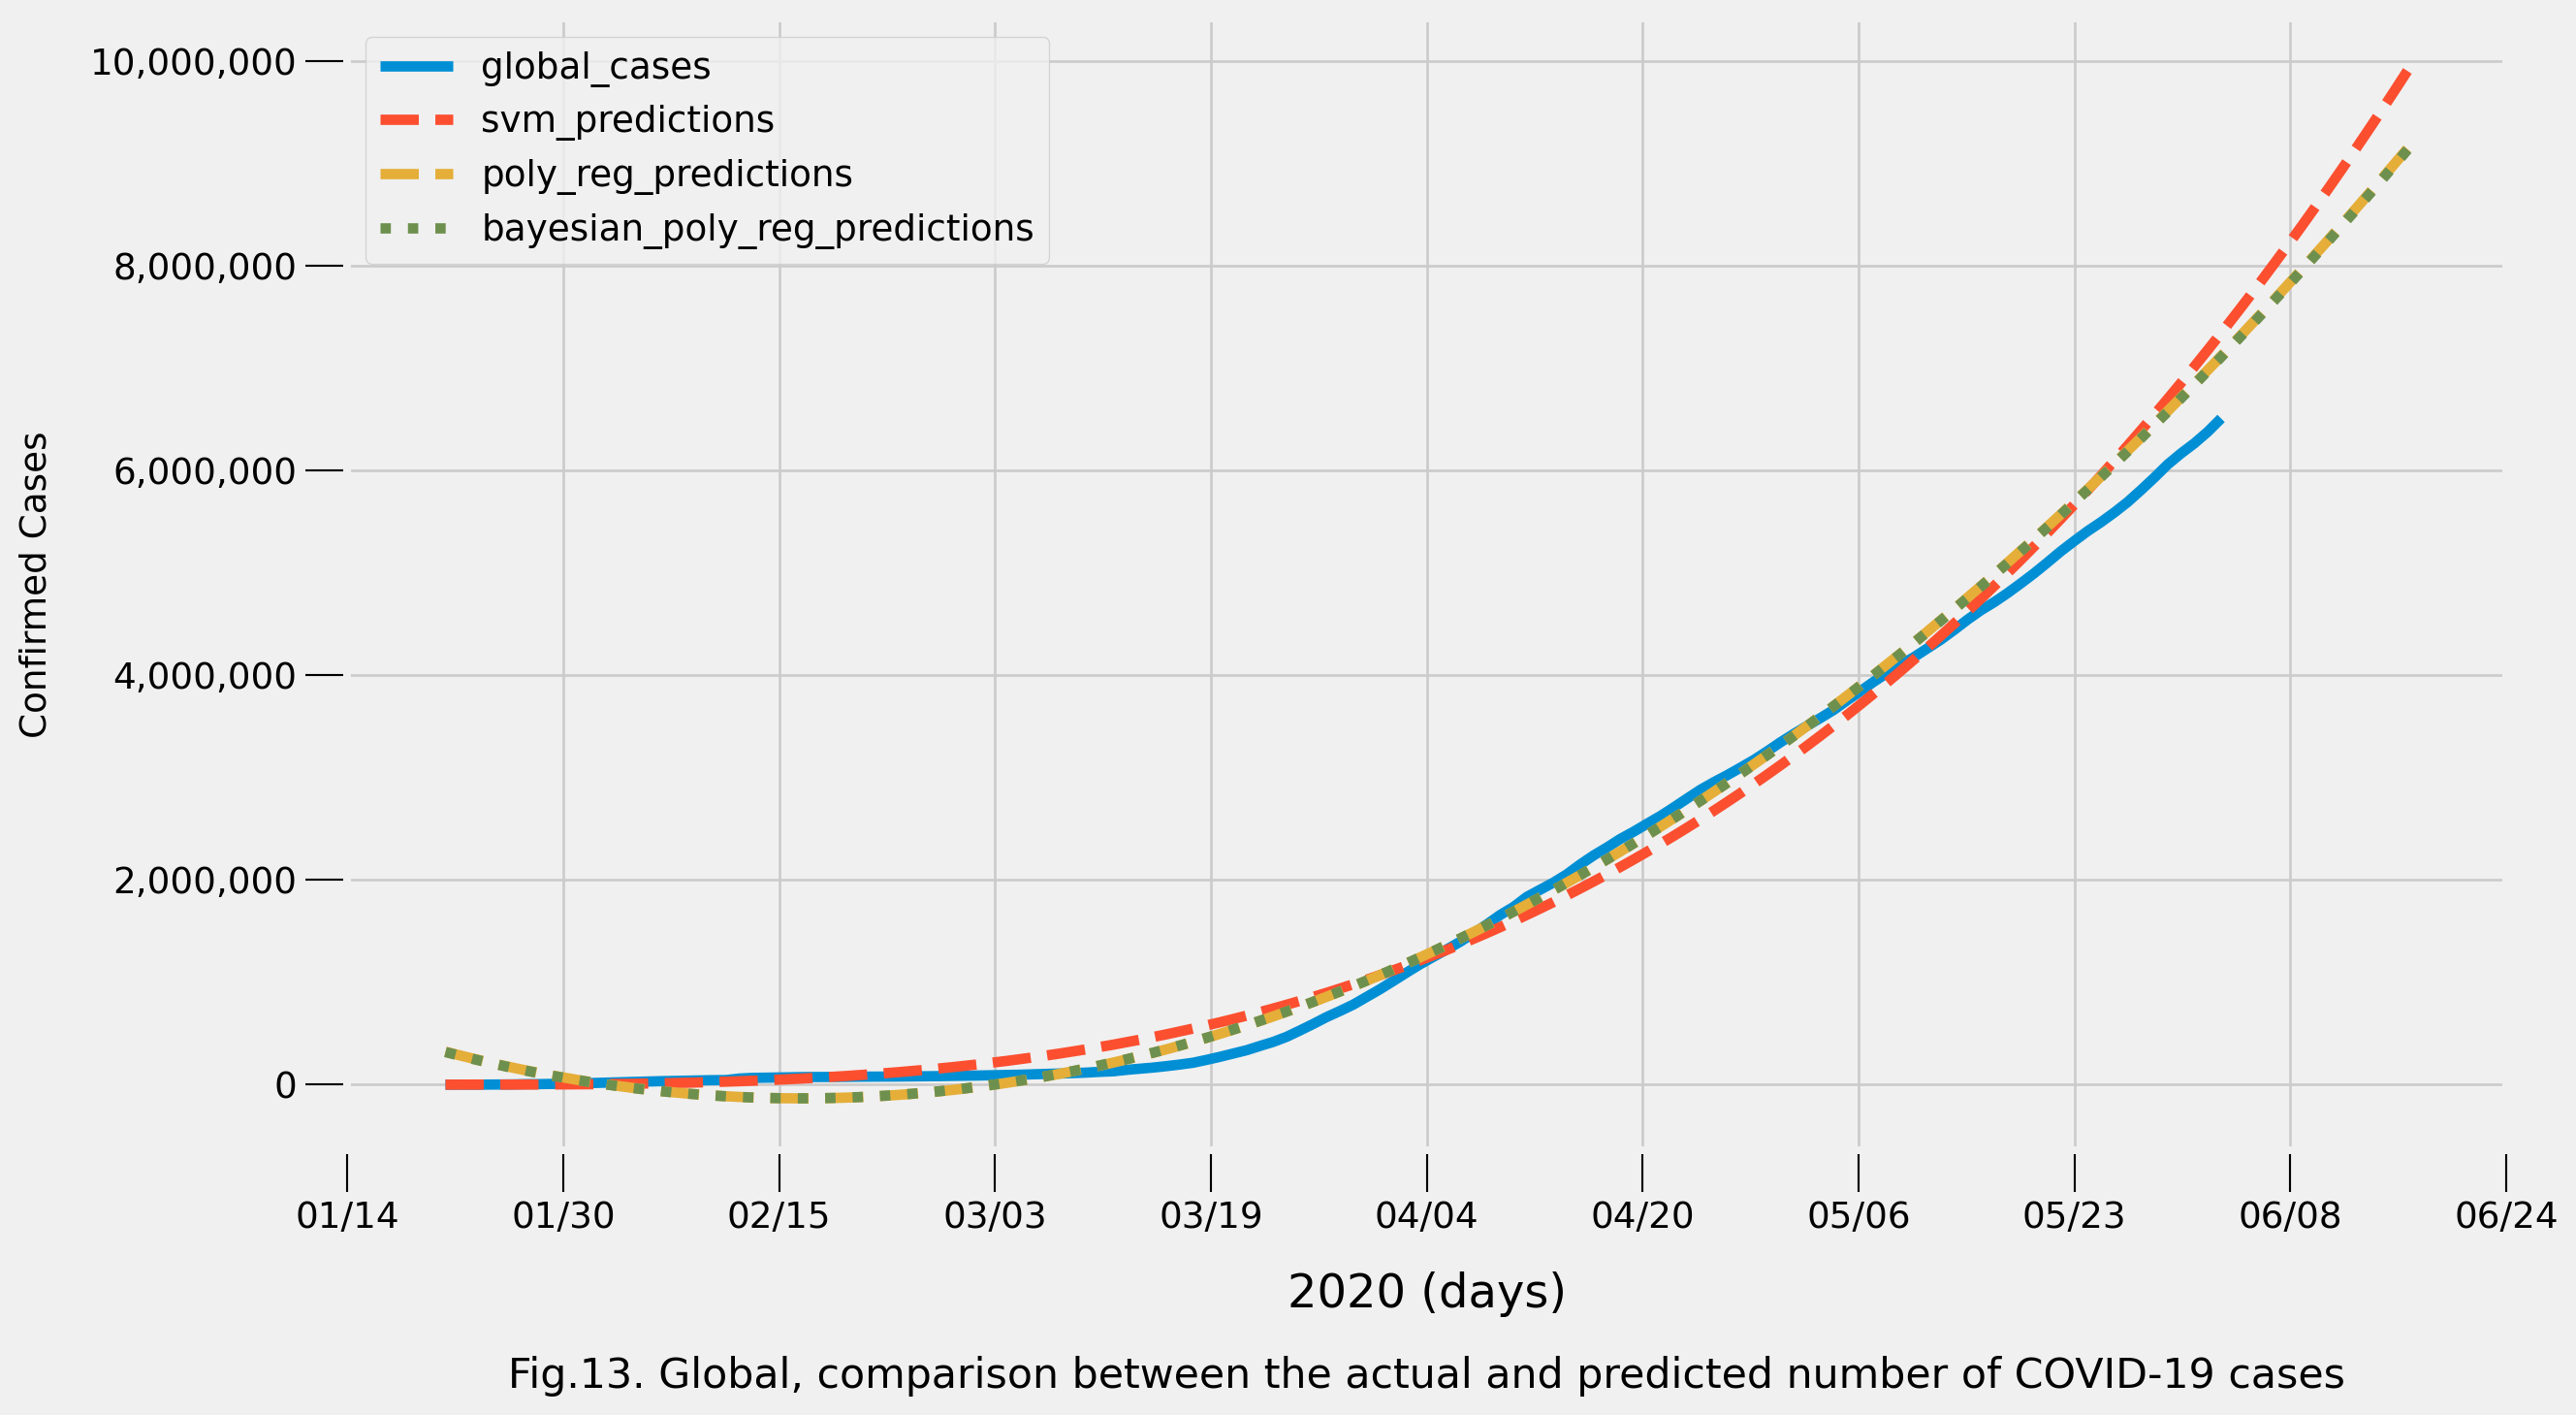

In [23]:
# Graph predictions for number of global confirmed cases
fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())

ax.plot(actual_dates, global_total['cases'], linewidth=4)
ax.plot(future_dates, svm_pred, linestyle='dashed', linewidth=4)
ax.plot(future_dates, linear_pred, linestyle='dashed', linewidth=4)
ax.plot(future_dates, bayesian_pred, linestyle='dotted', linewidth=4)

# Label plot
ax.set_ylabel('Confirmed Cases', size=14, labelpad=14)
ax.set_xlabel('2020 (days)', size=18, labelpad=14)
ax.tick_params(axis='both', size=16)
ax.legend(['global_cases', 'svm_predictions', 'poly_reg_predictions',
            'bayesian_poly_reg_predictions'], prop={'size':14});

# Add caption
fignum = 13
figtxt = " Global, comparison between the actual and predicted number of COVID-19 cases" 
figcap = 'Fig.' + str(fignum) + '.' + figtxt
ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Display the plot
plt.savefig('fig' + str(fignum) + '-global-forecast-covid19.png', bbox_inches='tight')
plt.show();

<a class="anchor" id="conclusion"></a>
# 5. Conclusion

Without a more robust, "bottom's up" model of disease dynamics, the projections from the statistical, curve-fitting models in this project are incomplete. The current models - all of which have relatively poor MAE and RMSE scores - only depend on the observed data pattern of confirmed cases. However, the models do not take into account the underlying epidemic dynamics that continue to drive the data. A [growing number of epidemiologists](https://www.statnews.com/2020/04/17/influential-covid-19-model-uses-flawed-methods-shouldnt-guide-policies-critics-say/) also agree that the approach used by curve-fitting models is flawed in its ability to accurately model the infection rate of COVID-19 because it does not model the disease itself. Thus, the project asserts that the use of curve-fitting models are best suited for the early phases of a new infection, where the individual parameters of a bottom's up model do not have to be known and complex historical infection and fatality rates can be inferred. The limitations of the curve-fitting model methodology prohibit its further use in navigating the tough road ahead, where health and economic policy implementations must be in sync as countries experiment with different approaches to cycles of reopening and mitigation. 

Nevertheless, at this time, maintaining at least 6-feet of social distancing is still critical to slowing the spread of the virus. Here are three additional ideas that, if combined, would help to make it safer and more sustainable to go about our lives, reduce hospital admissions to more manageable levels, and better support those suffering from economic hardships.

**Give everyone a mask.** Wearing a mask is really important to reducing COVID-19 transmissions. Healthcare workers rely on professional-grade masks and personal protective equipment to protect themselves and their patients from being infected and infecting others. However, shortages are leaving doctors, nurses and other frontline workers dangerously ill-equipped to care for COVID-19 patients, due to limited access to supplies such as gloves, medical masks, respirators, goggles, face shields, gowns, and aprons. Industry and governments must coordinate to boost supply, ease export restrictions, and put measures in place to stop speculation and hoarding. For the broad population, the key fact is that while wearing a mask (or cloth face coverings) does little to protect the wearer from the risk of getting infected, it does a lot to prevent the risk that the wearer spreads the virus to other people. 

**Increase and improve testing.** Widespread testing makes the virus much easier to manage. The vast majority of current COVID-19 testing in the world is being used for diagnostic purposes, to tell if someone who’s sick is infected with the virus. This may have made sense at the start of the pandemic, when lots of people had the sniffles and few people had COVID-19. However, right now, you don’t need a test if you’re sick; rather, you should stay home and self-isolate — unless you’re worried your symptoms are more serious, in which case go to a hospital right now. In terms of test, the priority should be on ensuring the detection of cases among people who, if they are positive, are very likely to spread the infection to large numbers of other people. That will get us the most value in terms of surveillance testing to reduce infections. Then, as test capacity grows, more people can be tested.

**Let people go outside.** Although it is possible to inhale droplets from another person's mouth outside, outdoor transmission of the virus should not be the primary concern. People should be able to safely go to any outdoor space with ample room for social distancing, such as beaches, parks and trails. In contrast, they should limit their time in outdoor spaces where social distancing can't be maintained most of the time — any crowded area. People should also limit how much time they spend in any indoor spaces with poor air exchange and lots of people with no effective ability to social distance. I believe that almost every business can engineer their space to ensure that they limit the number of people at one time to a number that is determined by air exchange and size of their facility.

<a class="anchor" id="appendix"></a>
## 5.1 Appendix

The section explores trends and seasonality of global confirmed cases.

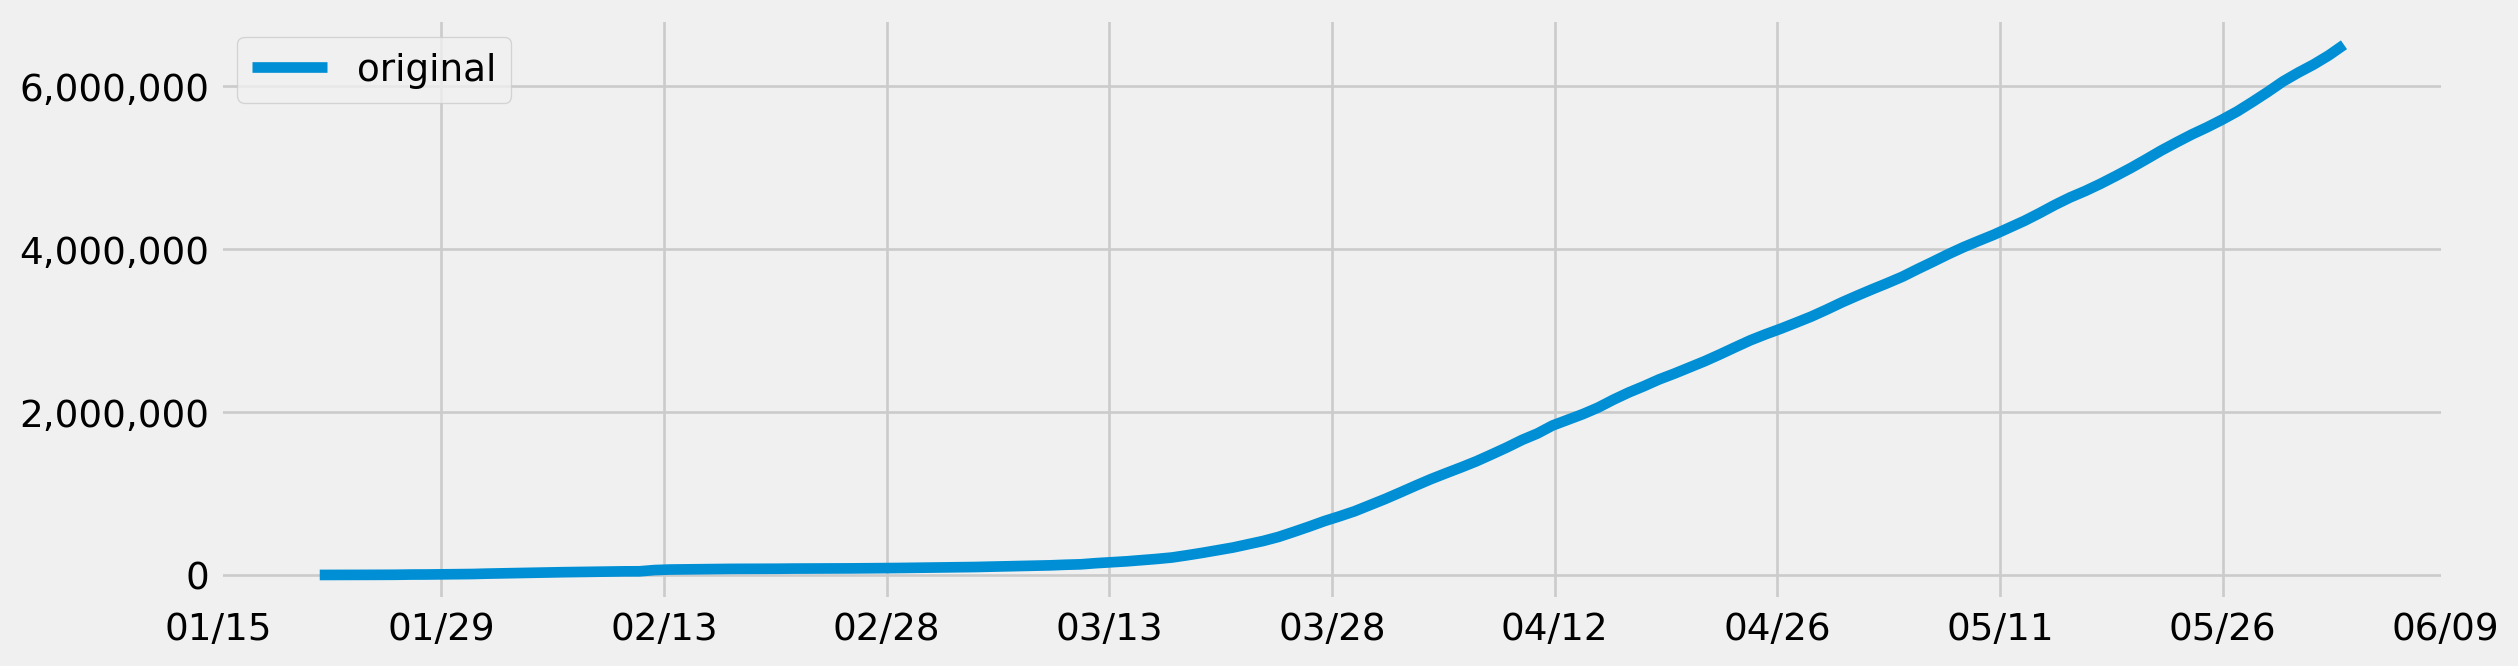

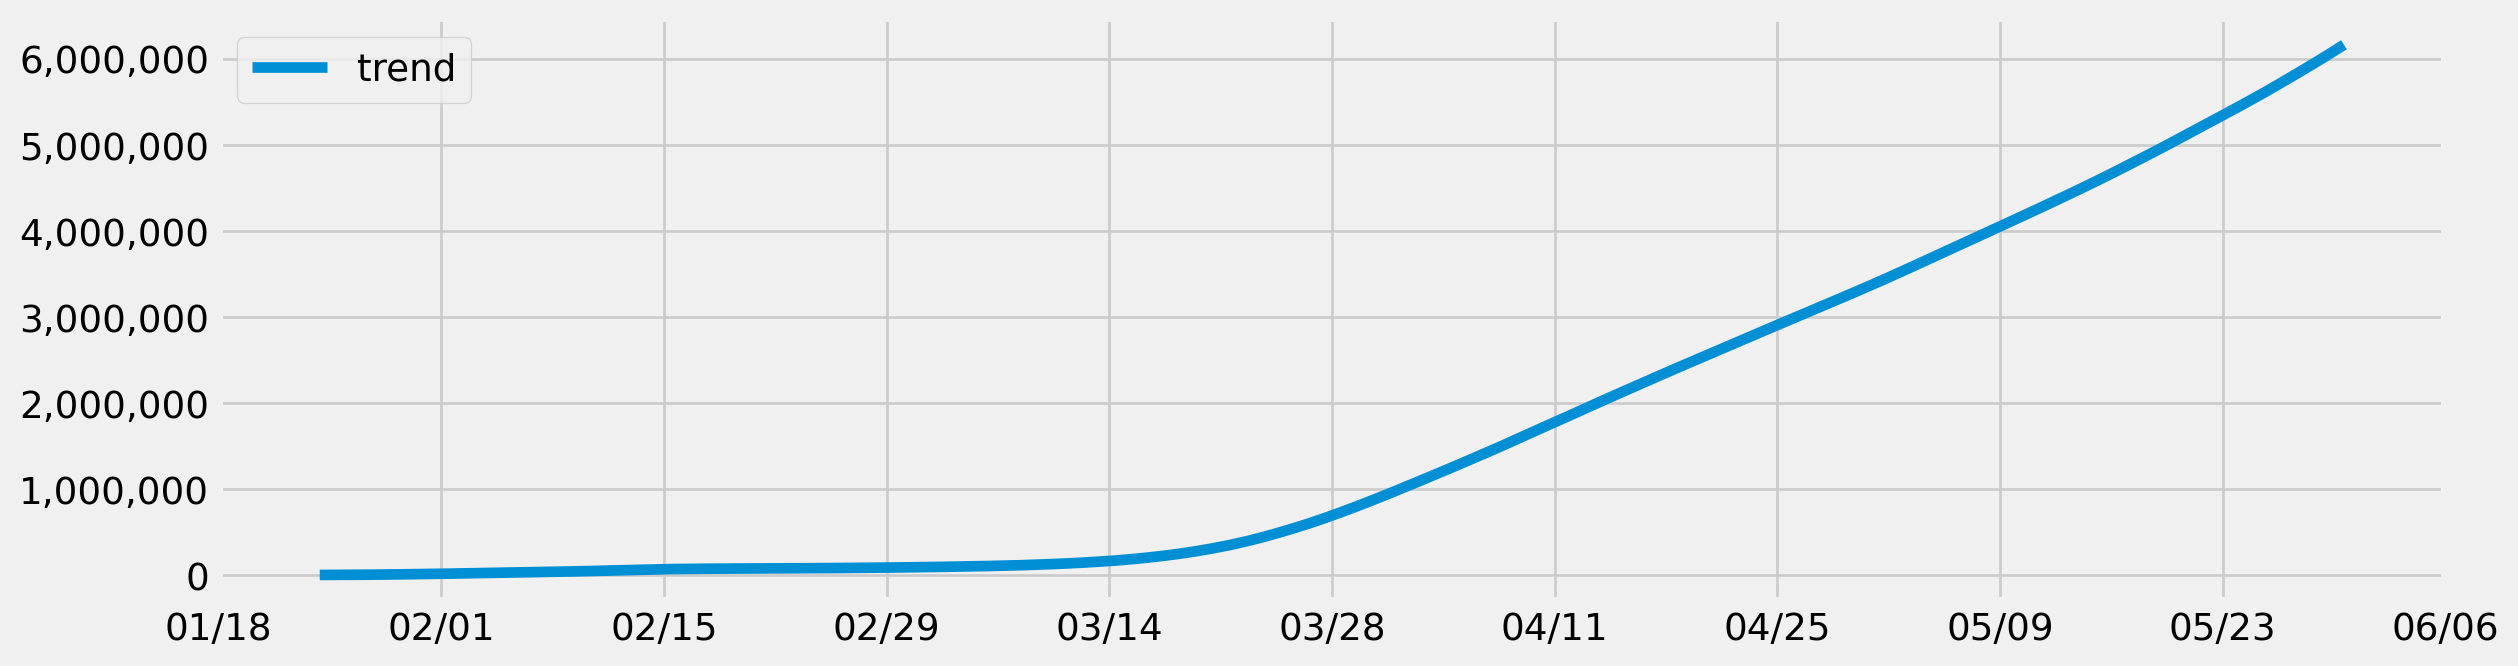

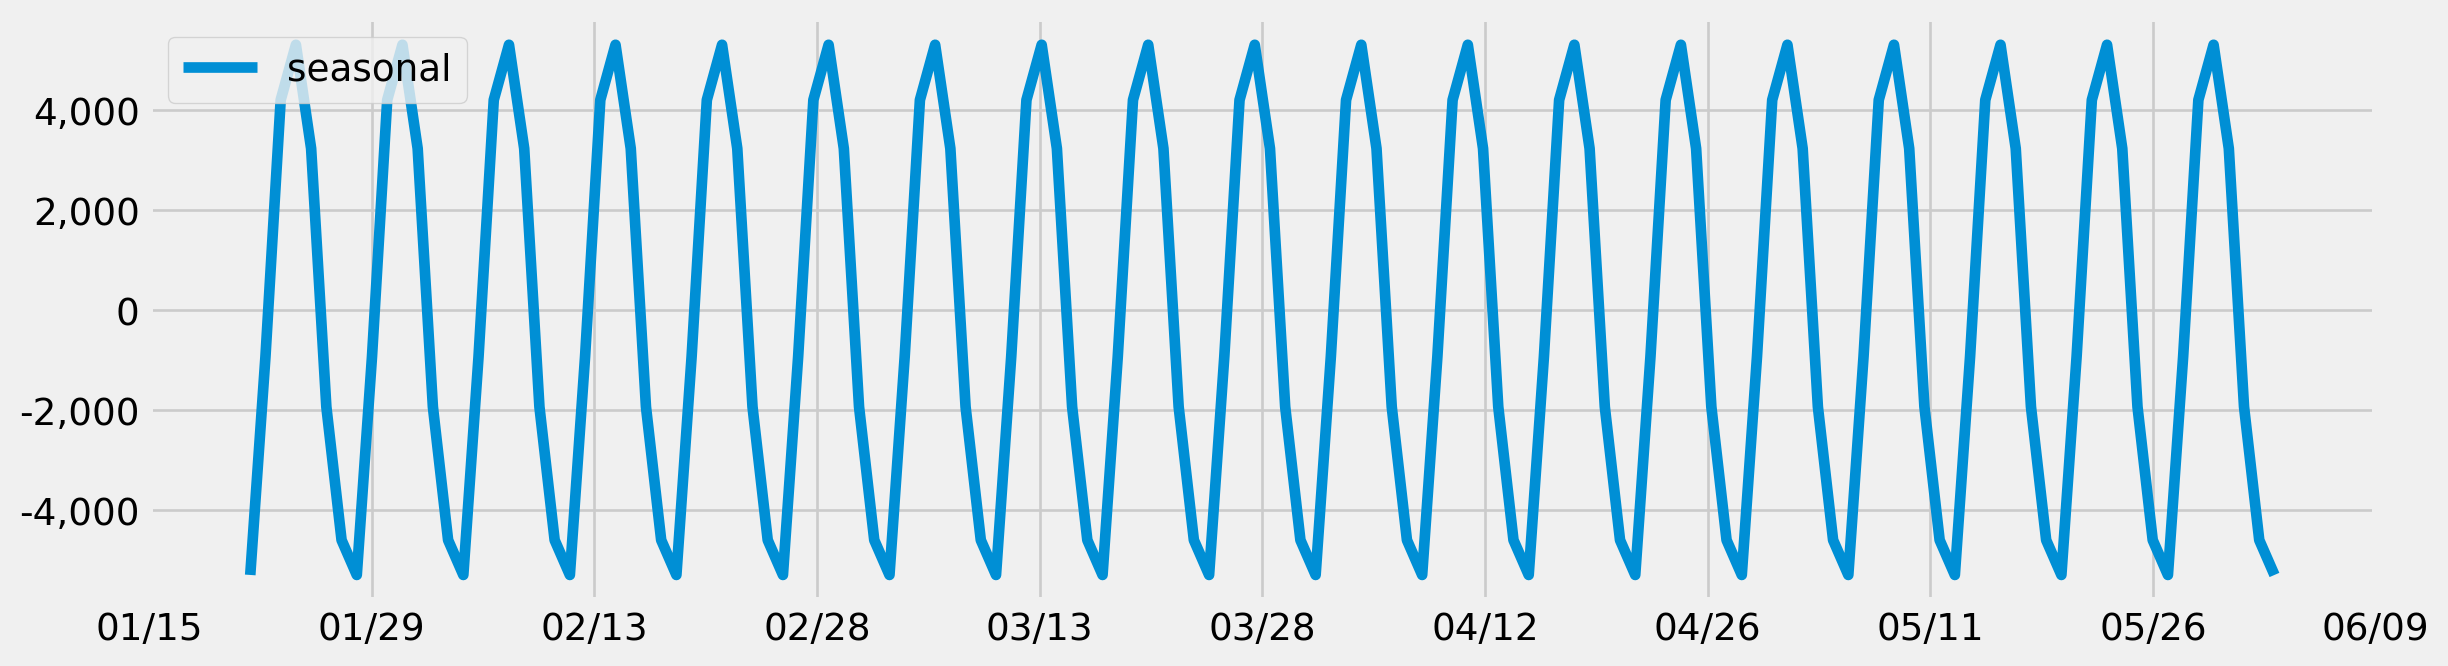

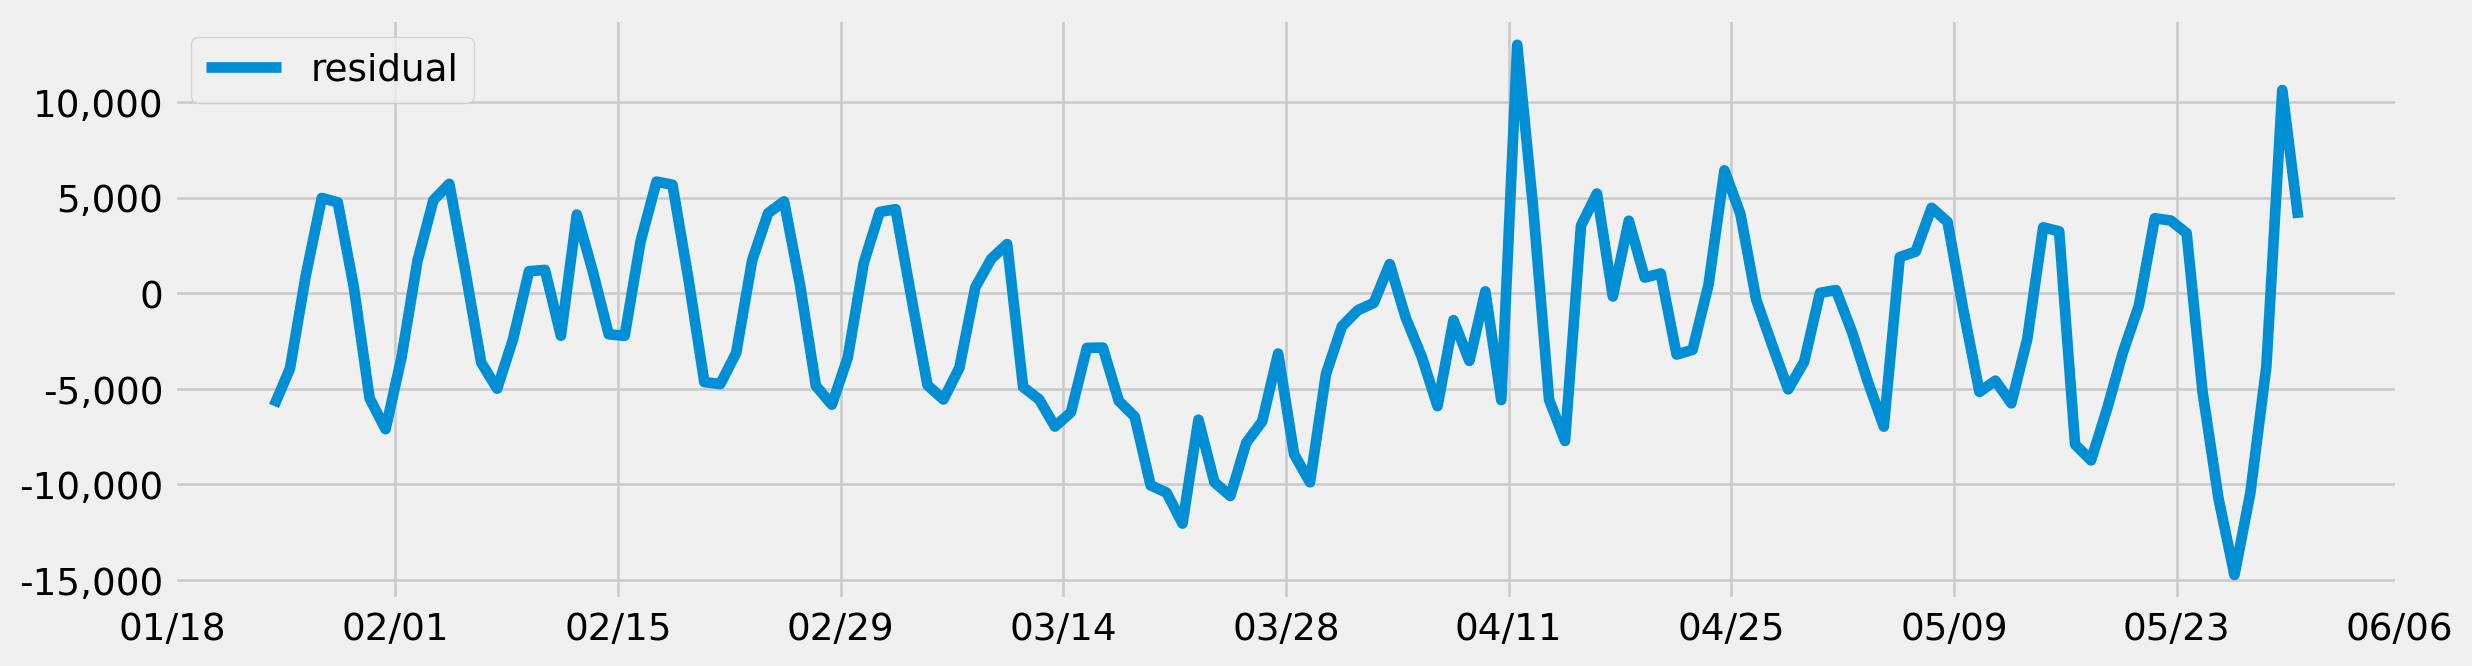

In [24]:
# Explore decomposition of confirmed cases
original = df_global['cases']
decomposition = seasonal_decompose(original)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

for i in ['original', 'trend', 'seasonal', 'residual']:
    fig,ax = plt.subplots(figsize=(13.33, 3.75), dpi=96)
    ax.plot(eval(i), label=i, linewidth=4)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
            lambda x, p: format(int(x), ',')))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())
    ax.legend(loc='upper left')
    
    plt.show()

In practice we can assume the series to be stationary if it has constant statistical properties over time such as constance mean and constant variance. The Dickey-fuller Test is a statistical tests for checking stationarity. First we consider the null hypothesis: the time series is non- stationary. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary

In [27]:
# Parse time series data to test for staionarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, caption, fign):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()
    
    #Plot rolling statistics:
    fig,ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
            lambda x, p: format(int(x), ',')))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())
    
    ax.plot(timeseries, label='Original', linewidth=2)
    ax.plot(rolmean, label='Rolling Mean', linewidth=4)
    ax.plot(rolstd, label='Rolling Std', linewidth=4)

    # Label plot
    ax.set_ylabel('Confirmed Cases', size=14, labelpad=14)
    ax.set_xlabel('2020 (days)', size=18, labelpad=14)
    ax.tick_params(axis='both', size=16)
    ax.legend(['original', 'rolling_mean', 'rolling_std'], loc='upper left', prop={'size':14});

    # Add caption
    fignum = fign
    figtxt = " Global, {} of COVID-19 cases".format(caption) 
    figcap = 'Fig.' + str(fignum) + '.' + figtxt
    ax.text(0.5, -0.2, figcap, fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    # Display the plot
    # plt.savefig('fig' + str(fignum) + "-" + caption.lower() + '-covid19.png', bbox_inches='tight')
    plt.show();
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test for {}:'.format(caption))
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

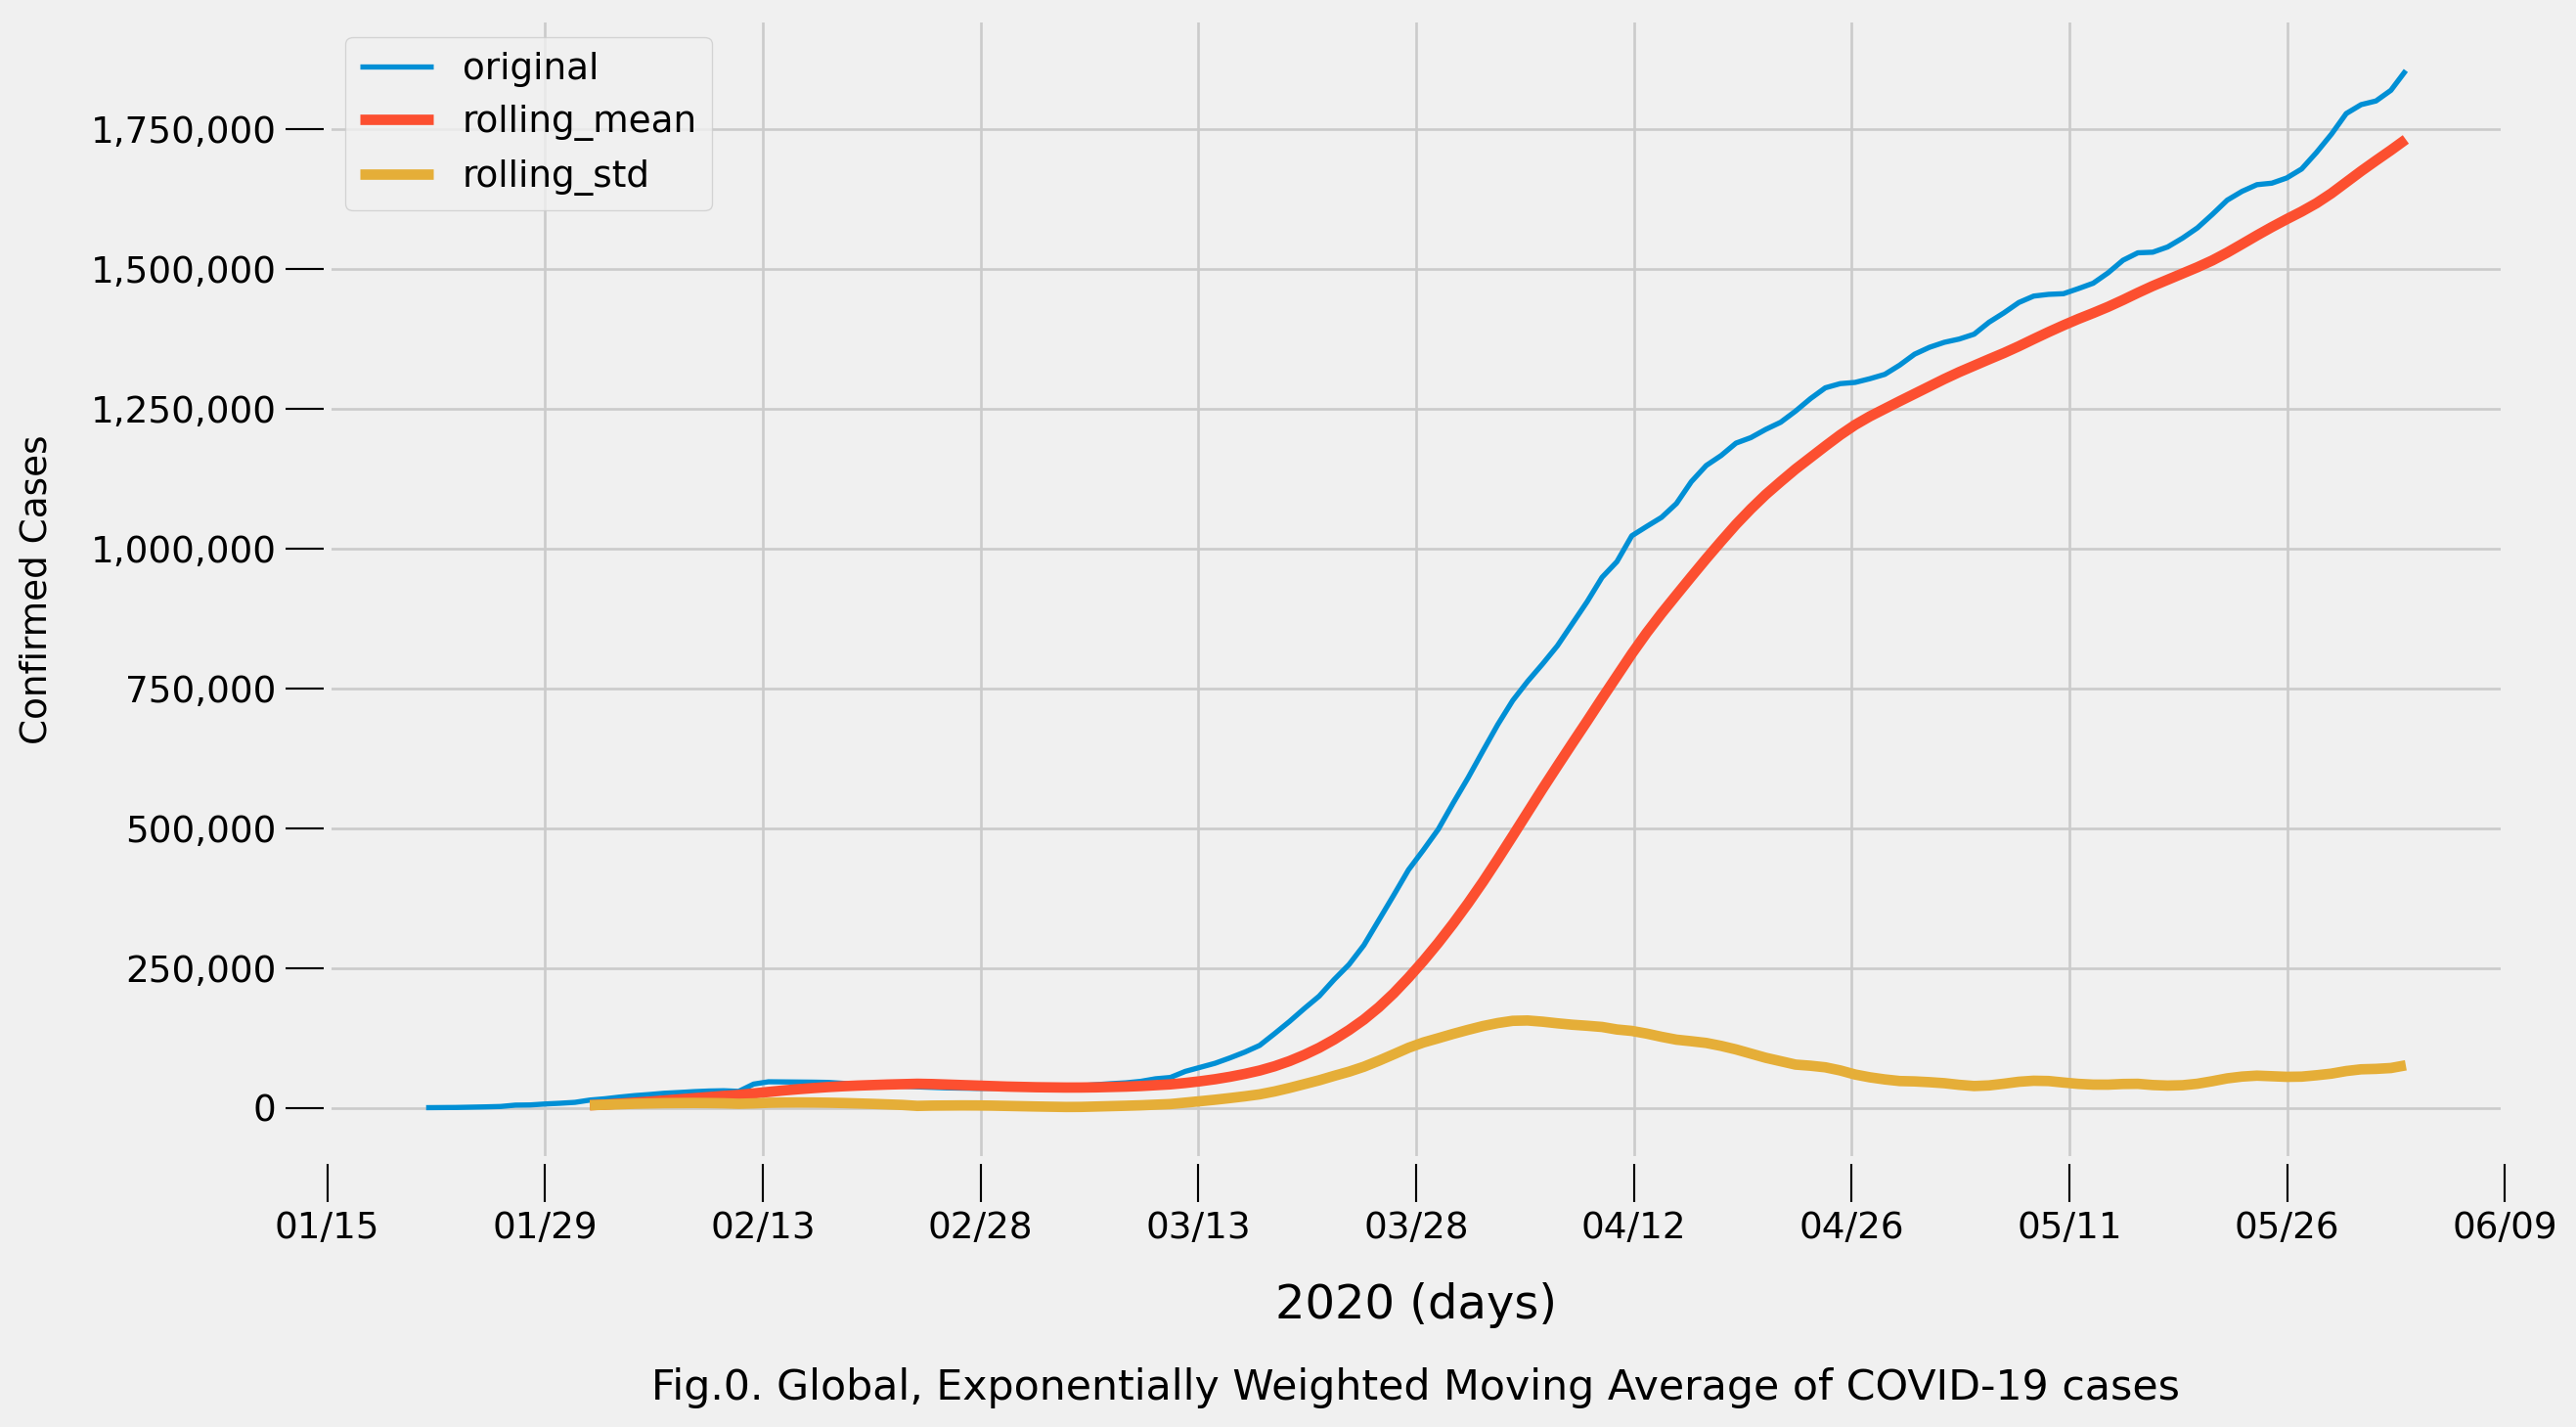

Results of Dickey-Fuller Test for Exponentially Weighted Moving Average:
Test Statistic                   1.527473
p-value                          0.997623
#Lags Used                      11.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


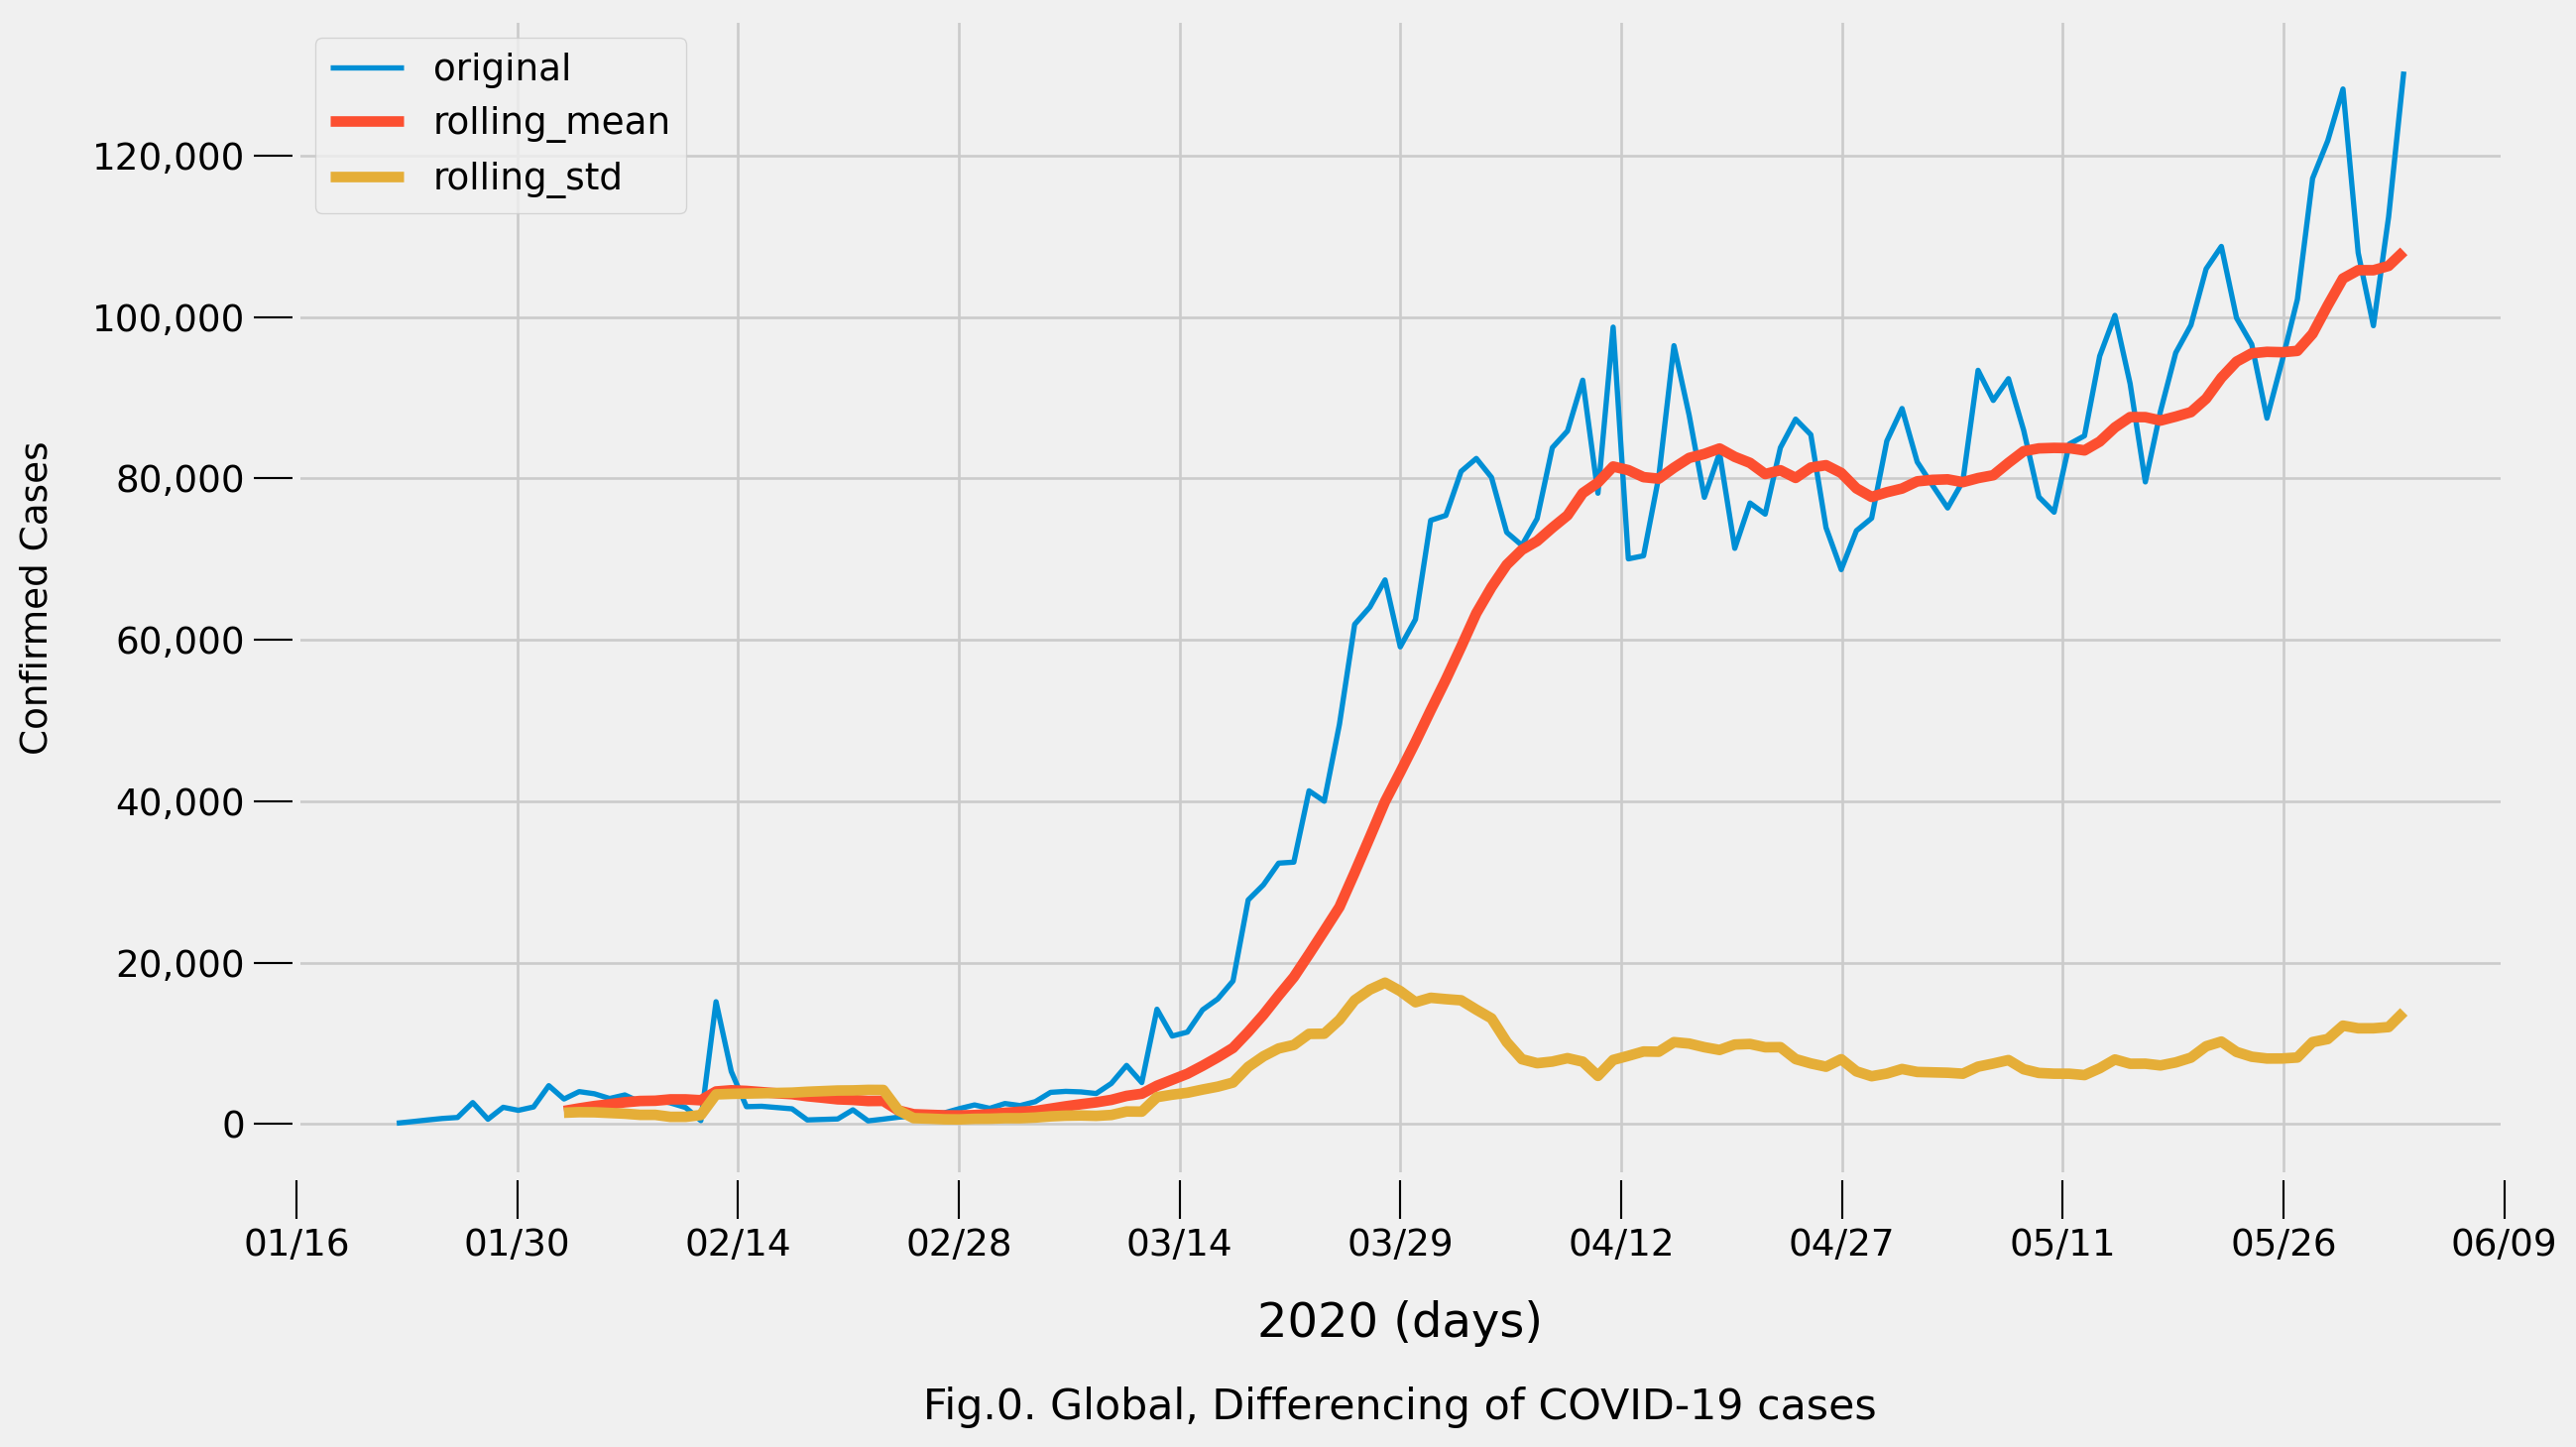

Results of Dickey-Fuller Test for Differencing:
Test Statistic                  -0.163394
p-value                          0.942747
#Lags Used                      11.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


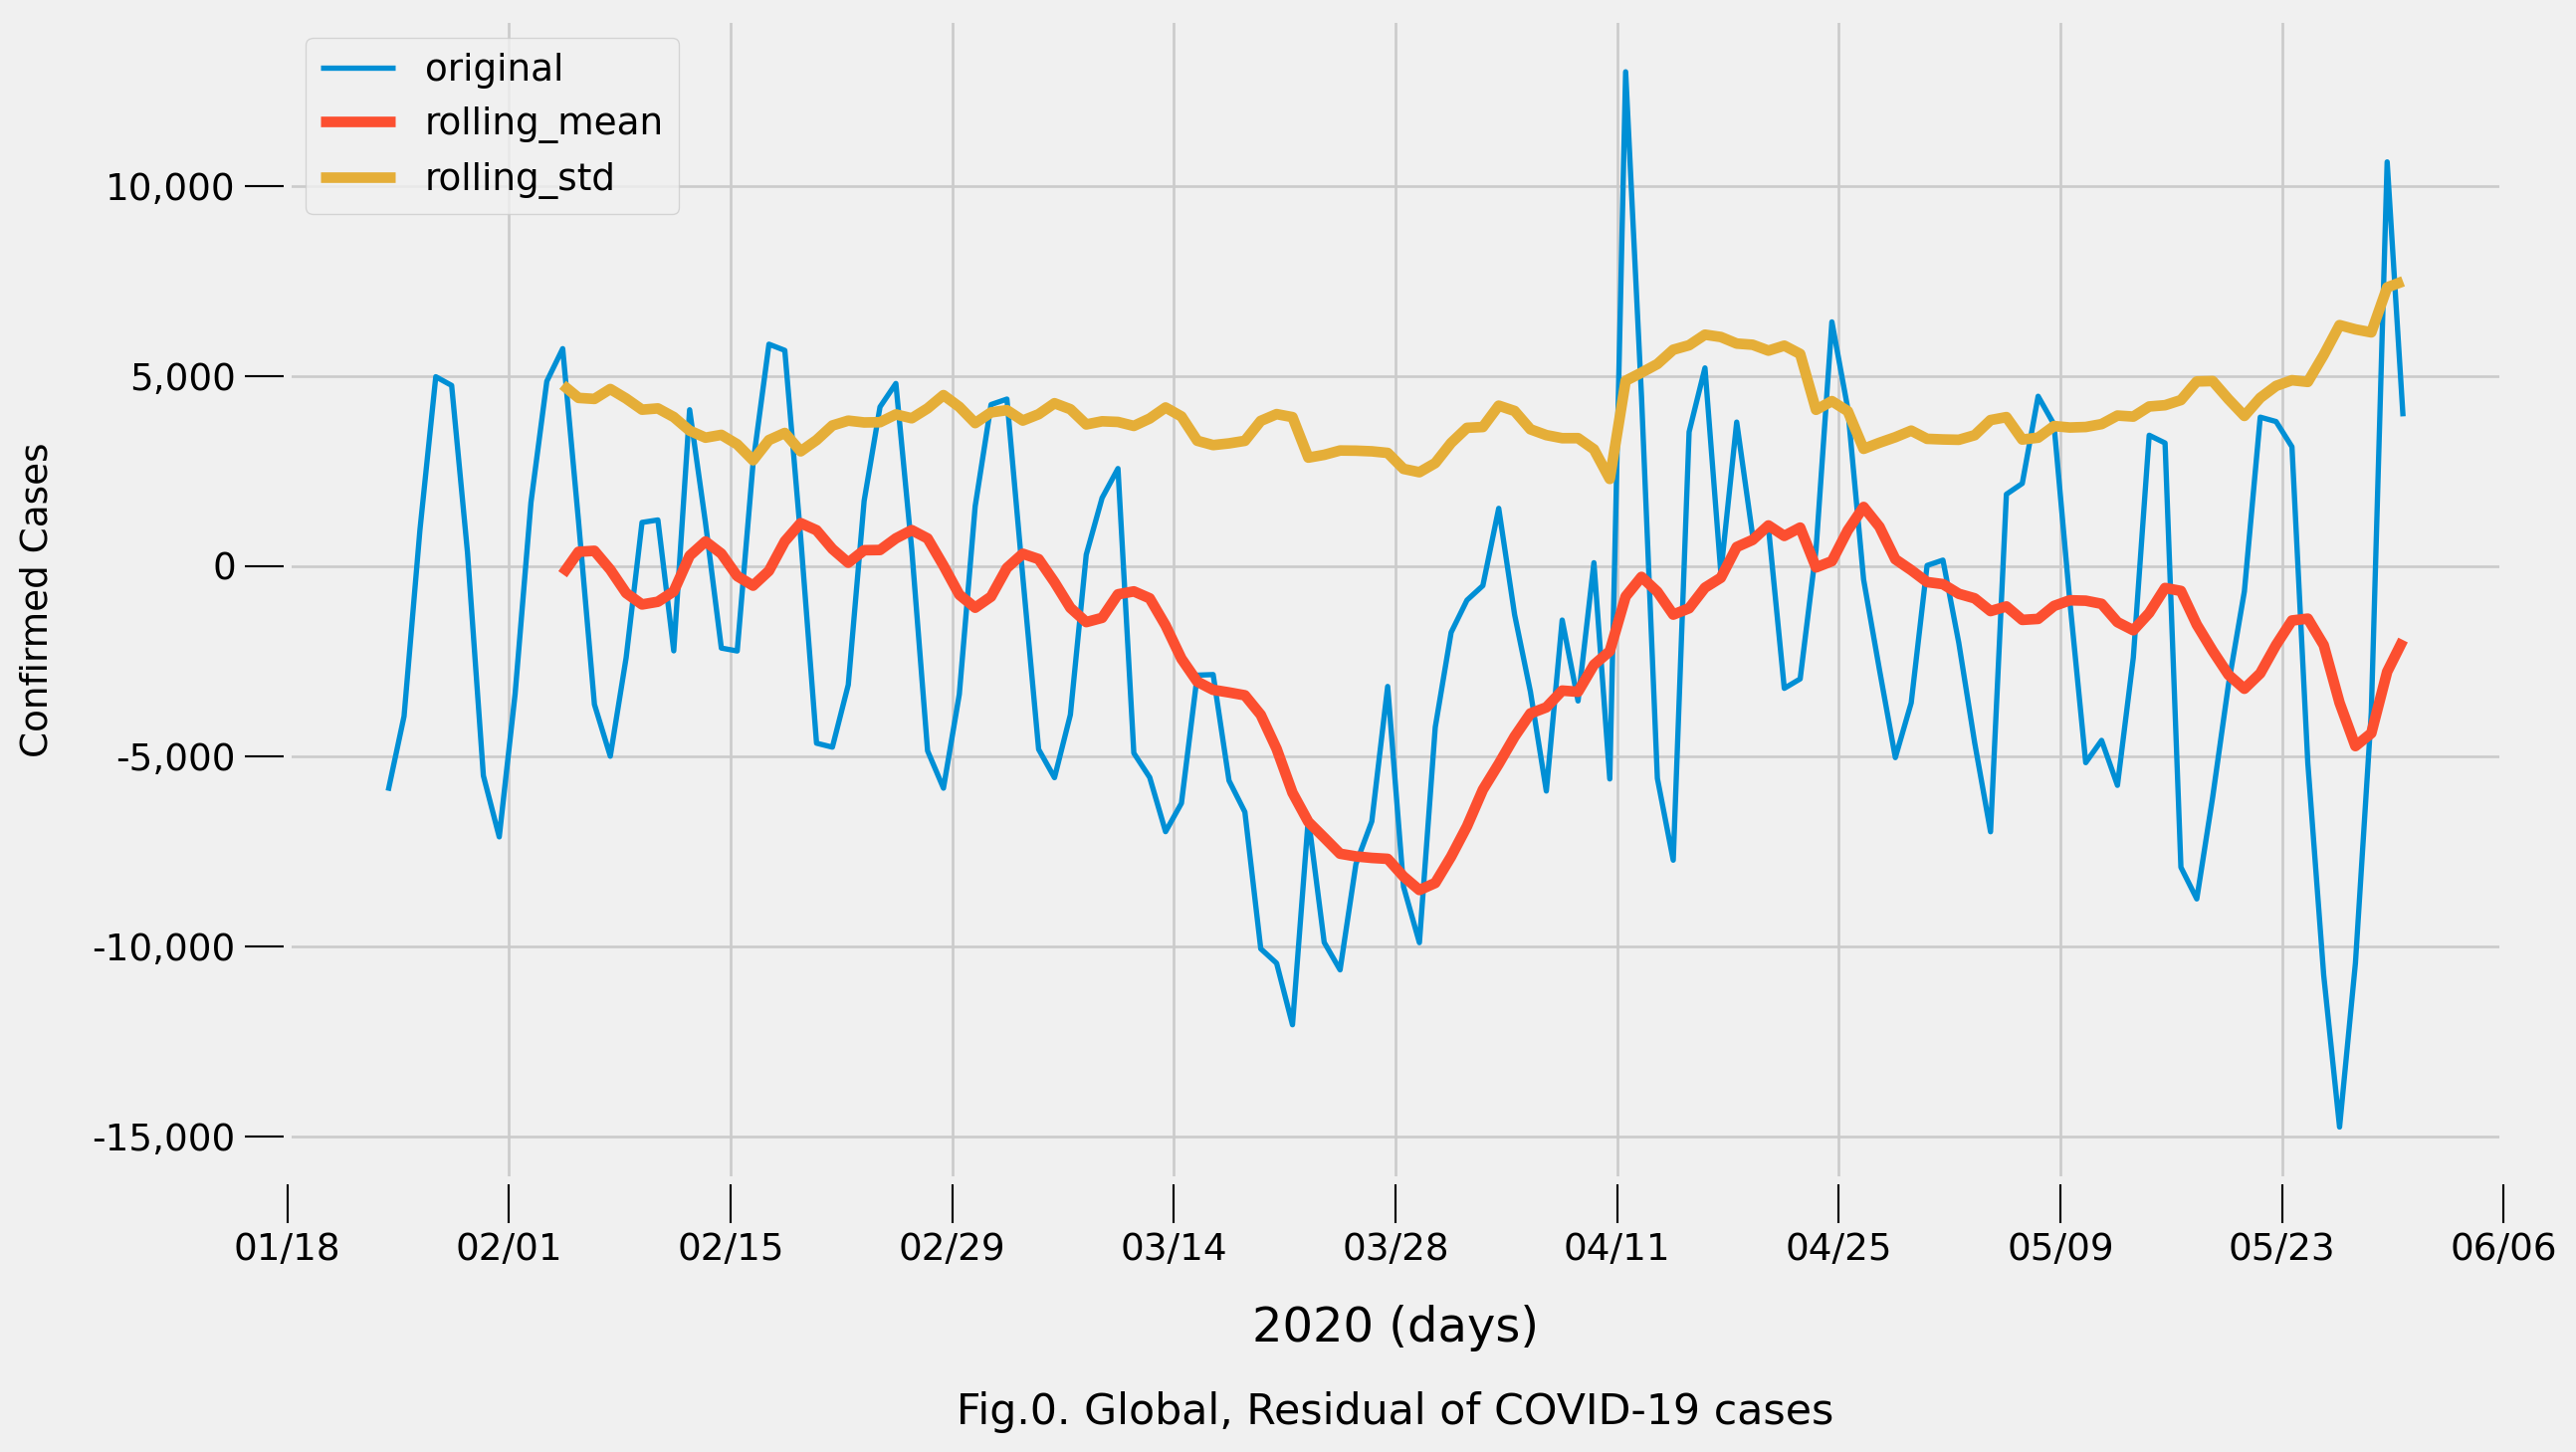

Results of Dickey-Fuller Test for Residual:
Test Statistic                  -1.807129
p-value                          0.376928
#Lags Used                       6.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


In [28]:
# Explore trend and seasonality on stationarity

# Address trend with exponentially weighted moving average
df_global['expweight'] = df_global.iloc[:,0].ewm(span=40, adjust=False).mean()
original_ewma_diff = original - df_global['expweight']
cap1 = 'Exponentially Weighted Moving Average'
test_stationarity(original_ewma_diff, cap1, 0)

# The data is not stationary because the mean is increasing 
# (even though the std is small) and the Test Statistic is 
# greater than the Critical Value.

# Address seasonality with differencing (take difference usign time lag)
original_diff = original - original.shift()
original_diff.dropna(inplace=True)
cap2 = 'Differencing'
test_stationarity(original_diff, cap2, 0)

# Test the residual data after removing trend and seasonality
original_decompose = residual
original_decompose.dropna(inplace=True)
cap3 = 'Residual'
test_stationarity(original_decompose, cap3, 0)

<a class="anchor" id="acknowledgments"></a>
## Acknowledgments 

The Center for Systems Science and Engineering at Johns Hopkins University developed an interactive web-based dashboard to visualize and track reported cases in real-time: "The dashboard, first shared publicly on January 22, illustrates the location and number of confirmed COVID-19 cases, deaths and recoveries for all affected countries. It was developed to provide researchers, public health authorities and the general public with a user-friendly tool to track the outbreak as it unfolds."

The project referenced the following resources:
* https://systems.jhu.edu/research/public-health/ncov/
* https://github.com/reichlab/covid19-forecast-hub
* https://www.sciencedirect.com/science/article/pii/S0960077920302538
* https://www.vox.com/2020/5/13/21248157/testing-quarantine-masks-stimulus
* https://fivethirtyeight.com/features/why-its-so-freaking-hard-to-make-a-good-covid-19-model/
* https://projects.fivethirtyeight.com/covid-forecasts/

----------
The Code Caviar is a digital magazine about data science and analytics that dives deep into key topics, so you can experience the thrill of solving at scale.